In [1]:
import sys
sys.path.insert(0, "../")

import numpy as np
import matplotlib.pyplot as plt
from time import time
from astropy.table import Table

from sklearn.datasets import load_iris
from mcfa import (mcfa, mpl_utils, utils)

%matplotlib inline

In [2]:
GALAH_CATALOG_PATH = "../catalogs/GALAH_DR2.1_catalog.fits"
#galah = fits.open(GALAH_CATALOG_PATH)[1].data
galah = Table.read(GALAH_CATALOG_PATH)

In [3]:
D = 15
N = 10000 # subsample the data for testing

np.random.seed(42)

element_label_names = [ln for ln in galah.dtype.names if ln.endswith("_fe") and not ln.startswith(("flag_", "e_", "alpha_"))]
print("\n".join(element_label_names))

# Select a subset of stars and abundances
is_ok = dict()
for label_name in element_label_names:
    is_ok[label_name] = sum(galah["flag_{}".format(label_name)] == 0)

import operator
for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]:
    print(k, v)
    
use_element_label_names = [k for k, v in sorted(is_ok.items(), key=operator.itemgetter(1))[::-1]][:D - 1]

# Add in Eu.
use_element_label_names.append("eu_fe")

meets_qc = (galah["flag_cannon"] == 0)
print(sum(meets_qc))
for label_name in use_element_label_names:
    meets_qc *= (galah["flag_{}".format(label_name)] == 0) \
              * (np.isfinite(galah[label_name]))
    print(label_name, sum(meets_qc))

use_element_label_names.append("fe_h")
    


X = np.array([galah[ln][meets_qc] for ln in use_element_label_names]).T

if N < X.shape[0]:
    print("Sub-sampling {} stars (from {})".format(N, X.shape[0]))
    idx = np.random.choice(X.shape[0], N, replace=False)
    X = X[idx]
    

fe_h_index = list(use_element_label_names).index("fe_h")
for d in range(D):
    if d == fe_h_index: continue
    X[:, d] += X[:, fe_h_index]
    
    
label_names = np.array(["{}_h".format(ea.split("_")[0]) for ea in use_element_label_names])
    
N, D = X.shape
assert N > D
assert np.all(np.isfinite(X))

li_fe
c_fe
o_fe
na_fe
mg_fe
al_fe
si_fe
k_fe
ca_fe
sc_fe
ti_fe
v_fe
cr_fe
mn_fe
co_fe
ni_fe
cu_fe
zn_fe
y_fe
ba_fe
la_fe
eu_fe
na_fe 265806
mg_fe 264551
sc_fe 251749
ti_fe 250655
zn_fe 248993
mn_fe 247222
y_fe 244475
ca_fe 240420
ni_fe 235944
cr_fe 235783
o_fe 230613
si_fe 228337
k_fe 214247
ba_fe 206675
v_fe 184428
cu_fe 184380
al_fe 178739
la_fe 52715
eu_fe 42901
c_fe 29126
co_fe 18332
li_fe 3963
264227
na_fe 239580
mg_fe 226436
sc_fe 209213
ti_fe 195146
zn_fe 179550
mn_fe 169286
y_fe 155500
ca_fe 146109
ni_fe 134787
cr_fe 125124
o_fe 111499
si_fe 101675
k_fe 86929
ba_fe 77881
eu_fe 7984


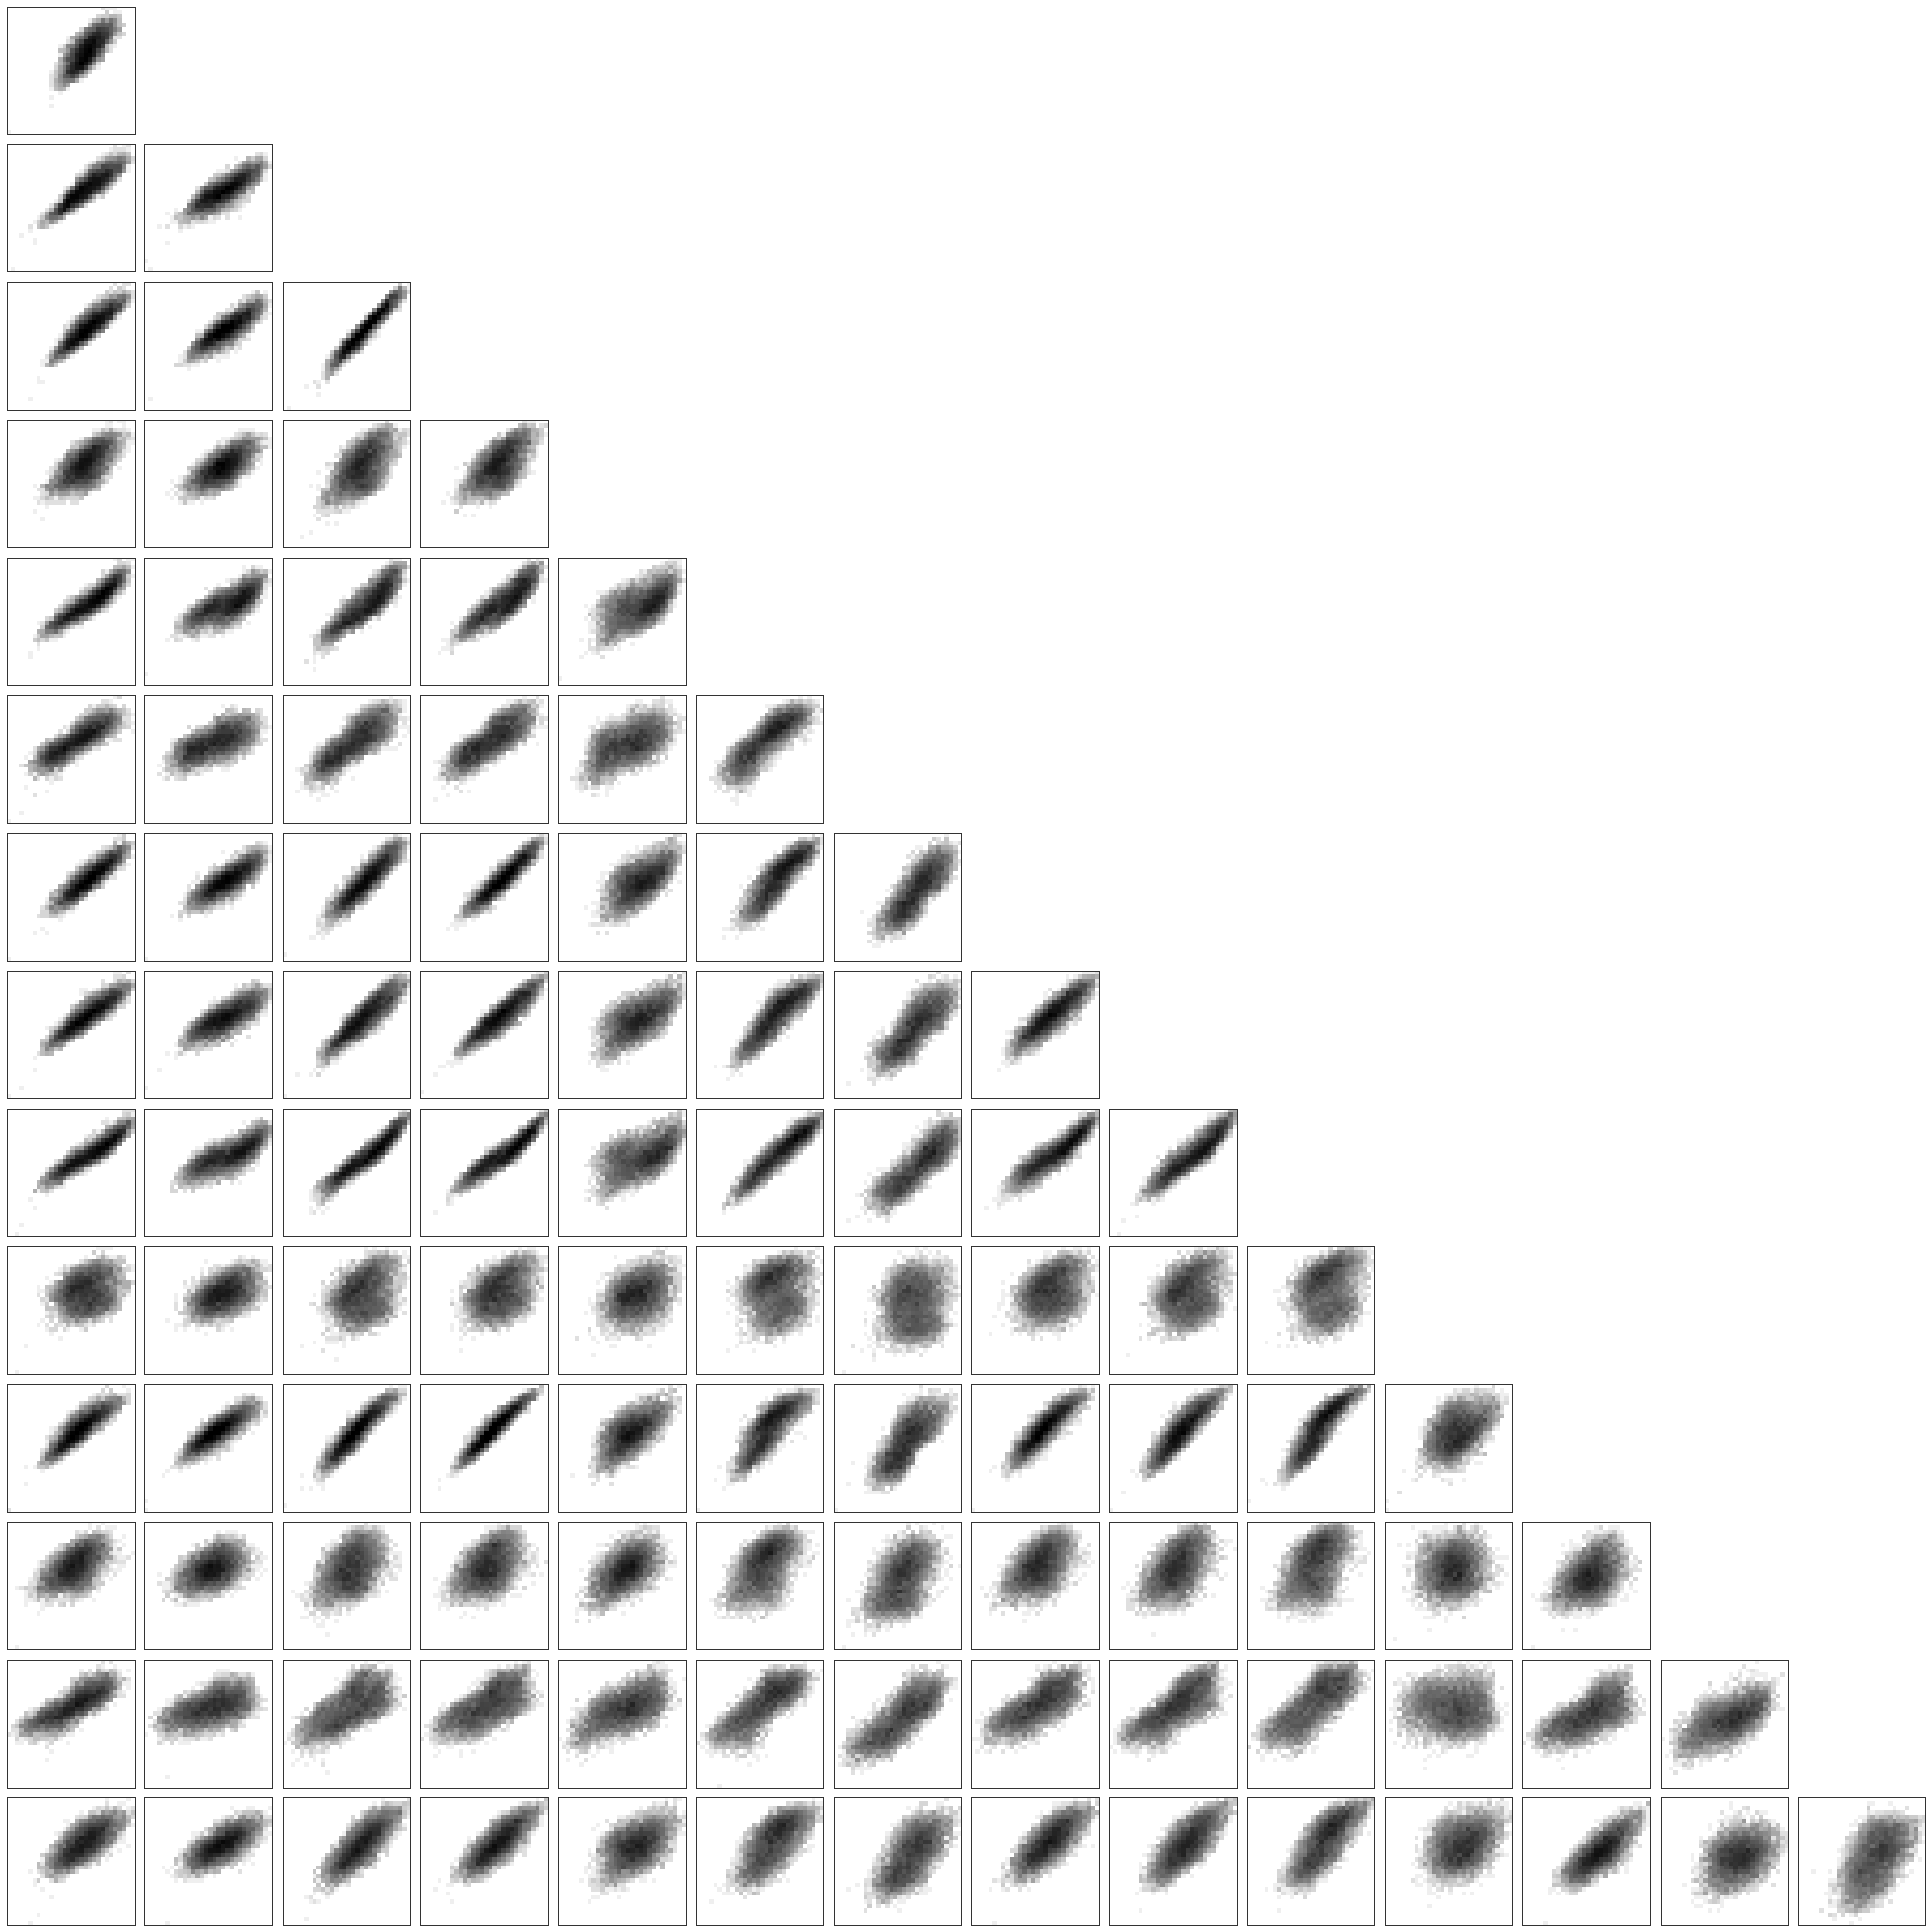

In [4]:
fig = mpl_utils.corner_hist(X)

In [5]:
J = 3 # number of latent factors
K = 5 # number of clusters

t_init = time()

model = mcfa.MCFA(n_latent_factors=J, n_components=K, 
                  n_random_init=0, n_init=1, init_method="eigen-A")
model.fit(X)

t_opt = time() - t_init

print("Took {:.0f}s to optimize. ll = {:.0f}".format(t_opt, model.log_likelihood_))

[1.40905380e-04 3.79085541e-05 1.52587891e-05 3.76701355e-05
 8.60691071e-05 6.91413879e-06 3.22103500e-04 6.33332014e-01
 4.12464142e-05 3.31640244e-04]
[9.98973846e-05 3.60012054e-05 2.21729279e-05 3.38554382e-05
 6.89029694e-05 6.19888306e-06 3.60965729e-04 6.72159910e-01
 4.19616699e-05 3.77178192e-04]
[1.33991241e-04 1.28984451e-04 3.12328339e-05 3.88622284e-05
 7.98702240e-05 6.19888306e-06 3.60012054e-04 6.86363935e-01
 4.19616699e-05 3.89099121e-04]
[1.00135803e-04 3.69548798e-05 6.00814819e-05 4.31537628e-05
 9.89437103e-05 6.91413879e-06 3.56197357e-04 6.82278872e-01
 4.10079956e-05 3.78847122e-04]
[1.00135803e-04 3.69548798e-05 2.09808350e-05 3.48091125e-05
 6.81877136e-05 5.96046448e-06 3.47137451e-04 7.04677820e-01
 7.70092010e-05 8.94069672e-04]
expectation: 3.39s [2.98023224e-04 3.38844895e+00 4.23502922e-03]
maximization: 0.02s
[1.02996826e-04 4.38690186e-05 4.50611115e-05 4.19616699e-05
 8.70227814e-05 7.10487366e-05 7.72953033e-04 6.67938232e-01
 4.57763672e-05 4.2700

[9.87052917e-05 4.02927399e-05 2.09808350e-05 3.38554382e-05
 7.00950623e-05 5.72204590e-06 4.35352325e-04 7.40883827e-01
 4.22000885e-05 3.76701355e-04]
expectation: 3.56s [4.42981720e-04 3.55231118e+00 2.94089317e-03]
maximization: 0.02s
[1.38044357e-04 8.86917114e-05 6.12735748e-05 4.98294830e-05
 2.56061554e-04 1.21593475e-05 4.45842743e-04 6.26801968e-01
 3.81469727e-05 3.45945358e-04]
[1.00851059e-04 3.71932983e-05 2.28881836e-05 3.60012054e-05
 6.91413879e-05 6.91413879e-06 3.51905823e-04 7.05188990e-01
 4.22000885e-05 3.70740891e-04]
[9.77516174e-05 3.71932983e-05 2.19345093e-05 3.88622284e-05
 7.00950623e-05 5.96046448e-06 5.80072403e-04 7.19912052e-01
 4.38690186e-05 3.91960144e-04]
[9.89437103e-05 3.79085541e-05 2.19345093e-05 3.40938568e-05
 6.91413879e-05 5.96046448e-06 3.49998474e-04 8.00701857e-01
 7.82012939e-05 5.22851944e-04]
[1.03235245e-04 3.67164612e-05 2.09093094e-04 3.79085541e-05
 1.06096268e-04 6.91413879e-06 4.51087952e-04 7.66352177e-01
 3.98159027e-05 3.8409

[1.01089478e-04 3.79085541e-05 2.31266022e-05 3.38554382e-05
 6.91413879e-05 5.96046448e-06 4.47034836e-04 7.87348032e-01
 4.19616699e-05 4.56809998e-04]
[1.14202499e-04 5.19752502e-05 2.64883041e-04 4.79221344e-05
 1.17063522e-04 1.02519989e-05 4.11748886e-04 7.06922054e-01
 4.29153442e-05 3.73125076e-04]
[1.02758408e-04 4.50611115e-05 4.10079956e-05 3.71932983e-05
 7.17639923e-05 5.96046448e-06 4.58955765e-04 7.85261154e-01
 4.19616699e-05 3.78847122e-04]
expectation: 3.58s [4.47034836e-04 3.57372689e+00 2.95019150e-03]
maximization: 0.02s
[3.24726105e-04 6.12735748e-05 5.19752502e-05 4.76837158e-05
 1.60217285e-04 1.09672546e-05 5.03063202e-04 6.22953892e-01
 3.81469727e-05 3.60965729e-04]
[1.13010406e-04 3.79085541e-05 2.21729279e-05 3.69548798e-05
 7.41481781e-05 5.72204590e-06 3.17335129e-04 7.05201864e-01
 4.29153442e-05 3.74078751e-04]
[9.79900360e-05 3.71932983e-05 2.19345093e-05 3.48091125e-05
 6.91413879e-05 5.96046448e-06 6.27994537e-04 7.02100039e-01
 4.31537628e-05 3.7384

[9.39369202e-05 3.88622284e-05 4.72068787e-05 3.98159027e-05
 7.60555267e-05 9.05990601e-06 5.82933426e-04 6.18208885e-01
 4.00543213e-05 3.71217728e-04]
[1.00851059e-04 3.91006470e-05 2.09808350e-05 3.50475311e-05
 6.89029694e-05 6.91413879e-06 3.53097916e-04 6.69516087e-01
 3.60012054e-05 3.70025635e-04]
[9.87052917e-05 3.81469727e-05 3.87907028e-04 3.40938568e-05
 9.48905945e-05 6.19888306e-06 3.08990479e-04 6.70177698e-01
 4.12464142e-05 3.83138657e-04]
[9.89437103e-05 3.71932983e-05 4.18663025e-04 3.52859497e-05
 9.17911530e-05 6.19888306e-06 3.19957733e-04 6.65359735e-01
 4.22000885e-05 3.79085541e-04]
[9.79900360e-05 3.69548798e-05 2.19345093e-05 3.31401825e-05
 7.00950623e-05 5.96046448e-06 3.64065170e-04 6.80110693e-01
 4.24385071e-05 3.82900238e-04]
expectation: 3.32s [3.77655029e-04 3.31299710e+00 4.03404236e-03]
maximization: 0.02s
[1.24931335e-04 3.91006470e-05 2.09808350e-05 3.57627869e-05
 7.41481781e-05 5.96046448e-06 3.05891037e-04 6.26120090e-01
 3.69548798e-05 3.5119

[9.89437103e-05 3.79085541e-05 2.09808350e-05 4.50611115e-05
 7.20024109e-05 6.19888306e-06 6.83784485e-04 6.83331966e-01
 4.31537628e-05 3.75986099e-04]
expectation: 3.53s [3.25202942e-04 3.52765393e+00 3.42297554e-03]
maximization: 0.01s
[7.29560852e-05 3.21865082e-05 1.40666962e-05 3.67164612e-05
 7.20024109e-05 6.19888306e-06 2.89916992e-04 6.69471979e-01
 3.69548798e-05 3.43084335e-04]
[9.98973846e-05 3.81469727e-05 2.09808350e-05 3.48091125e-05
 6.91413879e-05 5.72204590e-06 3.52144241e-04 7.23048210e-01
 4.19616699e-05 3.76701355e-04]
[1.11818314e-04 3.91006470e-05 2.21729279e-05 3.57627869e-05
 7.60555267e-05 7.15255737e-06 3.19004059e-04 7.34171867e-01
 4.29153442e-05 3.77178192e-04]
[1.06096268e-04 4.98294830e-05 9.22679901e-05 8.08238983e-05
 1.12056732e-04 1.00135803e-05 4.68969345e-04 7.30803013e-01
 4.31537628e-05 3.72886658e-04]
[9.98973846e-05 3.79085541e-05 2.09808350e-05 3.62396240e-05
 8.58306885e-05 5.96046448e-06 4.71115112e-04 7.03413963e-01
 4.29153442e-05 3.8099

[9.87052917e-05 3.71932983e-05 2.09808350e-05 3.40938568e-05
 7.08103180e-05 5.96046448e-06 3.57151031e-04 6.61674976e-01
 4.19616699e-05 3.71932983e-04]
[9.91821289e-05 3.67164612e-05 2.09808350e-05 3.40938568e-05
 6.98566437e-05 6.19888306e-06 3.51905823e-04 6.59829140e-01
 4.19616699e-05 3.75032425e-04]
[9.82284546e-05 3.79085541e-05 2.19345093e-05 3.40938568e-05
 6.89029694e-05 5.96046448e-06 4.43935394e-04 6.61677122e-01
 4.19616699e-05 3.75986099e-04]
expectation: 3.26s [3.78131866e-04 3.25476575e+00 3.16119194e-03]
maximization: 0.01s
[8.20159912e-05 3.48091125e-05 1.62124634e-05 3.40938568e-05
 7.20024109e-05 5.72204590e-06 2.84194946e-04 6.00377798e-01
 3.62396240e-05 3.36885452e-04]
[9.91821289e-05 3.67164612e-05 2.00271606e-05 3.40938568e-05
 7.20024109e-05 5.00679016e-06 3.13043594e-04 6.54650927e-01
 4.10079956e-05 3.77178192e-04]
[9.79900360e-05 3.69548798e-05 4.13894653e-04 3.40938568e-05
 9.32216644e-05 5.72204590e-06 3.12089920e-04 6.69193029e-01
 4.19616699e-05 3.7884

[1.74045563e-04 6.89029694e-05 5.07831573e-05 4.72068787e-05
 8.79764557e-05 5.96046448e-06 2.94208527e-04 5.98561764e-01
 3.71932983e-05 3.34978104e-04]
[9.79900360e-05 3.60012054e-05 2.12192535e-05 3.48091125e-05
 7.10487366e-05 5.96046448e-06 3.13043594e-04 6.61477804e-01
 4.19616699e-05 3.76224518e-04]
[9.79900360e-05 3.79085541e-05 2.00271606e-05 3.38554382e-05
 7.03334808e-05 5.72204590e-06 3.53097916e-04 6.73675060e-01
 4.29153442e-05 3.78847122e-04]
[9.98973846e-05 3.81469727e-05 2.09808350e-05 3.50475311e-05
 6.98566437e-05 5.96046448e-06 3.54051590e-04 6.63682938e-01
 3.88622284e-05 3.78131866e-04]
[1.01804733e-04 3.81469727e-05 3.95774841e-04 3.40938568e-05
 9.27448273e-05 6.19888306e-06 3.11136246e-04 6.65475845e-01
 4.00543213e-05 3.80992889e-04]
expectation: 3.28s [4.70876694e-04 3.27238417e+00 3.11279297e-03]
maximization: 0.01s
[8.20159912e-05 3.50475311e-05 1.69277191e-05 3.50475311e-05
 7.17639923e-05 6.19888306e-06 2.89916992e-04 6.08297825e-01
 3.71932983e-05 3.5691

[1.00851059e-04 3.81469727e-05 2.19345093e-05 3.48091125e-05
 7.22408295e-05 5.96046448e-06 3.53097916e-04 6.61629915e-01
 4.19616699e-05 3.81231308e-04]
expectation: 3.25s [4.46081161e-04 3.24176908e+00 2.93397903e-03]
maximization: 0.01s
[8.22544098e-05 3.57627869e-05 1.71661377e-05 3.48091125e-05
 7.12871552e-05 5.96046448e-06 2.82049179e-04 5.96258879e-01
 3.69548798e-05 3.34024429e-04]
[9.48905945e-05 3.71932983e-05 1.69277191e-05 3.29017639e-05
 7.03334808e-05 5.72204590e-06 3.05891037e-04 6.54389143e-01
 4.10079956e-05 3.77893448e-04]
[9.96589661e-05 3.71932983e-05 2.19345093e-05 3.60012054e-05
 7.10487366e-05 5.00679016e-06 3.54051590e-04 6.61279917e-01
 4.29153442e-05 3.78131866e-04]
[9.82284546e-05 3.67164612e-05 2.09808350e-05 3.50475311e-05
 6.91413879e-05 5.96046448e-06 3.68118286e-04 6.61165953e-01
 4.07695770e-05 3.81231308e-04]
[1.00135803e-04 3.88622284e-05 2.00271606e-05 3.40938568e-05
 7.10487366e-05 5.96046448e-06 3.60012054e-04 6.56605721e-01
 4.31537628e-05 3.7121

[3.79800797e-04 7.03334808e-05 2.67028809e-05 3.93390656e-05
 7.77244568e-05 7.15255737e-06 3.29017639e-04 6.57001019e-01
 4.07695770e-05 3.76224518e-04]
[9.91821289e-05 3.67164612e-05 2.14576721e-05 3.36170197e-05
 7.22408295e-05 5.96046448e-06 4.27007675e-04 6.62029028e-01
 4.19616699e-05 3.78847122e-04]
[1.02043152e-04 3.79085541e-05 2.21729279e-05 3.38554382e-05
 7.10487366e-05 6.19888306e-06 3.45706940e-04 6.61965132e-01
 4.10079956e-05 3.72886658e-04]
expectation: 3.29s [3.81946564e-04 3.28254175e+00 3.29494476e-03]
maximization: 0.01s
[7.98702240e-05 3.50475311e-05 1.81198120e-05 3.50475311e-05
 7.29560852e-05 5.96046448e-06 2.85148621e-04 6.02685928e-01
 3.69548798e-05 3.28063965e-04]
[9.65595245e-05 3.71932983e-05 2.09808350e-05 3.40938568e-05
 6.98566437e-05 6.19888306e-06 3.53097916e-04 6.50847912e-01
 3.98159027e-05 3.74078751e-04]
[9.98973846e-05 3.81469727e-05 2.09808350e-05 3.50475311e-05
 6.98566437e-05 5.96046448e-06 3.47137451e-04 6.66150808e-01
 3.93390656e-05 3.8290

[7.98702240e-05 3.60012054e-05 1.62124634e-05 3.67164612e-05
 7.29560852e-05 6.19888306e-06 2.80857086e-04 6.03703976e-01
 3.79085541e-05 3.28302383e-04]
[9.91821289e-05 3.79085541e-05 2.09808350e-05 3.50475311e-05
 6.91413879e-05 5.96046448e-06 4.97817993e-04 6.59588099e-01
 4.10079956e-05 3.79085541e-04]
[9.79900360e-05 3.81469727e-05 6.00814819e-05 4.29153442e-05
 9.91821289e-05 6.67572021e-06 3.54051590e-04 6.78599119e-01
 4.50611115e-05 4.68969345e-04]
[1.00851059e-04 3.81469727e-05 2.12192535e-05 3.36170197e-05
 7.00950623e-05 6.91413879e-06 3.49044800e-04 6.58744097e-01
 4.10079956e-05 3.72886658e-04]
[9.89437103e-05 3.81469727e-05 2.09808350e-05 3.40938568e-05
 6.86645508e-05 6.19888306e-06 3.56912613e-04 6.54162884e-01
 4.10079956e-05 3.77178192e-04]
expectation: 3.27s [3.79800797e-04 3.26355720e+00 2.94494629e-03]
maximization: 0.01s
[1.22785568e-04 4.41074371e-05 1.78813934e-05 3.50475311e-05
 7.39097595e-05 5.96046448e-06 2.87055969e-04 5.94795942e-01
 3.71932983e-05 3.4499

[2.88009644e-04 1.01327896e-04 3.88622284e-05 4.91142273e-05
 3.77893448e-04 1.50203705e-05 7.50064850e-04 1.67287683e+00
 6.19888306e-05 5.00202179e-04]
expectation: 204175.57s [3.75986099e-04 2.04175477e+05 9.56370831e-02]
maximization: 0.05s
[1.02996826e-04 5.41210175e-05 2.16960907e-05 4.50611115e-05
 3.77178192e-04 1.00135803e-05 8.68082047e-04 1.07922387e+00
 4.60147858e-05 6.28948212e-04]
[1.82867050e-04 5.60283661e-05 6.60419464e-05 5.10215759e-05
 1.44004822e-04 1.09672546e-05 6.07013702e-04 1.91519594e+00
 8.70671272e-02 2.71389484e-02]
[2.98976898e-04 6.67572021e-05 2.98023224e-04 4.81605530e-05
 1.38998032e-04 1.00135803e-05 3.67879868e-04 1.33057809e+00
 1.03950500e-04 4.64916229e-04]
[1.34944916e-04 6.60419464e-05 1.11484528e-03 5.12599945e-05
 1.67846680e-04 1.19209290e-05 3.97205353e-04 6.26347065e-01
 3.88622284e-05 3.57866287e-04]
[7.00950623e-05 2.40802765e-05 1.28746033e-05 2.59876251e-05
 7.20024109e-05 4.05311584e-06 1.91926956e-04 3.46365929e-01
 4.50611115e-05 6

[7.31945038e-05 2.78949738e-05 1.01089478e-04 2.57492065e-05
 5.50746918e-05 5.24520874e-06 2.01940536e-04 5.38903713e-01
 3.31401825e-05 4.02927399e-04]
[7.79628754e-05 2.59876251e-05 3.69548798e-05 3.00407410e-05
 7.39097595e-05 6.91413879e-06 3.16143036e-04 4.13602829e-01
 3.31401825e-05 3.05175781e-04]
[7.20024109e-05 2.71797180e-05 2.69174576e-04 2.57492065e-05
 6.38961792e-05 5.24520874e-06 2.01940536e-04 5.18863916e-01
 3.40938568e-05 3.03030014e-04]
expectation: 2.36s [5.83887100e-04 2.35260606e+00 1.91617012e-03]
maximization: 0.01s
[4.60147858e-05 2.40802765e-05 8.70227814e-05 2.59876251e-05
 5.91278076e-05 4.76837158e-06 1.62124634e-04 1.18177295e+00
 3.19480896e-05 3.03030014e-04]
[7.00950623e-05 2.52723694e-05 1.16825104e-05 2.50339508e-05
 5.29289246e-05 4.29153442e-06 3.80754471e-04 5.65989256e-01
 3.26633453e-05 2.72274017e-04]
[6.79492950e-05 2.31266022e-05 2.65836716e-04 2.59876251e-05
 6.38961792e-05 5.24520874e-06 1.95026398e-04 6.25476837e-01
 3.40938568e-05 2.8991

[4.19616699e-05 1.40666962e-05 5.96046448e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 6.58750534e-04 4.75281954e-01
 2.93254852e-05 3.99827957e-04]
[7.91549683e-05 2.98023224e-05 3.40938568e-05 3.09944153e-05
 6.81877136e-05 4.76837158e-06 2.21014023e-04 5.26899099e-01
 1.06096268e-04 1.32179260e-03]
[4.13894653e-04 1.23262405e-04 4.10079956e-05 9.48905945e-05
 1.60932541e-04 8.10623169e-06 1.19590759e-03 4.38327074e-01
 3.48091125e-05 3.05175781e-04]
[7.17639923e-05 2.52723694e-05 8.48770142e-05 2.62260437e-05
 5.98430634e-05 4.05311584e-06 1.96933746e-04 4.36623096e-01
 9.58442688e-05 3.10182571e-04]
[5.60283661e-05 1.50203705e-05 8.10623169e-06 2.00271606e-05
 3.40938568e-05 2.62260437e-06 1.63078308e-04 4.69815016e-01
 3.40938568e-05 5.01155853e-04]
expectation: 2.36s [1.57833099e-04 2.35969996e+00 2.03323364e-03]
maximization: 0.01s
[3.91006470e-05 2.28881836e-05 9.05990601e-06 2.50339508e-05
 4.88758087e-05 5.24520874e-06 1.59978867e-04 4.99717712e-01
 3.31401825e-05 3.2901

[6.00814819e-05 1.97887421e-05 9.22679901e-05 2.16960907e-05
 4.02927399e-05 3.81469727e-06 1.90258026e-04 5.18379688e-01
 2.93254852e-05 2.90632248e-04]
expectation: 2.71s [2.37941742e-04 2.70591807e+00 1.48510933e-03]
maximization: 0.01s
[3.81469727e-05 1.88350677e-05 5.50746918e-05 2.47955322e-05
 3.71932983e-05 3.09944153e-06 1.50918961e-04 3.35011005e-01
 2.69412994e-05 2.93016434e-04]
[7.51018524e-05 2.88486481e-05 1.69277191e-05 2.71797180e-05
 3.67164612e-05 3.09944153e-06 3.34024429e-04 7.60321140e-01
 5.38825989e-05 2.93970108e-04]
[1.10149384e-04 2.71797180e-05 1.33752823e-04 2.90870667e-05
 6.48498535e-05 5.24520874e-06 2.12907791e-04 3.81841898e-01
 4.62532043e-05 3.44038010e-04]
[5.60283661e-05 1.71661377e-05 9.05990601e-06 2.00271606e-05
 3.50475311e-05 3.81469727e-06 1.80006027e-04 3.18725109e-01
 2.88486481e-05 2.80141830e-04]
[5.29289246e-05 1.59740448e-05 7.86781311e-06 2.02655792e-05
 3.09944153e-05 2.62260437e-06 2.35080719e-04 3.19072008e-01
 2.90870667e-05 2.7704

[5.69820404e-05 1.81198120e-05 2.10046768e-04 2.21729279e-05
 4.88758087e-05 3.09944153e-06 1.78813934e-04 6.32425070e-01
 1.08957291e-04 1.51991844e-03]
[7.51018524e-05 2.57492065e-05 1.09195709e-04 3.81469727e-05
 6.89029694e-05 5.96046448e-06 3.08036804e-04 5.21440983e-01
 7.10487366e-05 3.94821167e-04]
[1.04904175e-04 4.19616699e-05 5.50746918e-05 4.48226929e-05
 1.12056732e-04 7.86781311e-06 3.22103500e-04 7.75077820e-01
 1.13248825e-04 6.41107559e-04]
expectation: 2.96s [2.25067139e-04 2.95582175e+00 3.29923630e-03]
maximization: 0.05s
[1.69992447e-04 3.60012054e-05 1.38282776e-05 2.83718109e-05
 6.07967377e-05 5.00679016e-06 3.03983688e-04 4.90200043e-01
 2.69412994e-05 2.83956528e-04]
[9.08374786e-05 3.02791595e-05 1.22785568e-04 2.21729279e-05
 5.07831573e-05 3.09944153e-06 1.97887421e-04 7.08701372e-01
 3.07559967e-05 2.83002853e-04]
[5.91278076e-05 2.00271606e-05 2.12907791e-04 2.38418579e-05
 5.22136688e-05 2.86102295e-06 1.94072723e-04 4.02112961e-01
 3.50475311e-05 3.2591

[4.00543213e-05 1.50203705e-05 7.15255737e-06 2.09808350e-05
 3.29017639e-05 1.90734863e-06 1.38998032e-04 4.81338978e-01
 2.69412994e-05 2.61068344e-04]
[1.28984451e-04 3.79085541e-05 7.51018524e-05 2.78949738e-05
 4.19616699e-05 3.09944153e-06 2.26020813e-04 5.46283960e-01
 5.60283661e-05 2.88963318e-04]
[5.91278076e-05 1.78813934e-05 9.17911530e-05 2.09808350e-05
 3.93390656e-05 2.62260437e-06 1.88350677e-04 3.20292711e-01
 3.00407410e-05 2.78949738e-04]
[5.50746918e-05 1.78813934e-05 1.00135803e-05 2.00271606e-05
 3.50475311e-05 1.90734863e-06 2.41041183e-04 5.42460918e-01
 3.60012054e-05 3.04222107e-04]
[6.38961792e-05 1.88350677e-05 1.03235245e-04 2.38418579e-05
 3.91006470e-05 3.81469727e-06 1.89304352e-04 6.66425943e-01
 7.89165497e-05 1.38807297e-03]
expectation: 2.57s [1.97172165e-04 2.56469989e+00 1.56021118e-03]
maximization: 0.01s
[5.41210175e-05 2.47955322e-05 1.00135803e-05 2.81333923e-05
 5.38825989e-05 5.00679016e-06 1.64985657e-04 3.77378941e-01
 3.19480896e-05 2.9897

[7.70092010e-05 3.00407410e-05 2.27928162e-04 2.09808350e-05
 4.31537628e-05 1.90734863e-06 1.80959702e-04 3.46189022e-01
 2.90870667e-05 2.87055969e-04]
expectation: 1.98s [2.61783600e-04 1.98165512e+00 1.39999390e-03]
maximization: 0.01s
[3.60012054e-05 1.50203705e-05 7.86781311e-06 2.09808350e-05
 3.29017639e-05 2.14576721e-06 1.63078308e-04 2.93631077e-01
 2.50339508e-05 2.42948532e-04]
[5.31673431e-05 1.57356262e-05 1.00135803e-05 2.00271606e-05
 3.12328339e-05 2.86102295e-06 2.16007233e-04 3.34113121e-01
 3.38554382e-05 4.14133072e-04]
[1.12056732e-04 4.69684601e-05 5.41210175e-05 4.19616699e-05
 1.01804733e-04 6.19888306e-06 3.25918198e-04 3.87781858e-01
 3.71932983e-05 3.62873077e-04]
[1.11103058e-04 4.57763672e-05 4.41074371e-05 4.19616699e-05
 9.60826874e-05 7.86781311e-06 3.75032425e-04 3.47332001e-01
 3.50475311e-05 3.25918198e-04]
[7.82012939e-05 2.69412994e-05 2.88486481e-05 2.90870667e-05
 6.41345978e-05 4.76837158e-06 2.44140625e-04 3.59566927e-01
 4.19616699e-05 4.1413

[6.12735748e-05 1.88350677e-05 2.04086304e-04 2.09808350e-05
 5.60283661e-05 5.00679016e-06 2.03847885e-04 6.36373043e-01
 8.39233398e-05 1.39498711e-03]
[8.79764557e-05 2.59876251e-05 1.59740448e-05 4.88758087e-05
 5.03063202e-05 3.81469727e-06 7.39097595e-04 7.56372929e-01
 2.22921371e-04 4.68969345e-04]
[1.66177750e-04 4.29153442e-05 4.79221344e-05 3.50475311e-05
 1.59025192e-04 7.86781311e-06 2.54154205e-04 4.97666836e-01
 3.81469727e-05 4.23908234e-04]
expectation: 2.87s [1.25169754e-04 2.86650300e+00 2.45404243e-03]
maximization: 0.01s
[6.29425049e-05 2.98023224e-05 1.21593475e-05 3.09944153e-05
 5.79357147e-05 5.00679016e-06 1.97172165e-04 6.12991810e-01
 2.52723694e-05 2.69651413e-04]
[7.00950623e-05 1.78813934e-05 1.00135803e-05 2.09808350e-05
 3.50475311e-05 3.09944153e-06 2.57730484e-04 3.29840183e-01
 2.78949738e-05 2.81095505e-04]
[5.50746918e-05 1.71661377e-05 7.86781311e-06 2.09808350e-05
 3.31401825e-05 2.62260437e-06 2.60114670e-04 5.45820951e-01
 3.50475311e-05 3.1518

[3.67164612e-05 1.52587891e-05 5.72204590e-06 2.09808350e-05
 3.12328339e-05 2.86102295e-06 1.25885010e-04 2.85888195e-01
 4.00543213e-05 4.46081161e-04]
[5.29289246e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.00407410e-05 1.90734863e-06 2.45094299e-04 3.68969917e-01
 2.90870667e-05 2.67982483e-04]
[1.29938126e-04 2.09808350e-05 9.05990601e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 1.68085098e-04 3.17531109e-01
 2.78949738e-05 2.68936157e-04]
[5.19752502e-05 1.62124634e-05 8.82148743e-06 1.90734863e-05
 3.09944153e-05 1.90734863e-06 2.32934952e-04 3.05993080e-01
 2.90870667e-05 2.68220901e-04]
[5.19752502e-05 1.69277191e-05 8.10623169e-06 1.90734863e-05
 3.19480896e-05 3.09944153e-06 2.35795975e-04 2.99700260e-01
 2.78949738e-05 2.77042389e-04]
expectation: 1.59s [1.53779984e-04 1.58358622e+00 1.31607056e-03]
maximization: 0.01s
[4.81605530e-05 1.78813934e-05 8.82148743e-06 2.21729279e-05
 3.60012054e-05 3.81469727e-06 1.40190125e-04 2.69055843e-01
 2.62260437e-05 2.4867

[6.07967377e-05 1.71661377e-05 1.00135803e-05 2.09808350e-05
 3.48091125e-05 3.09944153e-06 1.76191330e-04 3.22988749e-01
 2.81333923e-05 2.69889832e-04]
expectation: 1.57s [1.51157379e-04 1.56978512e+00 2.00867653e-03]
maximization: 0.01s
[4.31537628e-05 2.19345093e-05 1.00135803e-05 3.09944153e-05
 4.79221344e-05 5.00679016e-06 1.83105469e-04 2.96927929e-01
 2.59876251e-05 2.51770020e-04]
[5.62667847e-05 1.69277191e-05 1.09910965e-04 2.40802765e-05
 4.31537628e-05 2.86102295e-06 1.90973282e-04 3.07856083e-01
 2.98023224e-05 2.70128250e-04]
[5.38825989e-05 1.62124634e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 1.90734863e-06 2.38895416e-04 3.27277184e-01
 2.88486481e-05 2.90155411e-04]
[5.48362732e-05 1.71661377e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.37703323e-04 3.14663172e-01
 2.78949738e-05 3.12089920e-04]
[5.50746918e-05 1.59740448e-05 8.10623169e-06 1.97887421e-05
 3.21865082e-05 1.90734863e-06 2.34127045e-04 3.06978941e-01
 2.88486481e-05 2.6202

[7.91549683e-05 1.74903870e-03 2.38418579e-05 3.52859497e-05
 6.59942627e-04 1.00135803e-05 5.79833984e-04 3.46217155e-01
 3.57627869e-05 1.78194046e-03]
[3.19957733e-04 4.10079956e-05 1.50203705e-05 2.90870667e-05
 5.69820404e-05 4.05311584e-06 2.10046768e-04 3.90921831e-01
 5.79357147e-05 4.96149063e-04]
[7.41481781e-05 2.38418579e-05 1.31130219e-05 2.50339508e-05
 4.88758087e-05 5.24520874e-06 2.06708908e-04 3.36796284e-01
 2.78949738e-05 2.74896622e-04]
expectation: 1.73s [1.54018402e-04 1.73252416e+00 1.31511688e-03]
maximization: 0.01s
[4.19616699e-05 1.62124634e-05 6.91413879e-06 2.19345093e-05
 3.31401825e-05 3.09944153e-06 1.25885010e-04 3.15392971e-01
 2.47955322e-05 2.72274017e-04]
[5.38825989e-05 1.62124634e-05 8.82148743e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.47955322e-04 3.36310148e-01
 2.78949738e-05 2.75850296e-04]
[5.38825989e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.37941742e-04 3.37846041e-01
 2.81333923e-05 2.8181

[4.60147858e-05 2.50339508e-05 1.19209290e-05 2.78949738e-05
 5.31673431e-05 5.96046448e-06 1.51157379e-04 2.76277065e-01
 2.47955322e-05 2.36988068e-04]
[7.39097595e-05 1.78813934e-05 2.52723694e-05 2.19345093e-05
 3.79085541e-05 3.09944153e-06 3.00884247e-04 3.48170042e-01
 2.90870667e-05 2.72750854e-04]
[5.72204590e-05 1.78813934e-05 8.82148743e-06 2.00271606e-05
 3.31401825e-05 3.09944153e-06 1.74045563e-04 3.46988678e-01
 2.81333923e-05 2.74896622e-04]
[5.60283661e-05 1.69277191e-05 9.29832458e-06 2.00271606e-05
 3.29017639e-05 2.86102295e-06 2.49147415e-04 3.33109856e-01
 3.40938568e-05 2.93970108e-04]
[6.50882721e-05 2.31266022e-05 1.09672546e-05 2.40802765e-05
 4.38690186e-05 2.86102295e-06 2.97069550e-04 3.30322266e-01
 2.78949738e-05 2.83718109e-04]
expectation: 1.64s [2.43902206e-04 1.64072108e+00 1.42502785e-03]
maximization: 0.01s
[2.69412994e-05 1.50203705e-05 6.91413879e-06 2.09808350e-05
 3.12328339e-05 2.86102295e-06 1.70946121e-04 3.15711021e-01
 3.60012054e-05 5.2213

[5.19752502e-05 1.50203705e-05 1.02519989e-05 2.16960907e-05
 3.02791595e-05 2.62260437e-06 2.37226486e-04 3.10331106e-01
 2.78949738e-05 2.70128250e-04]
expectation: 1.59s [1.35183334e-04 1.59254885e+00 1.86705589e-03]
maximization: 0.01s
[4.00543213e-05 1.62124634e-05 6.91413879e-06 1.97887421e-05
 3.31401825e-05 3.09944153e-06 1.22785568e-04 2.97281027e-01
 2.78949738e-05 3.04222107e-04]
[5.60283661e-05 1.69277191e-05 2.40802765e-05 2.09808350e-05
 3.60012054e-05 1.90734863e-06 2.50101089e-04 3.46792936e-01
 2.78949738e-05 2.65359879e-04]
[5.38825989e-05 1.69277191e-05 8.10623169e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 2.52962112e-04 3.10765028e-01
 2.78949738e-05 2.62022018e-04]
[2.36034393e-04 3.09944153e-05 1.09672546e-05 2.19345093e-05
 3.40938568e-05 3.09944153e-06 1.71661377e-04 3.13364983e-01
 3.24249268e-05 2.95877457e-04]
[2.03132629e-04 4.41074371e-05 1.50203705e-05 2.50339508e-05
 4.79221344e-05 4.05311584e-06 2.04086304e-04 3.25248003e-01
 2.69412994e-05 2.7370

[8.01086426e-05 2.13146210e-04 1.88350677e-05 2.59876251e-05
 9.60826874e-05 5.96046448e-06 3.55958939e-04 3.50005150e-01
 2.78949738e-05 3.09944153e-04]
[5.29289246e-05 1.71661377e-05 9.05990601e-06 1.88350677e-05
 3.31401825e-05 2.86102295e-06 1.65939331e-04 3.17997217e-01
 2.98023224e-05 3.69310379e-04]
[6.19888306e-05 1.69277191e-05 7.70092010e-05 2.31266022e-05
 3.71932983e-05 2.62260437e-06 1.83105469e-04 3.61597061e-01
 2.90870667e-05 2.82764435e-04]
expectation: 1.66s [1.72615051e-04 1.65809631e+00 1.57165527e-03]
maximization: 0.01s
[4.88758087e-05 3.62396240e-05 2.19345093e-05 2.19345093e-05
 3.48091125e-05 3.09944153e-06 1.42097473e-04 3.26819897e-01
 2.59876251e-05 2.71081924e-04]
[5.81741333e-05 1.78813934e-05 9.05990601e-06 2.19345093e-05
 3.50475311e-05 3.09944153e-06 2.20775604e-04 3.58225107e-01
 2.90870667e-05 2.76088715e-04]
[5.88893890e-05 1.78813934e-05 1.12056732e-04 2.40802765e-05
 4.00543213e-05 3.09944153e-06 2.21967697e-04 3.30363750e-01
 3.71932983e-05 3.4785

[2.88486481e-05 1.47819519e-05 6.19888306e-06 2.00271606e-05
 2.98023224e-05 3.09944153e-06 1.24931335e-04 2.87926197e-01
 2.50339508e-05 2.30789185e-04]
[5.19752502e-05 1.62124634e-05 7.86781311e-06 1.90734863e-05
 3.09944153e-05 2.86102295e-06 2.48193741e-04 3.09738874e-01
 3.00407410e-05 2.78949738e-04]
[5.67436218e-05 1.93119049e-05 9.05990601e-06 2.09808350e-05
 3.57627869e-05 3.09944153e-06 2.44855881e-04 3.37926149e-01
 3.38554382e-05 3.17096710e-04]
[5.88893890e-05 2.00271606e-05 1.19209290e-05 2.09808350e-05
 3.50475311e-05 4.29153442e-06 1.83820724e-04 3.47609997e-01
 3.00407410e-05 2.67982483e-04]
[1.42097473e-04 2.31266022e-05 1.00135803e-05 1.88350677e-05
 3.50475311e-05 2.86102295e-06 1.69277191e-04 3.24369907e-01
 2.88486481e-05 3.01122665e-04]
expectation: 1.61s [1.01804733e-04 1.61313629e+00 1.74283981e-03]
maximization: 0.01s
[4.10079956e-05 1.62124634e-05 6.91413879e-06 2.09808350e-05
 3.19480896e-05 4.05311584e-06 1.31130219e-04 3.10636759e-01
 2.71797180e-05 2.6297

[5.67436218e-05 1.71661377e-05 8.89301300e-05 6.91413879e-05
 4.79221344e-05 4.05311584e-06 1.85728073e-04 3.12036276e-01
 2.78949738e-05 2.67028809e-04]
expectation: 1.55s [1.31130219e-04 1.55169678e+00 1.37186050e-03]
maximization: 0.01s
[3.38554382e-05 1.52587891e-05 7.86781311e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.64747238e-04 2.83407211e-01
 2.71797180e-05 2.17914581e-04]
[5.41210175e-05 1.59740448e-05 6.91413879e-06 2.12192535e-05
 2.98023224e-05 3.09944153e-06 2.47955322e-04 3.09601068e-01
 3.31401825e-05 3.88860703e-04]
[6.98566437e-05 2.21729279e-05 2.51054764e-04 2.69412994e-05
 5.91278076e-05 3.81469727e-06 2.02894211e-04 3.61736298e-01
 1.03950500e-04 4.89950180e-04]
[7.22408295e-05 2.36034393e-05 2.72274017e-04 3.09944153e-05
 6.07967377e-05 5.24520874e-06 2.98023224e-04 3.34138870e-01
 3.09944153e-05 2.77996063e-04]
[5.88893890e-05 1.81198120e-05 1.12056732e-05 2.09808350e-05
 3.36170197e-05 3.09944153e-06 2.58207321e-04 3.25510740e-01
 2.81333923e-05 2.8991

[5.76972961e-05 1.71661377e-05 9.05990601e-06 2.00271606e-05
 3.50475311e-05 1.66893005e-06 1.72138214e-04 3.30549955e-01
 3.00407410e-05 3.19004059e-04]
[6.19888306e-05 1.81198120e-05 1.75952911e-04 1.88350677e-05
 3.91006470e-05 2.14576721e-06 1.66893005e-04 3.30757856e-01
 2.81333923e-05 2.63929367e-04]
[5.50746918e-05 1.71661377e-05 1.00135803e-05 1.97887421e-05
 3.21865082e-05 1.90734863e-06 2.38895416e-04 3.22967052e-01
 3.09944153e-05 3.19957733e-04]
expectation: 1.63s [1.34229660e-04 1.62959003e+00 1.55282021e-03]
maximization: 0.01s
[3.50475311e-05 1.50203705e-05 8.10623169e-06 2.09808350e-05
 3.09944153e-05 2.86102295e-06 1.24216080e-04 2.79846907e-01
 2.38418579e-05 2.26259232e-04]
[5.29289246e-05 1.59740448e-05 9.77516174e-06 1.93119049e-05
 3.00407410e-05 2.62260437e-06 2.17199326e-04 3.10223103e-01
 2.78949738e-05 2.84910202e-04]
[5.88893890e-05 1.83582306e-05 9.77516174e-06 2.12192535e-05
 3.48091125e-05 4.05311584e-06 2.50101089e-04 3.19457054e-01
 2.98023224e-05 2.7704

[5.29289246e-05 2.71797180e-05 7.98702240e-05 2.81333923e-05
 5.00679016e-05 5.00679016e-06 1.63793564e-04 2.99778223e-01
 3.60012054e-05 3.01837921e-04]
[6.89029694e-05 3.40938568e-05 1.40666962e-05 2.57492065e-05
 4.72068787e-05 4.05311584e-06 2.67744064e-04 3.41195107e-01
 3.00407410e-05 2.73942947e-04]
[5.57899475e-05 1.71661377e-05 8.82148743e-06 2.00271606e-05
 3.31401825e-05 2.86102295e-06 2.14099884e-04 3.40225697e-01
 3.62396240e-05 3.03030014e-04]
[6.38961792e-05 2.78949738e-05 2.78949738e-05 2.31266022e-05
 3.81469727e-05 2.86102295e-06 2.28166580e-04 3.53039026e-01
 2.78949738e-05 2.66075134e-04]
[5.60283661e-05 1.81198120e-05 8.82148743e-06 2.09808350e-05
 3.40938568e-05 3.09944153e-06 2.87055969e-04 3.41867924e-01
 3.09944153e-05 2.79903412e-04]
expectation: 1.68s [1.63078308e-04 1.68199992e+00 1.37114525e-03]
maximization: 0.01s
[2.71797180e-05 1.38282776e-05 7.86781311e-06 2.09808350e-05
 3.12328339e-05 2.86102295e-06 1.69038773e-04 2.95615911e-01
 3.02791595e-05 3.5977

[5.29289246e-05 1.62124634e-05 9.05990601e-06 1.97887421e-05
 3.21865082e-05 1.90734863e-06 2.41994858e-04 3.30974817e-01
 2.83718109e-05 2.74896622e-04]
expectation: 1.58s [1.23739243e-04 1.58162427e+00 1.38783455e-03]
maximization: 0.01s
[3.81469727e-05 1.38282776e-05 7.15255737e-06 2.09808350e-05
 3.09944153e-05 3.09944153e-06 1.19924545e-04 2.95056105e-01
 2.50339508e-05 2.72989273e-04]
[7.00950623e-05 3.48091125e-05 1.00135803e-05 2.02655792e-05
 4.67300415e-05 3.09944153e-06 2.73942947e-04 3.30500126e-01
 7.17639923e-05 3.46183777e-04]
[5.81741333e-05 1.78813934e-05 8.82148743e-06 2.09808350e-05
 3.50475311e-05 3.09944153e-06 2.52008438e-04 3.20947886e-01
 2.81333923e-05 2.80857086e-04]
[5.48362732e-05 2.00271606e-05 1.06096268e-04 2.16960907e-05
 3.71932983e-05 3.09944153e-06 1.85966492e-04 3.30081940e-01
 2.88486481e-05 2.61306763e-04]
[5.41210175e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.41041183e-04 3.38888884e-01
 4.91142273e-05 3.7097

[1.67131424e-04 4.60147858e-05 1.19209290e-05 2.19345093e-05
 8.60691071e-05 5.24520874e-06 2.10762024e-04 3.38387966e-01
 2.78949738e-05 2.80141830e-04]
[5.38825989e-05 1.59740448e-05 8.10623169e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.39849091e-04 3.26653004e-01
 2.81333923e-05 2.67028809e-04]
[5.41210175e-05 1.69277191e-05 7.86781311e-06 1.90734863e-05
 3.29017639e-05 3.09944153e-06 2.39133835e-04 3.30897808e-01
 3.00407410e-05 2.84194946e-04]
expectation: 1.64s [1.87873840e-04 1.63832593e+00 1.67512894e-03]
maximization: 0.01s
[3.62396240e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 1.20878220e-04 2.97293901e-01
 2.40802765e-05 2.50101089e-04]
[5.19752502e-05 1.57356262e-05 9.29832458e-06 2.00271606e-05
 3.09944153e-05 2.86102295e-06 2.45809555e-04 3.25407982e-01
 2.93254852e-05 2.74896622e-04]
[2.31981277e-04 3.09944153e-05 1.00135803e-05 2.09808350e-05
 3.60012054e-05 2.86102295e-06 1.76191330e-04 3.29005957e-01
 3.00407410e-05 2.8586

[3.50475311e-05 1.57356262e-05 5.62667847e-05 2.19345093e-05
 3.40938568e-05 3.09944153e-06 1.25885010e-04 2.92611837e-01
 2.71797180e-05 2.58922577e-04]
[5.79357147e-05 1.71661377e-05 5.79357147e-05 1.97887421e-05
 3.52859497e-05 2.86102295e-06 1.80006027e-04 3.40181112e-01
 2.78949738e-05 2.52008438e-04]
[1.19686127e-04 2.31266022e-05 1.00135803e-05 1.88350677e-05
 3.31401825e-05 1.90734863e-06 1.75237656e-04 3.55356932e-01
 2.71797180e-05 2.67744064e-04]
[5.38825989e-05 1.69277191e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.04086304e-04 3.40341806e-01
 5.19752502e-05 3.73125076e-04]
[7.20024109e-05 2.21729279e-05 1.00135803e-05 2.12192535e-05
 3.36170197e-05 3.09944153e-06 2.50101089e-04 3.30837965e-01
 2.78949738e-05 2.77042389e-04]
expectation: 1.67s [1.23977661e-04 1.66519022e+00 1.80673599e-03]
maximization: 0.01s
[4.50611115e-05 1.62124634e-05 6.91413879e-06 2.19345093e-05
 3.31401825e-05 2.86102295e-06 1.42097473e-04 2.88943052e-01
 2.69412994e-05 2.6273

[7.72476196e-05 2.88486481e-05 1.78813934e-05 2.81333923e-05
 5.31673431e-05 3.81469727e-06 2.54869461e-04 3.76189232e-01
 3.48091125e-05 3.07083130e-04]
expectation: 1.80s [1.32083893e-04 1.79905295e+00 2.08091736e-03]
maximization: 0.01s
[6.89029694e-05 2.50339508e-05 1.00135803e-05 2.69412994e-05
 5.19752502e-05 4.05311584e-06 1.63078308e-04 3.34332943e-01
 2.50339508e-05 2.75850296e-04]
[7.41481781e-05 1.88350677e-05 2.93254852e-05 2.67028809e-05
 4.81605530e-05 2.86102295e-06 2.28166580e-04 3.61609936e-01
 2.88486481e-05 2.62260437e-04]
[5.07831573e-05 1.62124634e-05 6.91413879e-06 2.00271606e-05
 2.98023224e-05 3.09944153e-06 2.40087509e-04 5.66403866e-01
 2.81333923e-05 2.70843506e-04]
[5.50746918e-05 1.69277191e-05 9.79900360e-05 2.00271606e-05
 3.67164612e-05 3.09944153e-06 1.80006027e-04 3.84650946e-01
 4.41074371e-05 2.73227692e-04]
[5.41210175e-05 1.78813934e-05 2.19345093e-05 2.02655792e-05
 3.38554382e-05 3.09944153e-06 2.21967697e-04 3.93773079e-01
 2.78949738e-05 2.8419

[7.39097595e-05 2.40802765e-05 1.90734863e-05 5.38825989e-05
 5.62667847e-05 3.81469727e-06 3.55958939e-04 3.87647152e-01
 2.78949738e-05 2.78949738e-04]
[6.50882721e-05 1.69277191e-05 2.05993652e-04 2.09808350e-05
 4.72068787e-05 3.81469727e-06 1.85966492e-04 3.44202042e-01
 2.90870667e-05 2.76803970e-04]
[5.69820404e-05 1.69277191e-05 1.09672546e-05 2.00271606e-05
 3.29017639e-05 3.09944153e-06 2.41041183e-04 3.46504211e-01
 2.88486481e-05 3.60965729e-04]
expectation: 1.77s [1.76906586e-04 1.76662803e+00 1.33585930e-03]
maximization: 0.01s
[3.57627869e-05 1.50203705e-05 6.91413879e-06 2.09808350e-05
 3.09944153e-05 3.09944153e-06 1.24931335e-04 3.35581303e-01
 2.47955322e-05 2.60114670e-04]
[5.29289246e-05 1.59740448e-05 1.06096268e-04 2.19345093e-05
 4.48226929e-05 3.09944153e-06 2.26020813e-04 3.76585960e-01
 2.69412994e-05 2.75135040e-04]
[5.38825989e-05 1.69277191e-05 9.05990601e-06 1.88350677e-05
 3.31401825e-05 1.90734863e-06 3.43084335e-04 3.77622128e-01
 2.88486481e-05 2.9993

[3.31401825e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.22785568e-04 3.27726126e-01
 2.50339508e-05 2.65121460e-04]
[6.19888306e-05 2.00271606e-05 2.88486481e-05 2.21729279e-05
 4.07695770e-05 4.29153442e-06 2.61068344e-04 3.36523056e-01
 2.98023224e-05 2.74896622e-04]
[5.98430634e-05 2.19345093e-05 1.09672546e-05 2.09808350e-05
 3.62396240e-05 3.09944153e-06 2.46047974e-04 3.31847906e-01
 2.88486481e-05 2.69174576e-04]
[5.38825989e-05 1.81198120e-05 9.05990601e-06 1.97887421e-05
 3.31401825e-05 1.90734863e-06 2.41994858e-04 3.26339006e-01
 3.00407410e-05 2.69174576e-04]
[5.41210175e-05 1.71661377e-05 9.05990601e-06 1.97887421e-05
 3.19480896e-05 3.09944153e-06 2.35080719e-04 3.28257084e-01
 4.19616699e-05 2.89678574e-04]
expectation: 1.66s [1.91926956e-04 1.65610600e+00 2.36797333e-03]
maximization: 0.01s
[4.31537628e-05 1.69277191e-05 7.86781311e-06 2.19345093e-05
 3.71932983e-05 2.86102295e-06 1.37090683e-04 3.06112051e-01
 2.59876251e-05 2.2912

[5.48362732e-05 1.69277191e-05 9.05990601e-06 2.00271606e-05
 3.40938568e-05 1.90734863e-06 2.48193741e-04 3.25638771e-01
 2.90870667e-05 2.84910202e-04]
expectation: 1.65s [1.57117844e-04 1.64427900e+00 1.90591812e-03]
maximization: 0.01s
[3.60012054e-05 1.47819519e-05 7.39097595e-06 2.19345093e-05
 3.29017639e-05 1.90734863e-06 1.28030777e-04 2.96125174e-01
 2.69412994e-05 2.62022018e-04]
[1.35898590e-04 2.40802765e-05 1.00135803e-05 3.60012054e-05
 4.69684601e-05 4.05311584e-06 2.19821930e-04 3.35782290e-01
 3.19480896e-05 2.96831131e-04]
[6.67572021e-05 2.31266022e-05 3.38554382e-05 2.90870667e-05
 6.00814819e-05 4.76837158e-06 2.90155411e-04 3.36791992e-01
 2.78949738e-05 2.93254852e-04]
[5.67436218e-05 1.71661377e-05 1.04904175e-04 2.47955322e-05
 3.93390656e-05 2.86102295e-06 3.08990479e-04 3.87637138e-01
 2.88486481e-05 2.77042389e-04]
[5.60283661e-05 1.62124634e-05 1.26361847e-05 2.09808350e-05
 3.50475311e-05 3.09944153e-06 1.76906586e-04 3.43683243e-01
 2.88486481e-05 2.8324

[5.57899475e-05 1.71661377e-05 7.86781311e-06 2.00271606e-05
 3.31401825e-05 2.86102295e-06 2.48908997e-04 3.65851164e-01
 2.88486481e-05 2.66075134e-04]
[7.39097595e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.31401825e-05 3.09944153e-06 2.44855881e-04 3.29789877e-01
 2.81333923e-05 2.87055969e-04]
[7.10487366e-05 1.90734863e-05 9.05990601e-06 2.09808350e-05
 3.50475311e-05 3.81469727e-06 2.50101089e-04 3.19257975e-01
 2.69412994e-05 2.76088715e-04]
expectation: 1.65s [8.98838043e-05 1.64987516e+00 1.32584572e-03]
maximization: 0.01s
[4.10079956e-05 1.71661377e-05 6.91413879e-06 2.19345093e-05
 3.29017639e-05 4.05311584e-06 1.29938126e-04 2.80776978e-01
 2.59876251e-05 2.42948532e-04]
[5.29289246e-05 1.52587891e-05 8.82148743e-06 2.09808350e-05
 3.00407410e-05 3.09944153e-06 2.17914581e-04 3.45197916e-01
 3.09944153e-05 2.98976898e-04]
[7.98702240e-05 2.88486481e-05 1.55210495e-04 3.38554382e-05
 7.98702240e-05 6.19888306e-06 2.57730484e-04 3.36572170e-01
 2.90870667e-05 2.7203

[4.41074371e-05 1.62124634e-05 7.86781311e-06 2.09808350e-05
 3.40938568e-05 3.81469727e-06 1.42097473e-04 2.90374756e-01
 2.62260437e-05 2.66075134e-04]
[5.19752502e-05 1.59740448e-05 9.05990601e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.54869461e-04 4.19820070e-01
 4.00543213e-05 5.04970551e-04]
[5.69820404e-05 1.69277191e-05 2.09808350e-05 2.12192535e-05
 3.48091125e-05 3.09944153e-06 2.22921371e-04 3.60688210e-01
 3.00407410e-05 2.80857086e-04]
[6.19888306e-05 2.00271606e-05 1.57356262e-05 2.09808350e-05
 3.81469727e-05 3.09944153e-06 2.48908997e-04 3.47820997e-01
 2.78949738e-05 2.73227692e-04]
[5.69820404e-05 1.78813934e-05 2.50339508e-05 2.09808350e-05
 3.60012054e-05 3.09944153e-06 2.18868256e-04 3.85394096e-01
 2.78949738e-05 2.88009644e-04]
expectation: 1.81s [1.83105469e-04 1.80967498e+00 1.52206421e-03]
maximization: 0.01s
[3.48091125e-05 1.50203705e-05 5.60283661e-05 2.21729279e-05
 3.38554382e-05 2.86102295e-06 1.24216080e-04 3.26240063e-01
 2.67028809e-05 2.6822

[5.41210175e-05 1.69277191e-05 9.05990601e-06 2.00271606e-05
 3.19480896e-05 2.14576721e-06 2.37941742e-04 3.16320896e-01
 2.71797180e-05 2.81810760e-04]
expectation: 1.63s [1.55210495e-04 1.62821198e+00 1.50394440e-03]
maximization: 0.01s
[3.00407410e-05 1.47819519e-05 8.10623169e-06 2.28881836e-05
 3.50475311e-05 3.09944153e-06 2.03847885e-04 2.95005083e-01
 2.71797180e-05 2.82764435e-04]
[2.36988068e-04 2.88486481e-05 1.00135803e-05 2.00271606e-05
 3.50475311e-05 3.09944153e-06 1.81913376e-04 3.38757992e-01
 2.71797180e-05 2.57730484e-04]
[5.29289246e-05 1.59740448e-05 9.77516174e-06 1.93119049e-05
 3.19480896e-05 2.86102295e-06 2.38180161e-04 3.34641695e-01
 2.93254852e-05 2.91824341e-04]
[2.62975693e-04 3.40938568e-05 1.09672546e-05 2.19345093e-05
 3.91006470e-05 2.86102295e-06 1.74999237e-04 3.20523024e-01
 2.71797180e-05 2.68936157e-04]
[5.29289246e-05 1.62124634e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.39849091e-04 3.30070972e-01
 2.88486481e-05 2.7608

[5.60283661e-05 1.69277191e-05 9.29832458e-06 1.88350677e-05
 3.40938568e-05 2.86102295e-06 2.46047974e-04 3.24225903e-01
 2.78949738e-05 2.85148621e-04]
[7.98702240e-05 2.88486481e-05 4.62532043e-05 3.50475311e-05
 7.29560852e-05 5.96046448e-06 3.40938568e-04 3.96068096e-01
 2.78949738e-05 2.60114670e-04]
[7.17639923e-05 2.09808350e-05 1.21593475e-05 2.88486481e-05
 5.19752502e-05 5.24520874e-06 3.12089920e-04 3.51650715e-01
 2.71797180e-05 2.71797180e-04]
expectation: 1.76s [1.43051147e-04 1.75799513e+00 1.31893158e-03]
maximization: 0.01s
[3.38554382e-05 1.62124634e-05 5.60283661e-05 2.09808350e-05
 3.48091125e-05 1.90734863e-06 1.22308731e-04 3.18972826e-01
 2.59876251e-05 2.77042389e-04]
[5.31673431e-05 1.50203705e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 1.90734863e-06 2.49147415e-04 5.03592968e-01
 1.88827515e-04 3.71217728e-04]
[7.67707825e-05 5.81741333e-05 1.52587891e-05 2.36034393e-05
 4.50611115e-05 5.24520874e-06 2.26736069e-04 4.54905033e-01
 3.62396240e-05 4.5490

[8.51154327e-05 2.50339508e-05 1.40666962e-05 2.69412994e-05
 5.29289246e-05 4.05311584e-06 1.37090683e-04 3.15528870e-01
 2.50339508e-05 2.62975693e-04]
[5.50746918e-05 1.78813934e-05 9.22679901e-05 2.09808350e-05
 3.48091125e-05 3.09944153e-06 1.86204910e-04 3.51871967e-01
 3.19480896e-05 2.90870667e-04]
[7.20024109e-05 2.38418579e-05 1.18017197e-04 2.62260437e-05
 4.79221344e-05 5.00679016e-06 2.30073929e-04 4.83087063e-01
 3.29017639e-05 3.21149826e-04]
[6.98566437e-05 2.40802765e-05 2.71081924e-04 2.09808350e-05
 3.88622284e-05 3.09944153e-06 2.67028809e-04 4.53995943e-01
 2.90870667e-05 2.88009644e-04]
[1.55925751e-04 2.78949738e-05 1.21593475e-05 2.71797180e-05
 3.88622284e-05 3.09944153e-06 2.31981277e-04 3.63620996e-01
 3.79085541e-05 3.02076340e-04]
expectation: 1.98s [1.80959702e-04 1.97463703e+00 2.25782394e-03]
maximization: 0.01s
[7.48634338e-05 1.59740448e-05 7.86781311e-06 2.21729279e-05
 6.69956207e-05 5.00679016e-06 1.41859055e-04 4.18572187e-01
 8.58306885e-05 7.5817

[5.41210175e-05 1.69277191e-05 9.77516174e-06 2.00271606e-05
 3.31401825e-05 3.09944153e-06 2.52962112e-04 3.32575798e-01
 3.09944153e-05 2.83241272e-04]
expectation: 1.60s [1.38998032e-04 1.59907293e+00 1.54709816e-03]
maximization: 0.01s
[4.19616699e-05 1.88350677e-05 6.29425049e-05 2.40802765e-05
 3.91006470e-05 4.05311584e-06 1.43766403e-04 2.95607090e-01
 7.60555267e-05 4.27961349e-04]
[5.19752502e-05 1.50203705e-05 7.86781311e-06 1.90734863e-05
 3.00407410e-05 2.86102295e-06 2.75135040e-04 3.37692022e-01
 2.78949738e-05 2.63929367e-04]
[5.41210175e-05 1.59740448e-05 9.77516174e-06 2.02655792e-05
 3.29017639e-05 1.90734863e-06 2.60114670e-04 3.38675976e-01
 2.78949738e-05 2.88963318e-04]
[5.38825989e-05 1.81198120e-05 8.10623169e-06 1.97887421e-05
 3.31401825e-05 3.09944153e-06 2.39849091e-04 3.28764200e-01
 2.78949738e-05 2.60114670e-04]
[2.39133835e-04 3.26633453e-05 1.12056732e-05 2.09808350e-05
 3.60012054e-05 3.09944153e-06 1.69992447e-04 3.38207006e-01
 2.88486481e-05 2.6917

[1.53779984e-04 3.09944153e-05 1.40666962e-05 2.09808350e-05
 3.69548798e-05 3.09944153e-06 1.69992447e-04 3.30765963e-01
 2.78949738e-05 2.96115875e-04]
[5.38825989e-05 1.69277191e-05 9.29832458e-06 1.97887421e-05
 3.31401825e-05 1.90734863e-06 2.37941742e-04 3.37527037e-01
 2.62260437e-05 2.82764435e-04]
[5.29289246e-05 1.62124634e-05 9.77516174e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.26736069e-04 3.45396042e-01
 2.90870667e-05 2.81810760e-04]
expectation: 1.63s [2.53200531e-04 1.62822676e+00 1.44505501e-03]
maximization: 0.01s
[2.59876251e-05 1.31130219e-05 7.86781311e-06 2.02655792e-05
 2.98023224e-05 2.86102295e-06 1.66177750e-04 2.88228750e-01
 2.71797180e-05 2.57015228e-04]
[5.50746918e-05 1.69277191e-05 1.00135803e-05 6.29425049e-05
 3.19480896e-05 2.14576721e-06 3.28779221e-04 3.30387354e-01
 3.19480896e-05 2.91824341e-04]
[6.60419464e-05 2.19345093e-05 1.09672546e-05 2.50339508e-05
 4.19616699e-05 4.29153442e-06 3.01837921e-04 3.33465099e-01
 2.78949738e-05 2.7418

[2.67028809e-05 1.40666962e-05 5.24520874e-06 2.26497650e-05
 3.12328339e-05 2.86102295e-06 1.31130219e-04 2.94088840e-01
 2.71797180e-05 2.57968903e-04]
[5.29289246e-05 1.52587891e-05 9.77516174e-06 2.00271606e-05
 3.09944153e-05 2.14576721e-06 2.12907791e-04 3.46879959e-01
 3.00407410e-05 2.84194946e-04]
[8.89301300e-05 2.59876251e-05 9.70363617e-05 2.50339508e-05
 4.72068787e-05 2.62260437e-06 1.80006027e-04 3.50428104e-01
 3.00407410e-05 2.78949738e-04]
[5.60283661e-05 1.69277191e-05 9.05990601e-06 2.00271606e-05
 3.29017639e-05 3.09944153e-06 2.47001648e-04 3.21737051e-01
 3.00407410e-05 2.75850296e-04]
[5.60283661e-05 1.69277191e-05 8.10623169e-06 2.21729279e-05
 3.29017639e-05 2.86102295e-06 2.42948532e-04 3.36884975e-01
 3.12328339e-05 2.76088715e-04]
expectation: 1.66s [9.08374786e-05 1.65519214e+00 1.52397156e-03]
maximization: 0.01s
[3.81469727e-05 1.38282776e-05 7.15255737e-06 2.09808350e-05
 3.00407410e-05 4.05311584e-06 1.19924545e-04 2.92626143e-01
 2.57492065e-05 2.6392

[5.50746918e-05 1.69277191e-05 9.05990601e-06 2.02655792e-05
 3.26633453e-05 3.09944153e-06 2.42233276e-04 3.44018936e-01
 2.78949738e-05 2.75850296e-04]
expectation: 1.72s [2.26020813e-04 1.72232485e+00 1.52897835e-03]
maximization: 0.01s
[4.72068787e-05 1.78813934e-05 9.05990601e-06 2.19345093e-05
 3.62396240e-05 2.86102295e-06 1.41859055e-04 2.97727108e-01
 2.59876251e-05 2.83002853e-04]
[5.60283661e-05 1.78813934e-05 8.91685486e-05 2.19345093e-05
 3.48091125e-05 3.09944153e-06 2.07901001e-04 3.54320049e-01
 2.78949738e-05 2.79188156e-04]
[5.38825989e-05 1.69277191e-05 1.02996826e-04 2.40802765e-05
 4.38690186e-05 4.29153442e-06 1.74760818e-04 3.20796013e-01
 2.90870667e-05 2.77042389e-04]
[7.12871552e-05 2.78949738e-05 3.69548798e-05 2.50339508e-05
 4.69684601e-05 2.86102295e-06 2.45332718e-04 3.32444906e-01
 2.67028809e-05 3.00168991e-04]
[1.49965286e-04 6.41345978e-05 4.10079956e-05 5.19752502e-05
 2.06947327e-04 5.00679016e-06 6.60896301e-04 3.29668045e-01
 2.78949738e-05 2.9420

[6.60419464e-05 2.31266022e-05 1.09672546e-05 2.40802765e-05
 4.29153442e-05 3.81469727e-06 2.87055969e-04 3.40564966e-01
 2.93254852e-05 2.79664993e-04]
[5.50746918e-05 1.69277191e-05 7.86781311e-06 2.00271606e-05
 3.31401825e-05 3.09944153e-06 2.50101089e-04 3.44885826e-01
 3.00407410e-05 2.83002853e-04]
[5.81741333e-05 1.78813934e-05 8.82148743e-06 2.09808350e-05
 3.50475311e-05 3.09944153e-06 2.47955322e-04 3.41809034e-01
 2.78949738e-05 2.67028809e-04]
expectation: 1.68s [1.73091888e-04 1.67807293e+00 1.43504143e-03]
maximization: 0.01s
[3.79085541e-05 1.59740448e-05 5.96046448e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.24931335e-04 2.98359156e-01
 2.57492065e-05 3.44991684e-04]
[7.86781311e-05 1.83582306e-05 8.82148743e-06 2.09808350e-05
 3.48091125e-05 3.09944153e-06 2.70128250e-04 3.34420919e-01
 6.19888306e-05 2.58207321e-04]
[5.81741333e-05 1.78813934e-05 2.11000443e-04 2.09808350e-05
 4.91142273e-05 2.86102295e-06 1.81913376e-04 3.33811998e-01
 2.90870667e-05 2.9611

[4.31537628e-05 1.59740448e-05 8.10623169e-06 2.09808350e-05
 3.38554382e-05 2.86102295e-06 1.31130219e-04 2.73855925e-01
 2.52723694e-05 2.47001648e-04]
[5.07831573e-05 1.59740448e-05 8.10623169e-06 2.00271606e-05
 3.09944153e-05 2.14576721e-06 2.51770020e-04 3.39664221e-01
 2.78949738e-05 3.12089920e-04]
[5.38825989e-05 1.59740448e-05 8.82148743e-06 2.02655792e-05
 3.09944153e-05 1.90734863e-06 2.41041183e-04 3.30163002e-01
 2.78949738e-05 2.71081924e-04]
[5.29289246e-05 1.62124634e-05 9.05990601e-06 1.97887421e-05
 3.21865082e-05 2.86102295e-06 2.33173370e-04 3.40419054e-01
 2.98023224e-05 2.91109085e-04]
[5.38825989e-05 1.69277191e-05 9.05990601e-06 1.97887421e-05
 3.31401825e-05 3.09944153e-06 2.48670578e-04 3.24588060e-01
 2.81333923e-05 2.73942947e-04]
expectation: 1.62s [1.87873840e-04 1.61382699e+00 1.40023232e-03]
maximization: 0.01s
[3.76701355e-05 1.40666962e-05 6.91413879e-06 2.12192535e-05
 3.07559967e-05 3.09944153e-06 1.24931335e-04 2.83052206e-01
 2.59876251e-05 2.6702

[5.60283661e-05 1.78813934e-05 1.09672546e-05 2.00271606e-05
 3.40938568e-05 3.09944153e-06 2.47001648e-04 3.43945980e-01
 8.29696655e-05 3.95059586e-04]
expectation: 1.80s [8.86917114e-05 1.79504800e+00 1.96313858e-03]
maximization: 0.01s
[4.29153442e-05 1.59740448e-05 8.10623169e-06 2.00271606e-05
 3.31401825e-05 2.62260437e-06 1.29222870e-04 2.82784939e-01
 2.59876251e-05 2.41994858e-04]
[5.07831573e-05 1.62124634e-05 9.05990601e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.36988068e-04 3.39522839e-01
 2.93254852e-05 2.71797180e-04]
[1.12295151e-04 2.26497650e-05 1.57117844e-04 2.38418579e-05
 4.72068787e-05 4.05311584e-06 1.70946121e-04 3.22460890e-01
 2.78949738e-05 2.84194946e-04]
[5.50746918e-05 1.69277191e-05 6.91413879e-06 2.02655792e-05
 3.19480896e-05 2.86102295e-06 2.52008438e-04 3.32203150e-01
 3.00407410e-05 2.76803970e-04]
[6.79492950e-05 2.31266022e-05 2.48908997e-04 2.90870667e-05
 6.10351562e-05 4.05311584e-06 2.02894211e-04 4.20277119e-01
 2.78949738e-05 2.7489

[1.74045563e-04 2.47955322e-05 1.72138214e-04 2.19345093e-05
 3.88622284e-05 3.09944153e-06 1.73091888e-04 3.43061924e-01
 3.00407410e-05 3.70025635e-04]
[8.79764557e-05 2.62260437e-05 1.38282776e-05 1.28984451e-04
 7.79628754e-05 5.96046448e-06 2.47955322e-04 3.45502138e-01
 2.81333923e-05 2.59876251e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 1.88350677e-05
 3.09944153e-05 2.14576721e-06 2.31027603e-04 3.38792086e-01
 3.19480896e-05 2.69889832e-04]
expectation: 1.68s [2.41279602e-04 1.67836070e+00 1.50918961e-03]
maximization: 0.01s
[3.79085541e-05 1.40666962e-05 6.91413879e-06 2.09808350e-05
 3.31401825e-05 3.09944153e-06 1.27792358e-04 3.98618221e-01
 2.57492065e-05 2.80141830e-04]
[1.34229660e-04 2.09808350e-05 1.00135803e-05 1.90734863e-05
 3.29017639e-05 3.09944153e-06 1.77860260e-04 4.37548161e-01
 4.07695770e-05 6.82115555e-04]
[8.98838043e-05 2.71797180e-05 1.03950500e-04 2.59876251e-05
 5.31673431e-05 2.40802765e-05 2.11954117e-04 3.78213882e-01
 3.69548798e-05 3.3116

[4.41074371e-05 1.71661377e-05 7.86781311e-06 2.31266022e-05
 3.57627869e-05 3.09944153e-06 1.36852264e-04 2.80246019e-01
 2.62260437e-05 2.29835510e-04]
[7.20024109e-05 1.66893005e-05 1.49011612e-04 2.02655792e-05
 3.88622284e-05 2.14576721e-06 1.73807144e-04 3.33385944e-01
 4.62532043e-05 3.23057175e-04]
[6.22272491e-05 1.78813934e-05 4.19616699e-05 2.19345093e-05
 3.91006470e-05 3.09944153e-06 2.03847885e-04 3.44751835e-01
 2.83718109e-05 2.74896622e-04]
[5.38825989e-05 1.78813934e-05 8.10623169e-06 1.97887421e-05
 3.40938568e-05 3.09944153e-06 2.41994858e-04 3.28478098e-01
 2.69412994e-05 3.20911407e-04]
[5.29289246e-05 1.71661377e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.39849091e-04 3.11602354e-01
 3.19480896e-05 2.92778015e-04]
expectation: 1.61s [2.46047974e-04 1.60414886e+00 1.97315216e-03]
maximization: 0.01s
[6.10351562e-05 6.19888306e-05 9.77516174e-06 3.81469727e-05
 4.60147858e-05 2.86102295e-06 1.96218491e-04 3.10505867e-01
 2.59876251e-05 2.8991

[8.51154327e-05 7.17639923e-05 1.13248825e-04 4.67300415e-05
 5.60283661e-05 5.24520874e-06 2.26736069e-04 3.77777338e-01
 2.78949738e-05 2.81095505e-04]
expectation: 1.76s [2.45094299e-04 1.76040912e+00 2.49505043e-03]
maximization: 0.01s
[3.02791595e-05 1.69277191e-05 5.96046448e-06 2.02655792e-05
 3.07559967e-05 2.86102295e-06 1.25169754e-04 3.17367792e-01
 2.62260437e-05 2.50816345e-04]
[5.19752502e-05 1.59740448e-05 9.77516174e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.11954117e-04 3.62658978e-01
 2.81333923e-05 2.54869461e-04]
[4.98294830e-05 1.50203705e-05 8.10623169e-06 1.88350677e-05
 3.12328339e-05 1.90734863e-06 1.60932541e-04 3.73787165e-01
 2.88486481e-05 2.77996063e-04]
[6.55651093e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.21865082e-05 3.09944153e-06 2.39849091e-04 3.67846012e-01
 4.41074371e-05 3.37839127e-04]
[8.91685486e-05 3.38554382e-05 1.90734863e-05 3.00407410e-05
 6.19888306e-05 5.72204590e-06 2.92062759e-04 3.42618227e-01
 2.88486481e-05 2.7489

[5.41210175e-05 1.69277191e-05 8.82148743e-06 1.90734863e-05
 3.19480896e-05 2.14576721e-06 2.41994858e-04 3.37237835e-01
 3.12328339e-05 2.83002853e-04]
[5.81741333e-05 1.78813934e-05 2.31266022e-05 2.31266022e-05
 3.26633453e-05 2.14576721e-06 2.31742859e-04 3.39668989e-01
 3.12328339e-05 2.69889832e-04]
[5.57899475e-05 1.71661377e-05 9.05990601e-06 1.97887421e-05
 3.31401825e-05 3.09944153e-06 2.40802765e-04 3.61292124e-01
 3.19480896e-05 2.80141830e-04]
expectation: 1.66s [1.26838684e-04 1.66011715e+00 1.71089172e-03]
maximization: 0.01s
[4.38690186e-05 1.62124634e-05 6.91413879e-06 2.19345093e-05
 3.19480896e-05 3.09944153e-06 1.29938126e-04 2.98465014e-01
 2.90870667e-05 5.95092773e-04]
[5.29289246e-05 1.50203705e-05 8.82148743e-06 1.93119049e-05
 3.09944153e-05 1.90734863e-06 2.42948532e-04 3.52138042e-01
 2.78949738e-05 2.66075134e-04]
[5.38825989e-05 1.69277191e-05 8.10623169e-06 1.97887421e-05
 3.31401825e-05 1.90734863e-06 2.24113464e-04 3.44379902e-01
 2.81333923e-05 2.8896

[3.60012054e-05 1.50203705e-05 7.15255737e-06 2.09808350e-05
 3.09944153e-05 2.86102295e-06 1.24931335e-04 2.98470974e-01
 2.71797180e-05 2.48908997e-04]
[5.81741333e-05 1.78813934e-05 9.05990601e-06 2.19345093e-05
 3.79085541e-05 3.09944153e-06 2.46047974e-04 3.15889835e-01
 2.71797180e-05 2.64883041e-04]
[5.41210175e-05 1.59740448e-05 9.05990601e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.36749649e-04 3.14167023e-01
 3.50475311e-05 3.35216522e-04]
[5.41210175e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.40325928e-04 3.13326836e-01
 2.50339508e-05 2.57968903e-04]
[5.19752502e-05 1.71661377e-05 1.08718872e-04 2.50339508e-05
 4.29153442e-05 3.09944153e-06 1.79052353e-04 3.22685003e-01
 2.88486481e-05 2.71081924e-04]
expectation: 1.57s [1.53064728e-04 1.56984186e+00 1.44100189e-03]
maximization: 0.01s
[4.19616699e-05 1.62124634e-05 7.86781311e-06 2.09808350e-05
 4.50611115e-05 3.09944153e-06 1.23977661e-04 2.73591042e-01
 2.50339508e-05 2.2983

[5.29289246e-05 1.59740448e-05 9.05990601e-06 1.97887421e-05
 3.21865082e-05 3.09944153e-06 2.33888626e-04 3.67591858e-01
 3.71932983e-05 4.63008881e-04]
expectation: 1.66s [1.69038773e-04 1.65806317e+00 1.59096718e-03]
maximization: 0.01s
[6.89029694e-05 1.62124634e-05 2.36034393e-05 2.21729279e-05
 3.40938568e-05 2.86102295e-06 1.38998032e-04 3.18763018e-01
 2.90870667e-05 2.53915787e-04]
[5.34057617e-05 1.47819519e-05 7.86781311e-06 1.93119049e-05
 3.09944153e-05 1.66893005e-06 2.45332718e-04 3.52044821e-01
 3.40938568e-05 2.95877457e-04]
[5.69820404e-05 1.90734863e-05 8.82148743e-06 2.00271606e-05
 3.50475311e-05 3.81469727e-06 2.50101089e-04 3.45594168e-01
 1.42812729e-04 4.50134277e-04]
[7.72476196e-05 2.28881836e-05 1.13964081e-04 2.90870667e-05
 5.88893890e-05 4.29153442e-06 2.02894211e-04 3.39720964e-01
 3.00407410e-05 2.90870667e-04]
[5.69820404e-05 1.78813934e-05 9.05990601e-06 2.09808350e-05
 3.40938568e-05 3.81469727e-06 2.78949738e-04 3.36221218e-01
 3.00407410e-05 3.0088

[5.41210175e-05 1.66893005e-05 1.00135803e-04 2.09808350e-05
 4.19616699e-05 4.29153442e-06 1.72853470e-04 3.28988075e-01
 2.98023224e-05 2.76088715e-04]
[5.50746918e-05 1.71661377e-05 7.86781311e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.64883041e-04 3.31932068e-01
 2.81333923e-05 3.30924988e-04]
[5.60283661e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.31401825e-05 3.09944153e-06 2.40802765e-04 3.60841036e-01
 3.09944153e-05 2.76803970e-04]
expectation: 1.63s [5.29289246e-05 1.63077569e+00 1.54113770e-03]
maximization: 0.01s
[4.29153442e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.38554382e-05 2.86102295e-06 1.28984451e-04 2.82833338e-01
 2.47955322e-05 2.35080719e-04]
[5.69820404e-05 1.69277191e-05 1.37090683e-04 2.19345093e-05
 7.22408295e-05 4.76837158e-06 2.31981277e-04 3.58284950e-01
 3.21865082e-05 2.96831131e-04]
[6.07967377e-05 1.90734863e-05 1.71661377e-05 2.19345093e-05
 3.57627869e-05 3.09944153e-06 2.07901001e-04 3.21185112e-01
 3.00407410e-05 2.7394

[4.50611115e-05 1.69277191e-05 7.86781311e-06 2.19345093e-05
 3.40938568e-05 3.09944153e-06 1.38044357e-04 3.62398863e-01
 2.69412994e-05 2.51054764e-04]
[5.41210175e-05 1.62124634e-05 8.82148743e-06 1.78813934e-05
 3.09944153e-05 2.14576721e-06 2.43902206e-04 3.55582952e-01
 3.31401825e-05 2.89916992e-04]
[6.69956207e-05 2.21729279e-05 2.67028809e-05 2.40802765e-05
 4.41074371e-05 4.05311584e-06 2.87055969e-04 3.24029922e-01
 2.78949738e-05 2.63929367e-04]
[5.22136688e-05 1.59740448e-05 7.86781311e-06 2.02655792e-05
 3.09944153e-05 1.66893005e-06 2.06232071e-04 3.34039927e-01
 2.90870667e-05 2.64883041e-04]
[5.41210175e-05 1.69277191e-05 9.05990601e-06 1.90734863e-05
 3.19480896e-05 2.86102295e-06 2.55823135e-04 3.14304113e-01
 2.90870667e-05 2.70843506e-04]
expectation: 1.70s [1.83105469e-04 1.69559693e+00 1.39594078e-03]
maximization: 0.01s
[1.43051147e-04 2.57492065e-05 8.10623169e-06 1.97887421e-05
 3.21865082e-05 3.09944153e-06 1.24931335e-04 2.86944866e-01
 2.62260437e-05 2.4485

[6.60419464e-05 2.31266022e-05 2.47955322e-04 2.88486481e-05
 5.91278076e-05 5.00679016e-06 2.05039978e-04 3.21888924e-01
 2.78949738e-05 2.68220901e-04]
expectation: 1.62s [1.37090683e-04 1.61747193e+00 1.33299828e-03]
maximization: 0.01s
[4.76837158e-05 1.81198120e-05 8.10623169e-06 2.38418579e-05
 3.69548798e-05 3.09944153e-06 1.52826309e-04 2.86797047e-01
 3.09944153e-05 3.04222107e-04]
[5.38825989e-05 1.59740448e-05 7.86781311e-06 1.93119049e-05
 3.09944153e-05 2.62260437e-06 2.48193741e-04 3.25112104e-01
 2.78949738e-05 2.56061554e-04]
[5.19752502e-05 1.62124634e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.36034393e-04 3.47268820e-01
 4.31537628e-05 3.01122665e-04]
[5.29289246e-05 1.69277191e-05 7.86781311e-06 2.02655792e-05
 3.09944153e-05 3.81469727e-06 2.40087509e-04 3.35458994e-01
 2.69412994e-05 2.67028809e-04]
[5.19752502e-05 1.62124634e-05 9.05990601e-06 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.35080719e-04 3.24200869e-01
 2.78949738e-05 2.8538

[5.81741333e-05 1.78813934e-05 9.05990601e-06 3.60012054e-05
 3.71932983e-05 3.81469727e-06 2.53200531e-04 3.43383789e-01
 3.00407410e-05 2.76088715e-04]
[5.79357147e-05 1.81198120e-05 8.82148743e-06 2.09808350e-05
 3.48091125e-05 3.09944153e-06 2.50101089e-04 3.48913908e-01
 2.90870667e-05 2.64167786e-04]
[5.50746918e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.77996063e-04 3.38135719e-01
 2.71797180e-05 2.70128250e-04]
expectation: 1.70s [1.28984451e-04 1.69667101e+00 1.35183334e-03]
maximization: 0.01s
[3.09944153e-05 1.40666962e-05 5.96046448e-06 1.88350677e-05
 3.12328339e-05 2.86102295e-06 1.28030777e-04 3.02814007e-01
 2.59876251e-05 2.49147415e-04]
[5.31673431e-05 1.57356262e-05 2.31266022e-05 1.97887421e-05
 3.21865082e-05 3.09944153e-06 2.48908997e-04 3.40507030e-01
 2.71797180e-05 2.68697739e-04]
[5.62667847e-05 1.66893005e-05 1.00135803e-05 2.00271606e-05
 3.31401825e-05 2.86102295e-06 2.41994858e-04 3.24064970e-01
 3.50475311e-05 3.4427

[4.81605530e-05 1.78813934e-05 8.34465027e-06 2.16960907e-05
 3.60012054e-05 3.09944153e-06 1.47104263e-04 2.91900873e-01
 2.59876251e-05 2.45094299e-04]
[5.69820404e-05 1.69277191e-05 2.62260437e-05 2.47955322e-05
 3.71932983e-05 3.09944153e-06 2.50816345e-04 3.64339828e-01
 2.90870667e-05 2.86102295e-04]
[5.60283661e-05 1.71661377e-05 8.82148743e-06 4.57763672e-05
 6.03199005e-05 3.81469727e-06 2.33173370e-04 3.67621899e-01
 3.09944153e-05 2.72035599e-04]
[6.77108765e-05 1.81198120e-05 2.90870667e-05 2.50339508e-05
 4.88758087e-05 4.05311584e-06 3.45945358e-04 3.53168964e-01
 3.00407410e-05 2.67982483e-04]
[5.81741333e-05 1.78813934e-05 1.00135803e-05 2.02655792e-05
 3.57627869e-05 3.09944153e-06 2.50816345e-04 3.26384306e-01
 2.88486481e-05 3.29971313e-04]
expectation: 1.71s [1.43051147e-04 1.70887518e+00 1.35183334e-03]
maximization: 0.01s
[4.98294830e-05 2.40802765e-05 1.09672546e-05 2.81333923e-05
 5.69820404e-05 5.00679016e-06 1.56879425e-04 3.08209896e-01
 2.52723694e-05 2.6106

[6.79492950e-05 3.40938568e-05 1.40666962e-05 2.28881836e-05
 3.69548798e-05 3.09944153e-06 2.41994858e-04 3.36564779e-01
 2.83718109e-05 2.88963318e-04]
expectation: 1.53s [1.80959702e-04 1.53099394e+00 1.52993202e-03]
maximization: 0.01s
[3.98159027e-05 1.50203705e-05 7.15255737e-06 2.09808350e-05
 3.09944153e-05 3.09944153e-06 1.23739243e-04 2.98290968e-01
 2.50339508e-05 2.35080719e-04]
[5.48362732e-05 1.52587891e-05 8.82148743e-06 2.00271606e-05
 3.00407410e-05 3.09944153e-06 2.44855881e-04 3.34024906e-01
 2.83718109e-05 3.24726105e-04]
[6.41345978e-05 1.88350677e-05 1.00135803e-05 2.19345093e-05
 3.71932983e-05 3.09944153e-06 1.82867050e-04 3.26387167e-01
 2.88486481e-05 2.70843506e-04]
[5.41210175e-05 1.69277191e-05 7.86781311e-06 2.19345093e-05
 3.21865082e-05 2.86102295e-06 2.41041183e-04 3.40187073e-01
 3.69548798e-05 3.26156616e-04]
[8.17775726e-05 2.40802765e-05 2.73227692e-04 2.78949738e-05
 5.98430634e-05 4.29153442e-06 2.03847885e-04 3.19220066e-01
 2.69412994e-05 2.7108

[5.81741333e-05 1.69277191e-05 2.40802765e-05 2.19345093e-05
 3.69548798e-05 1.90734863e-06 2.32934952e-04 3.93966198e-01
 2.78949738e-05 3.29017639e-04]
[1.16825104e-04 5.72204590e-05 8.17775726e-05 2.40802765e-05
 4.31537628e-05 3.09944153e-06 1.66893005e-04 3.39290857e-01
 2.90870667e-05 2.60829926e-04]
[5.60283661e-05 1.71661377e-05 8.82148743e-06 1.90734863e-05
 3.29017639e-05 3.09944153e-06 2.45094299e-04 3.35879803e-01
 3.21865082e-05 2.92778015e-04]
expectation: 1.76s [1.20878220e-04 1.76091599e+00 1.83010101e-03]
maximization: 0.01s
[4.00543213e-05 1.59740448e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 2.86102295e-06 1.28984451e-04 2.94615984e-01
 3.19480896e-05 2.98023224e-04]
[6.81877136e-05 3.40938568e-05 2.47955322e-05 2.81333923e-05
 3.88622284e-05 3.09944153e-06 2.67028809e-04 3.35377932e-01
 2.88486481e-05 2.61306763e-04]
[6.98566437e-05 1.71661377e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.41994858e-04 3.33966017e-01
 3.19480896e-05 3.0803

[2.81333923e-05 1.38282776e-05 8.10623169e-06 2.28881836e-05
 3.40938568e-05 3.09944153e-06 1.80959702e-04 2.84296989e-01
 2.59876251e-05 2.41041183e-04]
[6.50882721e-05 1.90734863e-05 2.28881836e-05 2.21729279e-05
 4.98294830e-05 3.09944153e-06 2.05993652e-04 3.29652071e-01
 2.78949738e-05 2.70128250e-04]
[5.38825989e-05 1.59740448e-05 9.05990601e-06 1.90734863e-05
 3.19480896e-05 2.86102295e-06 2.11238861e-04 3.20258856e-01
 2.98023224e-05 2.80141830e-04]
[5.79357147e-05 1.81198120e-05 8.82148743e-06 2.21729279e-05
 3.50475311e-05 3.81469727e-06 2.50101089e-04 3.11143875e-01
 2.90870667e-05 2.62022018e-04]
[1.35898590e-04 3.09944153e-05 1.40666962e-05 2.09808350e-05
 3.38554382e-05 3.09944153e-06 1.74999237e-04 3.13369751e-01
 3.21865082e-05 2.98976898e-04]
expectation: 1.57s [5.88893890e-05 1.56408811e+00 1.53017044e-03]
maximization: 0.01s
[3.98159027e-05 1.62124634e-05 6.91413879e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.27077103e-04 2.83061028e-01
 2.57492065e-05 2.3603

[7.89165497e-05 2.90870667e-05 1.44004822e-04 3.60012054e-05
 7.29560852e-05 5.00679016e-06 2.54154205e-04 3.54174852e-01
 3.60012054e-05 3.08990479e-04]
expectation: 1.67s [1.61886215e-04 1.67240787e+00 2.06112862e-03]
maximization: 0.01s
[3.57627869e-05 1.62124634e-05 5.60283661e-05 2.21729279e-05
 3.36170197e-05 3.09944153e-06 1.31130219e-04 3.06884766e-01
 2.52723694e-05 2.40087509e-04]
[5.91278076e-05 1.59740448e-05 1.01089478e-04 2.16960907e-05
 4.22000885e-05 2.86102295e-06 2.41041183e-04 3.40765953e-01
 2.78949738e-05 2.67028809e-04]
[5.60283661e-05 1.69277191e-05 9.05990601e-06 2.19345093e-05
 3.19480896e-05 3.09944153e-06 2.45094299e-04 3.49585056e-01
 3.38554382e-05 3.61204147e-04]
[6.48498535e-05 2.19345093e-05 1.09672546e-05 2.40802765e-05
 4.19616699e-05 4.05311584e-06 2.97069550e-04 3.36008787e-01
 2.90870667e-05 2.64167786e-04]
[5.60283661e-05 1.81198120e-05 8.82148743e-06 2.00271606e-05
 3.29017639e-05 3.09944153e-06 2.21014023e-04 3.36142063e-01
 3.19480896e-05 2.9897

[5.60283661e-05 1.69277191e-05 1.00135803e-05 2.09808350e-05
 3.38554382e-05 3.09944153e-06 1.95980072e-04 3.71007919e-01
 3.02791595e-05 2.85863876e-04]
[5.62667847e-05 1.78813934e-05 9.05990601e-06 2.31266022e-05
 3.26633453e-05 3.09944153e-06 2.48193741e-04 3.65337849e-01
 3.19480896e-05 3.12089920e-04]
[5.60283661e-05 1.78813934e-05 8.10623169e-06 2.00271606e-05
 3.31401825e-05 2.86102295e-06 2.40087509e-04 3.30950975e-01
 2.69412994e-05 2.69889832e-04]
expectation: 1.73s [1.69038773e-04 1.72696710e+00 1.37400627e-03]
maximization: 0.01s
[3.79085541e-05 1.62124634e-05 2.57492065e-05 2.31266022e-05
 4.69684601e-05 2.86102295e-06 1.62124634e-04 2.99377918e-01
 2.50339508e-05 2.66075134e-04]
[1.01089478e-04 2.78949738e-05 1.71661377e-05 2.31266022e-05
 3.98159027e-05 3.09944153e-06 4.04119492e-04 3.78126860e-01
 3.19480896e-05 3.62873077e-04]
[6.29425049e-05 1.78813934e-05 1.00135803e-05 2.09808350e-05
 3.50475311e-05 3.09944153e-06 2.49862671e-04 3.36225986e-01
 2.78949738e-05 2.6321

[4.29153442e-05 1.62124634e-05 7.86781311e-06 2.09808350e-05
 3.40938568e-05 2.86102295e-06 1.36137009e-04 3.04051876e-01
 2.50339508e-05 2.82049179e-04]
[5.17368317e-05 1.59740448e-05 1.00135803e-05 1.88350677e-05
 3.12328339e-05 2.86102295e-06 2.16007233e-04 3.35993290e-01
 2.88486481e-05 2.73942947e-04]
[5.88893890e-05 1.88350677e-05 1.04904175e-04 2.62260437e-05
 4.88758087e-05 3.09944153e-06 1.85012817e-04 3.33981037e-01
 4.88758087e-05 3.03030014e-04]
[6.79492950e-05 1.62124634e-05 1.40666962e-05 2.09808350e-05
 3.26633453e-05 3.09944153e-06 2.39133835e-04 3.35170746e-01
 2.81333923e-05 2.76088715e-04]
[1.50680542e-04 3.31401825e-05 1.40666962e-05 2.19345093e-05
 3.69548798e-05 4.05311584e-06 1.83105469e-04 3.37433815e-01
 2.81333923e-05 2.90155411e-04]
expectation: 1.65s [1.70946121e-04 1.65192413e+00 1.43170357e-03]
maximization: 0.01s
[3.69548798e-05 1.50203705e-05 7.86781311e-06 1.90734863e-05
 3.19480896e-05 3.09944153e-06 1.26838684e-04 2.97567129e-01
 2.67028809e-05 2.3341

[5.50746918e-05 1.71661377e-05 9.05990601e-06 1.97887421e-05
 3.31401825e-05 3.09944153e-06 2.39849091e-04 3.53106976e-01
 2.90870667e-05 2.79903412e-04]
expectation: 1.66s [1.85012817e-04 1.66127181e+00 1.58429146e-03]
maximization: 0.01s
[5.19752502e-05 1.43051147e-05 5.72204590e-06 3.79085541e-05
 8.22544098e-05 3.81469727e-06 1.35183334e-04 2.97909975e-01
 2.78949738e-05 2.46047974e-04]
[1.68800354e-04 3.71932983e-05 1.38282776e-05 2.71797180e-05
 9.39369202e-05 6.91413879e-06 2.52246857e-04 3.57044935e-01
 2.98023224e-05 4.37021255e-04]
[7.29560852e-05 2.71797180e-05 1.78813934e-05 2.40802765e-05
 4.88758087e-05 4.05311584e-06 2.26736069e-04 3.49273205e-01
 5.81741333e-05 3.20911407e-04]
[6.81877136e-05 2.19345093e-05 1.46865845e-04 3.00407410e-05
 5.98430634e-05 4.05311584e-06 2.21014023e-04 3.32611084e-01
 2.78949738e-05 2.61068344e-04]
[5.48362732e-05 1.71661377e-05 7.86781311e-06 2.00271606e-05
 3.31401825e-05 2.86102295e-06 2.48908997e-04 3.42252016e-01
 2.81333923e-05 2.8705

[1.75237656e-04 1.07765198e-04 1.71661377e-05 2.98023224e-05
 6.41345978e-05 5.00679016e-06 2.92778015e-04 4.19440269e-01
 3.09944153e-05 2.83956528e-04]
[9.82284546e-05 3.98159027e-05 2.21729279e-05 2.98023224e-05
 6.22272491e-05 5.00679016e-06 1.84059143e-04 3.77866983e-01
 2.78949738e-05 2.75850296e-04]
[5.57899475e-05 1.71661377e-05 8.82148743e-06 1.90734863e-05
 3.40938568e-05 2.86102295e-06 2.54154205e-04 3.88863802e-01
 3.62396240e-05 8.97264481e-03]
expectation: 1.98s [1.55210495e-04 1.97139883e+00 3.63016129e-03]
maximization: 0.01s
[4.41074371e-05 7.51018524e-05 1.38282776e-05 2.81333923e-05
 5.60283661e-05 4.76837158e-06 1.59025192e-04 5.34576178e-01
 3.29017639e-05 2.94923782e-04]
[7.60555267e-05 3.00407410e-05 1.78813934e-05 2.62260437e-05
 5.69820404e-05 3.81469727e-06 3.08990479e-04 3.85517120e-01
 2.78949738e-05 2.74181366e-04]
[5.31673431e-05 1.66893005e-05 1.00135803e-05 2.02655792e-05
 3.09944153e-05 2.86102295e-06 2.05993652e-04 3.55505228e-01
 3.57627869e-05 2.9897

[3.69548798e-05 1.40666962e-05 6.91413879e-06 2.09808350e-05
 3.09944153e-05 3.09944153e-06 1.25885010e-04 2.78449059e-01
 2.50339508e-05 2.62975693e-04]
[5.29289246e-05 1.52587891e-05 1.90973282e-04 2.38418579e-05
 4.22000885e-05 2.62260437e-06 1.80244446e-04 3.03945065e-01
 2.69412994e-05 2.60114670e-04]
[5.17368317e-05 1.69277191e-05 1.00135803e-05 1.90734863e-05
 3.12328339e-05 2.86102295e-06 2.32934952e-04 2.99819946e-01
 2.59876251e-05 2.70128250e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.32934952e-04 3.09799910e-01
 2.62260437e-05 2.56061554e-04]
[5.29289246e-05 3.00407410e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.36988068e-04 3.08219910e-01
 2.57492065e-05 2.79188156e-04]
expectation: 1.51s [1.50918961e-04 1.50532103e+00 1.35087967e-03]
maximization: 0.01s
[3.67164612e-05 1.52587891e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.21116638e-04 2.74091959e-01
 2.47955322e-05 2.0503

[5.29289246e-05 1.59740448e-05 1.03950500e-04 2.40802765e-05
 4.31537628e-05 2.86102295e-06 1.75952911e-04 3.16898823e-01
 2.62260437e-05 2.62737274e-04]
expectation: 1.56s [1.76906586e-04 1.55984688e+00 1.21998787e-03]
maximization: 0.01s
[4.10079956e-05 1.59740448e-05 5.96046448e-06 2.19345093e-05
 3.09944153e-05 3.09944153e-06 1.28984451e-04 2.70667076e-01
 2.57492065e-05 2.18153000e-04]
[5.12599945e-05 1.47819519e-05 9.05990601e-06 1.90734863e-05
 3.09944153e-05 1.90734863e-06 2.44140625e-04 3.07806969e-01
 2.59876251e-05 2.67028809e-04]
[5.29289246e-05 1.62124634e-05 8.82148743e-06 1.90734863e-05
 3.19480896e-05 2.14576721e-06 2.36988068e-04 3.18521738e-01
 2.62260437e-05 2.60114670e-04]
[5.41210175e-05 1.59740448e-05 1.00135803e-05 1.88350677e-05
 3.21865082e-05 3.09944153e-06 2.33888626e-04 3.11909914e-01
 2.81333923e-05 2.58922577e-04]
[5.38825989e-05 1.52587891e-05 1.00135803e-05 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.35080719e-04 3.10330868e-01
 3.00407410e-05 2.8991

[5.34057617e-05 1.57356262e-05 1.00135803e-05 1.90734863e-05
 2.98023224e-05 3.09944153e-06 2.40087509e-04 3.06051016e-01
 2.59876251e-05 2.61783600e-04]
[5.29289246e-05 1.57356262e-05 1.00135803e-05 1.90734863e-05
 3.09944153e-05 1.90734863e-06 2.38180161e-04 3.04141998e-01
 2.69412994e-05 2.59160995e-04]
[5.29289246e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.09944153e-05 2.14576721e-06 2.44855881e-04 3.16416979e-01
 2.40802765e-05 2.72989273e-04]
expectation: 1.52s [1.24931335e-04 1.51389313e+00 1.45483017e-03]
maximization: 0.01s
[3.69548798e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.09944153e-05 2.86102295e-06 1.21116638e-04 2.72441864e-01
 2.40802765e-05 2.25067139e-04]
[5.29289246e-05 1.57356262e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 2.14576721e-06 2.45809555e-04 3.07137251e-01
 2.69412994e-05 2.59876251e-04]
[5.19752502e-05 1.59740448e-05 1.76191330e-04 2.40802765e-05
 4.38690186e-05 3.81469727e-06 1.77145004e-04 3.05824041e-01
 2.59876251e-05 2.7108

[3.79085541e-05 1.50203705e-05 8.10623169e-06 2.00271606e-05
 3.19480896e-05 1.90734863e-06 1.22308731e-04 2.82527924e-01
 2.47955322e-05 2.20060349e-04]
[5.29289246e-05 1.59740448e-05 9.29832458e-06 1.78813934e-05
 2.98023224e-05 3.09944153e-06 2.49862671e-04 3.12561274e-01
 2.67028809e-05 2.61306763e-04]
[5.22136688e-05 1.57356262e-05 8.10623169e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.32219696e-04 3.00166845e-01
 2.69412994e-05 2.77996063e-04]
[5.41210175e-05 1.59740448e-05 9.05990601e-06 2.00271606e-05
 3.07559967e-05 2.14576721e-06 2.07901001e-04 3.03089142e-01
 2.57492065e-05 2.66075134e-04]
[6.79492950e-05 1.71661377e-05 1.00135803e-05 1.97887421e-05
 3.21865082e-05 2.86102295e-06 2.15053558e-04 3.04041147e-01
 2.78949738e-05 2.75850296e-04]
expectation: 1.51s [1.49011612e-04 1.50728703e+00 1.21188164e-03]
maximization: 0.01s
[4.81605530e-05 1.78813934e-05 7.86781311e-06 2.19345093e-05
 3.71932983e-05 2.86102295e-06 1.43051147e-04 2.70917177e-01
 2.57492065e-05 2.1624

[5.29289246e-05 1.52587891e-05 7.86781311e-06 1.90734863e-05
 3.09944153e-05 2.86102295e-06 2.31266022e-04 3.07912827e-01
 2.69412994e-05 2.81095505e-04]
expectation: 1.53s [1.80959702e-04 1.52764511e+00 1.37400627e-03]
maximization: 0.01s
[4.10079956e-05 1.59740448e-05 6.91413879e-06 2.09808350e-05
 3.19480896e-05 4.29153442e-06 1.29699707e-04 2.71216154e-01
 2.40802765e-05 2.05755234e-04]
[5.07831573e-05 1.71661377e-05 9.05990601e-06 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.42948532e-04 3.16198111e-01
 2.69412994e-05 2.66075134e-04]
[5.19752502e-05 1.62124634e-05 9.05990601e-06 1.88350677e-05
 3.09944153e-05 2.14576721e-06 2.37941742e-04 3.15113068e-01
 2.57492065e-05 2.82049179e-04]
[1.28984451e-04 3.09944153e-05 1.31130219e-05 2.09808350e-05
 3.50475311e-05 2.86102295e-06 1.75237656e-04 3.00966740e-01
 2.71797180e-05 2.63929367e-04]
[7.31945038e-05 1.59740448e-05 8.82148743e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.35080719e-04 3.09273005e-01
 2.88486481e-05 2.7608

[5.29289246e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.00407410e-05 3.09944153e-06 2.40802765e-04 3.08826208e-01
 2.67028809e-05 2.65359879e-04]
[5.29289246e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.35080719e-04 3.06939840e-01
 2.81333923e-05 2.71797180e-04]
[5.67436218e-05 1.81198120e-05 9.05990601e-06 2.09808350e-05
 3.50475311e-05 2.86102295e-06 2.50101089e-04 3.15649986e-01
 2.59876251e-05 2.71081924e-04]
expectation: 1.51s [1.54256821e-04 1.51264381e+00 1.35397911e-03]
maximization: 0.01s
[3.60012054e-05 1.50203705e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.25885010e-04 2.71862030e-01
 2.47955322e-05 2.16007233e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.13861465e-04 3.16642046e-01
 2.69412994e-05 2.64167786e-04]
[5.41210175e-05 1.59740448e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 2.86102295e-06 2.33173370e-04 3.26112986e-01
 2.69412994e-05 2.6607

[2.71797180e-05 1.38282776e-05 5.00679016e-06 2.21729279e-05
 2.98023224e-05 2.14576721e-06 1.65939331e-04 2.70341158e-01
 2.57492065e-05 2.16007233e-04]
[5.19752502e-05 1.62124634e-05 8.82148743e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.47001648e-04 3.28148842e-01
 2.69412994e-05 2.63214111e-04]
[5.48362732e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.36988068e-04 3.30265284e-01
 2.88486481e-05 3.13043594e-04]
[5.50746918e-05 1.69277191e-05 7.86781311e-06 2.00271606e-05
 3.29017639e-05 3.09944153e-06 2.52008438e-04 3.24131012e-01
 3.60012054e-05 3.25918198e-04]
[8.39233398e-05 2.09808350e-05 1.38044357e-04 2.59876251e-05
 5.29289246e-05 4.05311584e-06 2.26974487e-04 3.32067013e-01
 2.78949738e-05 2.73942947e-04]
expectation: 1.59s [8.67843628e-05 1.59041500e+00 1.37495995e-03]
maximization: 0.01s
[4.41074371e-05 1.59740448e-05 8.10623169e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.31845474e-04 3.03344011e-01
 2.40802765e-05 2.1290

[5.50746918e-05 1.62124634e-05 6.91413879e-06 2.09808350e-05
 3.09944153e-05 3.09944153e-06 2.42948532e-04 3.04189920e-01
 2.71797180e-05 2.66790390e-04]
expectation: 1.50s [1.49965286e-04 1.50016093e+00 1.23000145e-03]
maximization: 0.01s
[3.69548798e-05 1.50203705e-05 6.91413879e-06 2.09808350e-05
 3.12328339e-05 2.62260437e-06 1.57356262e-04 2.75763988e-01
 3.29017639e-05 2.77042389e-04]
[7.31945038e-05 2.78949738e-05 1.31130219e-05 2.57492065e-05
 3.81469727e-05 4.05311584e-06 2.61068344e-04 3.10389996e-01
 2.88486481e-05 2.72274017e-04]
[5.19752502e-05 1.57356262e-05 8.34465027e-06 1.88350677e-05
 3.00407410e-05 3.09944153e-06 2.30789185e-04 3.21509838e-01
 2.81333923e-05 2.63929367e-04]
[5.19752502e-05 1.50203705e-05 7.86781311e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.32934952e-04 3.12865019e-01
 2.59876251e-05 2.60114670e-04]
[5.19752502e-05 1.47819519e-05 8.34465027e-06 1.97887421e-05
 3.09944153e-05 2.14576721e-06 2.33888626e-04 3.18300009e-01
 2.81333923e-05 2.6607

[5.38825989e-05 2.19345093e-05 3.40938568e-05 3.09944153e-05
 6.41345978e-05 3.09944153e-06 2.20775604e-04 3.01546097e-01
 2.78949738e-05 2.71081924e-04]
[5.50746918e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.19480896e-05 3.09944153e-06 1.96933746e-04 3.15379858e-01
 2.71797180e-05 2.57015228e-04]
[5.19752502e-05 1.69277191e-05 9.48905945e-05 2.00271606e-05
 3.71932983e-05 3.09944153e-06 1.66893005e-04 3.31295013e-01
 2.71797180e-05 2.67744064e-04]
expectation: 1.54s [1.23262405e-04 1.53674603e+00 1.33705139e-03]
maximization: 0.01s
[3.98159027e-05 1.62124634e-05 6.91413879e-06 2.09808350e-05
 3.09944153e-05 3.09944153e-06 1.23977661e-04 2.73065805e-01
 2.62260437e-05 2.06708908e-04]
[5.19752502e-05 1.62124634e-05 9.05990601e-06 1.97887421e-05
 3.00407410e-05 3.09944153e-06 2.50816345e-04 3.03300142e-01
 2.57492065e-05 2.63214111e-04]
[5.19752502e-05 1.57356262e-05 1.02519989e-05 1.88350677e-05
 3.09944153e-05 2.14576721e-06 2.33888626e-04 3.13591957e-01
 2.71797180e-05 2.7370

[3.50475311e-05 1.57356262e-05 8.10623169e-06 1.90734863e-05
 3.19480896e-05 2.86102295e-06 1.24216080e-04 2.63838053e-01
 2.57492065e-05 2.16960907e-04]
[5.07831573e-05 1.62124634e-05 7.86781311e-06 1.90734863e-05
 3.12328339e-05 2.62260437e-06 2.42948532e-04 3.05169344e-01
 2.88486481e-05 2.63929367e-04]
[5.57899475e-05 1.59740448e-05 9.05990601e-06 2.09808350e-05
 3.09944153e-05 3.09944153e-06 2.11954117e-04 3.00322056e-01
 2.78949738e-05 2.77042389e-04]
[5.12599945e-05 1.57356262e-05 1.00135803e-05 1.88350677e-05
 3.12328339e-05 1.90734863e-06 2.40087509e-04 3.43996048e-01
 2.69412994e-05 2.82049179e-04]
[1.67131424e-04 3.09944153e-05 7.98702240e-05 2.31266022e-05
 3.91006470e-05 2.86102295e-06 1.99079514e-04 3.38546038e-01
 2.69412994e-05 2.70128250e-04]
expectation: 1.56s [1.33991241e-04 1.55730009e+00 1.26290321e-03]
maximization: 0.01s
[3.40938568e-05 1.57356262e-05 5.50746918e-05 2.09808350e-05
 3.50475311e-05 3.09944153e-06 1.23023987e-04 2.82218933e-01
 2.50339508e-05 2.4104

[6.89029694e-05 2.98023224e-05 1.21593475e-05 1.97887421e-05
 3.52859497e-05 2.86102295e-06 2.31981277e-04 3.15621853e-01
 2.81333923e-05 2.62975693e-04]
expectation: 1.53s [1.64031982e-04 1.52354002e+00 1.33681297e-03]
maximization: 0.01s
[3.09944153e-05 1.40666962e-05 6.91413879e-06 2.19345093e-05
 3.09944153e-05 3.09944153e-06 1.23977661e-04 2.81884193e-01
 2.57492065e-05 2.38180161e-04]
[5.22136688e-05 1.57356262e-05 8.10623169e-06 1.97887421e-05
 3.02791595e-05 2.86102295e-06 2.16960907e-04 3.07365179e-01
 2.69412994e-05 2.63929367e-04]
[2.31981277e-04 2.98023224e-05 9.05990601e-06 2.09808350e-05
 3.50475311e-05 2.14576721e-06 1.70946121e-04 3.14563036e-01
 2.88486481e-05 2.77042389e-04]
[5.67436218e-05 1.81198120e-05 9.05990601e-06 2.00271606e-05
 3.50475311e-05 2.86102295e-06 2.50101089e-04 2.99605846e-01
 2.59876251e-05 2.74181366e-04]
[5.41210175e-05 1.59740448e-05 9.05990601e-06 1.88350677e-05
 3.21865082e-05 1.90734863e-06 2.39849091e-04 3.24313164e-01
 2.78949738e-05 2.6321

[5.29289246e-05 1.50203705e-05 9.05990601e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.29835510e-04 3.04096937e-01
 2.71797180e-05 2.66075134e-04]
[6.69956207e-05 3.00407410e-05 1.09672546e-05 2.21729279e-05
 3.50475311e-05 2.62260437e-06 2.32219696e-04 3.05010080e-01
 2.67028809e-05 2.69174576e-04]
[5.29289246e-05 1.57356262e-05 8.34465027e-06 1.88350677e-05
 3.00407410e-05 3.09944153e-06 2.33888626e-04 3.19657087e-01
 2.88486481e-05 2.84194946e-04]
expectation: 1.52s [1.30176544e-04 1.51837897e+00 1.54209137e-03]
maximization: 0.01s
[4.48226929e-05 1.71661377e-05 7.86781311e-06 2.31266022e-05
 3.50475311e-05 2.86102295e-06 1.40905380e-04 2.74995089e-01
 2.50339508e-05 2.07185745e-04]
[5.60283661e-05 1.59740448e-05 8.10623169e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.41041183e-04 3.05862188e-01
 2.67028809e-05 2.66075134e-04]
[5.19752502e-05 1.69277191e-05 1.00135803e-05 1.88350677e-05
 3.12328339e-05 1.90734863e-06 2.40087509e-04 3.09253931e-01
 2.81333923e-05 2.6082

[3.71932983e-05 1.38282776e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 2.86102295e-06 1.25169754e-04 2.92594910e-01
 2.52723694e-05 2.09808350e-04]
[5.41210175e-05 1.57356262e-05 8.34465027e-06 2.09808350e-05
 2.98023224e-05 3.09944153e-06 2.49862671e-04 3.11246157e-01
 2.78949738e-05 2.63929367e-04]
[5.19752502e-05 1.62124634e-05 9.77516174e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.31981277e-04 3.14509869e-01
 2.69412994e-05 2.77996063e-04]
[5.07831573e-05 1.59740448e-05 8.10623169e-06 1.90734863e-05
 3.09944153e-05 1.90734863e-06 2.29835510e-04 3.05801153e-01
 2.59876251e-05 2.52962112e-04]
[5.29289246e-05 1.62124634e-05 8.82148743e-06 1.90734863e-05
 3.00407410e-05 2.86102295e-06 2.34127045e-04 3.06248903e-01
 2.62260437e-05 2.60829926e-04]
expectation: 1.54s [1.51872635e-04 1.53528023e+00 1.37186050e-03]
maximization: 0.01s
[4.22000885e-05 1.59740448e-05 6.91413879e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.28984451e-04 2.76485205e-01
 2.47955322e-05 2.1505

[1.42097473e-04 2.98023224e-05 1.31130219e-05 2.09808350e-05
 3.38554382e-05 3.09944153e-06 3.71932983e-04 3.10626984e-01
 2.62260437e-05 2.63929367e-04]
expectation: 1.54s [1.97887421e-04 1.53786802e+00 1.34611130e-03]
maximization: 0.01s
[3.50475311e-05 1.52587891e-05 7.86781311e-06 1.88350677e-05
 3.21865082e-05 3.09944153e-06 1.19924545e-04 2.75722027e-01
 2.57492065e-05 2.05039978e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.47001648e-04 3.23570967e-01
 2.90870667e-05 3.00884247e-04]
[5.69820404e-05 1.69277191e-05 2.59876251e-05 2.19345093e-05
 3.50475311e-05 3.09944153e-06 2.26974487e-04 3.13426971e-01
 2.59876251e-05 2.68936157e-04]
[5.31673431e-05 1.59740448e-05 1.00135803e-05 1.78813934e-05
 3.21865082e-05 3.09944153e-06 2.05039978e-04 3.04975748e-01
 2.62260437e-05 2.72750854e-04]
[5.19752502e-05 1.50203705e-05 9.05990601e-06 1.88350677e-05
 3.00407410e-05 3.09944153e-06 2.36988068e-04 3.17289114e-01
 2.69412994e-05 2.7203

[1.68323517e-04 3.38554382e-05 1.50203705e-05 2.31266022e-05
 3.98159027e-05 3.09944153e-06 1.79052353e-04 3.15819979e-01
 2.78949738e-05 2.70128250e-04]
[5.31673431e-05 1.71661377e-05 7.86781311e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.33888626e-04 3.20720196e-01
 2.59876251e-05 2.69889832e-04]
[5.29289246e-05 1.59740448e-05 8.10623169e-06 1.78813934e-05
 3.09944153e-05 3.09944153e-06 2.32934952e-04 3.16670895e-01
 3.40938568e-05 2.74896622e-04]
expectation: 1.56s [1.87873840e-04 1.56269002e+00 1.39999390e-03]
maximization: 0.01s
[4.79221344e-05 1.81198120e-05 7.86781311e-06 2.19345093e-05
 3.69548798e-05 3.09944153e-06 1.39951706e-04 2.77003050e-01
 2.40802765e-05 2.17914581e-04]
[5.19752502e-05 1.50203705e-05 8.82148743e-06 1.90734863e-05
 3.00407410e-05 2.86102295e-06 2.48193741e-04 3.10206890e-01
 2.62260437e-05 2.58684158e-04]
[5.50746918e-05 1.57356262e-05 7.15255737e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.31742859e-04 3.24115992e-01
 2.62260437e-05 2.8395

[3.81469727e-05 1.47819519e-05 6.91413879e-06 2.02655792e-05
 3.09944153e-05 2.86102295e-06 1.22070312e-04 2.68431187e-01
 2.47955322e-05 2.02894211e-04]
[5.31673431e-05 1.59740448e-05 1.09672546e-05 1.90734863e-05
 3.09944153e-05 1.90734863e-06 2.48908997e-04 3.08453083e-01
 2.78949738e-05 2.61068344e-04]
[5.19752502e-05 1.47819519e-05 1.00135803e-05 2.02655792e-05
 3.09944153e-05 2.86102295e-06 2.31027603e-04 3.11982870e-01
 2.81333923e-05 2.69889832e-04]
[5.19752502e-05 1.59740448e-05 1.00135803e-05 1.90734863e-05
 3.19480896e-05 1.90734863e-06 2.14099884e-04 3.12505007e-01
 2.38418579e-05 2.80141830e-04]
[5.93662262e-05 1.78813934e-05 8.82148743e-06 2.21729279e-05
 3.38554382e-05 3.09944153e-06 2.55107880e-04 2.98883677e-01
 2.83718109e-05 2.78949738e-04]
expectation: 1.51s [1.59025192e-04 1.50520420e+00 1.33585930e-03]
maximization: 0.01s
[3.21865082e-05 1.40666962e-05 5.72204590e-06 2.00271606e-05
 3.09944153e-05 2.14576721e-06 1.24931335e-04 2.75444984e-01
 2.50339508e-05 2.1815

[5.41210175e-05 1.57356262e-05 1.09672546e-05 1.93119049e-05
 3.09944153e-05 2.86102295e-06 2.30073929e-04 3.18644047e-01
 2.67028809e-05 2.69174576e-04]
expectation: 1.52s [1.53779984e-04 1.51923728e+00 1.38068199e-03]
maximization: 0.01s
[4.00543213e-05 1.57356262e-05 7.15255737e-06 2.09808350e-05
 3.31401825e-05 2.86102295e-06 1.27792358e-04 2.81880140e-01
 2.50339508e-05 2.11000443e-04]
[5.50746918e-05 1.57356262e-05 1.00135803e-05 1.93119049e-05
 3.09944153e-05 2.62260437e-06 2.43186951e-04 3.16854954e-01
 3.50475311e-05 2.93016434e-04]
[7.91549683e-05 4.19616699e-05 1.88350677e-05 3.00407410e-05
 8.01086426e-05 5.96046448e-06 4.00066376e-04 3.24175835e-01
 2.81333923e-05 2.79188156e-04]
[8.13007355e-05 2.09808350e-05 1.93595886e-04 2.31266022e-05
 4.10079956e-05 4.05311584e-06 1.70946121e-04 3.08032036e-01
 2.71797180e-05 2.57730484e-04]
[5.22136688e-05 1.59740448e-05 7.86781311e-06 1.93119049e-05
 3.09944153e-05 1.66893005e-06 2.35080719e-04 3.06024075e-01
 2.59876251e-05 2.7108

[5.29289246e-05 1.50203705e-05 1.12056732e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.34842300e-04 3.10495138e-01
 2.78949738e-05 2.68936157e-04]
[5.19752502e-05 1.71661377e-05 1.00135803e-05 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.33888626e-04 3.01153183e-01
 3.19480896e-05 2.93970108e-04]
[6.60419464e-05 2.31266022e-05 1.09672546e-05 2.31266022e-05
 4.26769257e-05 4.05311584e-06 2.92062759e-04 3.16054106e-01
 2.69412994e-05 2.74896622e-04]
expectation: 1.52s [1.57833099e-04 1.52166033e+00 1.34778023e-03]
maximization: 0.01s
[3.69548798e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 2.14576721e-06 1.22070312e-04 2.74590969e-01
 2.57492065e-05 2.07185745e-04]
[5.29289246e-05 1.59740448e-05 8.82148743e-06 2.00271606e-05
 3.12328339e-05 1.66893005e-06 2.05278397e-04 3.13369989e-01
 2.78949738e-05 2.62975693e-04]
[5.29289246e-05 1.62124634e-05 9.05990601e-06 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.31027603e-04 3.08818817e-01
 2.71797180e-05 2.6917

[2.81333923e-05 1.38282776e-05 6.19888306e-06 2.19345093e-05
 2.88486481e-05 3.09944153e-06 1.62839890e-04 2.71175146e-01
 2.59876251e-05 2.20060349e-04]
[6.67572021e-05 1.90734863e-05 2.78949738e-05 2.40802765e-05
 4.41074371e-05 1.28746033e-05 6.94036484e-04 3.20106983e-01
 2.69412994e-05 2.59876251e-04]
[5.19752502e-05 1.57356262e-05 1.00135803e-05 2.00271606e-05
 3.40938568e-05 3.09944153e-06 2.36034393e-04 3.03365946e-01
 2.69412994e-05 2.72035599e-04]
[5.19752502e-05 1.57356262e-05 1.02519989e-05 2.00271606e-05
 2.98023224e-05 3.09944153e-06 2.34127045e-04 3.14767838e-01
 2.59876251e-05 2.61068344e-04]
[5.19752502e-05 1.50203705e-05 8.82148743e-06 1.81198120e-05
 3.09944153e-05 1.90734863e-06 2.34127045e-04 3.05346012e-01
 2.67028809e-05 2.65359879e-04]
expectation: 1.52s [8.77380371e-05 1.52036119e+00 1.37186050e-03]
maximization: 0.01s
[4.19616699e-05 1.69277191e-05 8.10623169e-06 2.19345093e-05
 3.60012054e-05 2.86102295e-06 1.38044357e-04 2.64078140e-01
 2.69412994e-05 2.1386

[5.29289246e-05 1.59740448e-05 9.48905945e-05 2.09808350e-05
 3.40938568e-05 2.14576721e-06 1.69992447e-04 3.03395033e-01
 2.69412994e-05 2.69889832e-04]
expectation: 1.49s [5.29289246e-05 1.48754311e+00 1.31797791e-03]
maximization: 0.01s
[3.71932983e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 1.21116638e-04 2.69827843e-01
 2.40802765e-05 2.04086304e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 2.09808350e-05
 3.00407410e-05 2.86102295e-06 2.41994858e-04 3.04428101e-01
 2.69412994e-05 3.02076340e-04]
[6.98566437e-05 1.83582306e-05 1.09672546e-05 2.09808350e-05
 3.57627869e-05 3.09944153e-06 2.83241272e-04 3.06951761e-01
 2.69412994e-05 2.72035599e-04]
[5.38825989e-05 1.62124634e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.41041183e-04 3.06713104e-01
 2.67028809e-05 2.72274017e-04]
[5.29289246e-05 1.50203705e-05 1.12056732e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.29835510e-04 3.03351164e-01
 2.69412994e-05 2.5987

[5.19752502e-05 1.59740448e-05 1.00135803e-05 1.97887421e-05
 3.02791595e-05 2.86102295e-06 2.31266022e-04 3.06854725e-01
 2.69412994e-05 2.77042389e-04]
[5.19752502e-05 1.59740448e-05 1.00135803e-05 1.88350677e-05
 3.12328339e-05 2.86102295e-06 2.11954117e-04 3.11208248e-01
 2.69412994e-05 2.58922577e-04]
[5.19752502e-05 1.62124634e-05 7.86781311e-06 1.90734863e-05
 3.09944153e-05 1.90734863e-06 2.29120255e-04 3.27373981e-01
 2.69412994e-05 2.68220901e-04]
expectation: 1.56s [2.26974487e-04 1.55385399e+00 1.22022629e-03]
maximization: 0.01s
[3.79085541e-05 1.40666962e-05 6.91413879e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.19924545e-04 2.68261909e-01
 2.62260437e-05 2.08854675e-04]
[5.41210175e-05 1.47819519e-05 7.86781311e-06 2.02655792e-05
 3.09944153e-05 2.86102295e-06 2.00033188e-04 3.05712938e-01
 2.71797180e-05 2.61783600e-04]
[5.19752502e-05 1.57356262e-05 9.05990601e-06 1.90734863e-05
 3.09944153e-05 2.86102295e-06 2.34365463e-04 3.03923845e-01
 4.57763672e-05 2.9802

[2.67028809e-05 1.31130219e-05 6.19888306e-06 2.09808350e-05
 3.00407410e-05 2.62260437e-06 1.64270401e-04 2.80550957e-01
 2.50339508e-05 2.02894211e-04]
[5.38825989e-05 1.52587891e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.41041183e-04 3.11765909e-01
 2.81333923e-05 2.62022018e-04]
[5.19752502e-05 1.57356262e-05 1.00135803e-05 2.02655792e-05
 3.09944153e-05 2.86102295e-06 2.33888626e-04 3.06684256e-01
 3.19480896e-05 2.95877457e-04]
[6.60419464e-05 2.21729279e-05 1.09672546e-05 2.40802765e-05
 4.19616699e-05 3.81469727e-06 2.91109085e-04 3.07178974e-01
 2.59876251e-05 2.59876251e-04]
[5.19752502e-05 1.50203705e-05 9.77516174e-06 1.93119049e-05
 3.09944153e-05 2.86102295e-06 2.13861465e-04 3.06965113e-01
 2.71797180e-05 2.74896622e-04]
expectation: 1.52s [8.79764557e-05 1.51827002e+00 1.32799149e-03]
maximization: 0.01s
[3.81469727e-05 1.47819519e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 2.86102295e-06 1.25169754e-04 2.65954733e-01
 2.52723694e-05 2.0694

[5.48362732e-05 1.62124634e-05 2.85863876e-04 2.31266022e-05
 4.29153442e-05 2.86102295e-06 1.62124634e-04 3.06073189e-01
 2.67028809e-05 2.74181366e-04]
expectation: 1.52s [1.50203705e-04 1.51936483e+00 1.27720833e-03]
maximization: 0.01s
[3.09944153e-05 1.69277191e-05 7.15255737e-06 2.36034393e-05
 3.52859497e-05 2.86102295e-06 1.76906586e-04 2.81990290e-01
 2.47955322e-05 2.11000443e-04]
[5.19752502e-05 1.62124634e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.48908997e-04 3.02711964e-01
 2.71797180e-05 2.68697739e-04]
[5.62667847e-05 1.57356262e-05 7.86781311e-06 2.02655792e-05
 3.00407410e-05 2.86102295e-06 2.46047974e-04 3.22465897e-01
 2.81333923e-05 2.65121460e-04]
[5.29289246e-05 1.50203705e-05 8.10623169e-06 1.97887421e-05
 3.00407410e-05 3.09944153e-06 2.30073929e-04 3.07129860e-01
 2.78949738e-05 2.58207321e-04]
[5.29289246e-05 1.50203705e-05 9.98973846e-05 2.31266022e-05
 4.19616699e-05 3.09944153e-06 2.12907791e-04 3.22098970e-01
 2.71797180e-05 2.7799

[5.41210175e-05 1.88350677e-05 1.31130219e-05 2.57492065e-05
 3.31401825e-05 3.09944153e-06 2.40802765e-04 2.99736023e-01
 2.78949738e-05 2.71320343e-04]
[5.60283661e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.35080719e-04 3.07152748e-01
 2.81333923e-05 2.60829926e-04]
[5.41210175e-05 1.59740448e-05 1.00135803e-05 1.78813934e-05
 3.21865082e-05 3.09944153e-06 2.34842300e-04 3.02353859e-01
 2.71797180e-05 2.87055969e-04]
expectation: 1.51s [1.55925751e-04 1.50473118e+00 1.44290924e-03]
maximization: 0.01s
[3.09944153e-05 1.40666962e-05 5.00679016e-06 2.28881836e-05
 3.09944153e-05 3.09944153e-06 1.67846680e-04 2.77938128e-01
 2.69412994e-05 2.68220901e-04]
[5.19752502e-05 1.66893005e-05 6.91413879e-06 2.02655792e-05
 3.00407410e-05 2.86102295e-06 2.22206116e-04 3.06390047e-01
 2.67028809e-05 2.71081924e-04]
[5.41210175e-05 1.47819519e-05 1.00135803e-05 1.93119049e-05
 3.09944153e-05 2.62260437e-06 2.38180161e-04 3.12683105e-01
 2.78949738e-05 2.6798

[4.00543213e-05 1.50203705e-05 5.96046448e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.20878220e-04 2.70419121e-01
 2.57492065e-05 2.00033188e-04]
[5.10215759e-05 1.57356262e-05 9.05990601e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.49862671e-04 3.10136080e-01
 2.69412994e-05 2.53915787e-04]
[5.12599945e-05 1.59740448e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.35080719e-04 3.04358006e-01
 2.59876251e-05 2.73227692e-04]
[5.48362732e-05 1.71661377e-05 9.51290131e-05 2.28881836e-05
 4.31537628e-05 2.86102295e-06 1.69754028e-04 3.08090210e-01
 2.78949738e-05 2.67982483e-04]
[5.31673431e-05 1.57356262e-05 1.00135803e-05 1.90734863e-05
 3.09944153e-05 1.90734863e-06 2.38180161e-04 3.04573774e-01
 2.71797180e-05 2.76088715e-04]
expectation: 1.50s [1.54733658e-04 1.50251102e+00 1.37782097e-03]
maximization: 0.01s
[4.19616699e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.28030777e-04 2.75696039e-01
 2.38418579e-05 2.1290

[5.48362732e-05 1.52587891e-05 1.00135803e-05 1.97887421e-05
 3.00407410e-05 3.09944153e-06 2.36034393e-04 3.03512096e-01
 3.36170197e-05 3.00168991e-04]
expectation: 1.57s [1.18970871e-04 1.57119012e+00 1.39784813e-03]
maximization: 0.01s
[3.67164612e-05 1.52587891e-05 5.72204590e-06 2.12192535e-05
 3.12328339e-05 2.62260437e-06 1.20162964e-04 2.70942926e-01
 2.40802765e-05 2.01940536e-04]
[5.31673431e-05 1.59740448e-05 8.10623169e-06 1.97887421e-05
 3.00407410e-05 3.09944153e-06 2.46047974e-04 3.13138962e-01
 2.59876251e-05 2.77042389e-04]
[5.31673431e-05 1.69277191e-05 8.60691071e-05 2.40802765e-05
 4.19616699e-05 2.86102295e-06 1.79052353e-04 3.05469990e-01
 2.78949738e-05 2.56061554e-04]
[5.19752502e-05 1.59740448e-05 9.05990601e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.40087509e-04 3.03531885e-01
 2.71797180e-05 2.59876251e-04]
[5.29289246e-05 1.50203705e-05 7.86781311e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.31981277e-04 3.09046030e-01
 2.78949738e-05 2.6488

[5.17368317e-05 1.59740448e-05 1.03235245e-04 2.26497650e-05
 4.19616699e-05 3.09944153e-06 1.67131424e-04 3.09089899e-01
 2.50339508e-05 2.67982483e-04]
[5.10215759e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.32934952e-04 3.00325155e-01
 2.57492065e-05 2.73227692e-04]
[5.19752502e-05 1.59740448e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.01940536e-04 3.05114269e-01
 2.67028809e-05 2.68220901e-04]
expectation: 1.49s [1.57117844e-04 1.49250793e+00 1.22690201e-03]
maximization: 0.01s
[3.91006470e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.20878220e-04 2.65417099e-01
 2.47955322e-05 2.08139420e-04]
[5.19752502e-05 1.57356262e-05 9.79900360e-05 2.31266022e-05
 4.29153442e-05 3.09944153e-06 1.84774399e-04 3.07796240e-01
 2.78949738e-05 2.81095505e-04]
[5.24520874e-05 1.57356262e-05 9.05990601e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.32934952e-04 3.02087307e-01
 2.78949738e-05 2.7275

[3.00407410e-05 1.50203705e-05 6.19888306e-06 2.19345093e-05
 2.98023224e-05 2.86102295e-06 1.21116638e-04 2.68953085e-01
 2.38418579e-05 2.11238861e-04]
[5.29289246e-05 1.57356262e-05 8.10623169e-06 1.90734863e-05
 3.00407410e-05 3.09944153e-06 2.42948532e-04 3.02887917e-01
 2.69412994e-05 2.62975693e-04]
[5.29289246e-05 1.59740448e-05 7.15255737e-06 2.00271606e-05
 2.98023224e-05 3.09944153e-06 2.05755234e-04 3.05898190e-01
 2.50339508e-05 2.70128250e-04]
[5.19752502e-05 1.50203705e-05 1.00135803e-05 1.90734863e-05
 3.09944153e-05 3.09944153e-06 1.97887421e-04 3.05016994e-01
 2.69412994e-05 2.67028809e-04]
[1.34944916e-04 2.52723694e-05 1.16825104e-05 1.81198120e-05
 3.19480896e-05 2.86102295e-06 1.68323517e-04 3.08754921e-01
 2.19345093e-05 2.57968903e-04]
expectation: 1.50s [1.71899796e-04 1.49631906e+00 1.31988525e-03]
maximization: 0.01s
[3.81469727e-05 1.47819519e-05 6.19888306e-06 2.09808350e-05
 3.09944153e-05 4.05311584e-06 1.23977661e-04 2.69519806e-01
 2.50339508e-05 2.1195

[5.41210175e-05 1.57356262e-05 9.29832458e-06 1.97887421e-05
 3.09944153e-05 2.86102295e-06 2.66313553e-04 3.05029869e-01
 2.88486481e-05 2.64167786e-04]
expectation: 1.50s [2.38895416e-04 1.49857807e+00 1.41501427e-03]
maximization: 0.01s
[3.93390656e-05 1.38282776e-05 8.10623169e-06 2.09808350e-05
 3.09944153e-05 2.86102295e-06 1.25169754e-04 2.76668787e-01
 2.52723694e-05 2.18868256e-04]
[1.48057938e-04 3.00407410e-05 9.39369202e-05 2.19345093e-05
 3.81469727e-05 2.86102295e-06 1.78813934e-04 3.03499222e-01
 2.59876251e-05 2.57968903e-04]
[5.29289246e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.05039978e-04 3.04098129e-01
 2.69412994e-05 2.75850296e-04]
[5.19752502e-05 1.62124634e-05 1.00135803e-05 1.97887421e-05
 3.21865082e-05 1.90734863e-06 2.37941742e-04 3.05246115e-01
 2.69412994e-05 2.60114670e-04]
[5.07831573e-05 1.59740448e-05 9.29832458e-06 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.31027603e-04 2.98792839e-01
 2.71797180e-05 3.0493

[6.91413879e-05 2.98023224e-05 1.31130219e-05 2.21729279e-05
 3.48091125e-05 2.86102295e-06 2.36034393e-04 3.06698084e-01
 2.78949738e-05 2.73227692e-04]
[5.19752502e-05 1.57356262e-05 9.05990601e-06 1.97887421e-05
 3.12328339e-05 1.90734863e-06 2.43186951e-04 3.02297831e-01
 2.81333923e-05 2.63929367e-04]
[5.29289246e-05 1.52587891e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.36034393e-04 3.15277100e-01
 3.00407410e-05 2.78949738e-04]
expectation: 1.52s [1.49011612e-04 1.52000713e+00 1.54709816e-03]
maximization: 0.01s
[3.71932983e-05 1.47819519e-05 7.15255737e-06 2.09808350e-05
 3.09944153e-05 2.86102295e-06 1.25169754e-04 2.83121824e-01
 2.52723694e-05 2.08854675e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 2.14576721e-06 2.00986862e-04 3.09815884e-01
 2.71797180e-05 2.62975693e-04]
[5.38825989e-05 1.62124634e-05 1.31130219e-05 2.09808350e-05
 3.19480896e-05 2.86102295e-06 2.36988068e-04 2.99172163e-01
 2.78949738e-05 2.7203

[4.02927399e-05 1.57356262e-05 6.91413879e-06 2.02655792e-05
 3.09944153e-05 2.86102295e-06 1.24216080e-04 2.75213718e-01
 2.50339508e-05 2.03132629e-04]
[5.19752502e-05 1.59740448e-05 9.05990601e-06 2.09808350e-05
 3.00407410e-05 3.09944153e-06 2.55823135e-04 3.08358908e-01
 2.71797180e-05 2.52962112e-04]
[6.00814819e-05 1.59740448e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.36988068e-04 3.04908037e-01
 2.90870667e-05 2.64883041e-04]
[1.58786774e-04 3.00407410e-05 1.31130219e-05 2.09808350e-05
 3.50475311e-05 2.86102295e-06 1.77145004e-04 3.15927982e-01
 2.78949738e-05 2.70843506e-04]
[5.19752502e-05 1.50203705e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 2.14576721e-06 2.15053558e-04 3.12762976e-01
 2.69412994e-05 2.72989273e-04]
expectation: 1.52s [1.22070312e-04 1.52215004e+00 1.30987167e-03]
maximization: 0.01s
[4.10079956e-05 1.62124634e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.23739243e-04 2.78383255e-01
 2.47955322e-05 2.0408

[5.29289246e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 1.90734863e-06 2.38180161e-04 3.05823803e-01
 2.81333923e-05 2.65836716e-04]
expectation: 1.53s [1.54972076e-04 1.52628088e+00 1.37591362e-03]
maximization: 0.01s
[3.69548798e-05 1.50203705e-05 6.91413879e-06 2.02655792e-05
 3.19480896e-05 1.90734863e-06 1.22070312e-04 2.77696133e-01
 2.50339508e-05 2.04801559e-04]
[5.29289246e-05 1.62124634e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.52723694e-04 3.02244186e-01
 4.50611115e-05 2.59876251e-04]
[5.19752502e-05 1.52587891e-05 8.82148743e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.31027603e-04 3.10033083e-01
 2.69412994e-05 2.71797180e-04]
[5.19752502e-05 1.50203705e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 2.86102295e-06 2.36988068e-04 3.01832199e-01
 2.67028809e-05 2.57015228e-04]
[5.29289246e-05 1.59740448e-05 1.31130219e-05 2.09808350e-05
 3.09944153e-05 3.09944153e-06 2.35080719e-04 3.07599783e-01
 2.69412994e-05 2.7012

[6.79492950e-05 3.09944153e-05 1.19209290e-05 2.09808350e-05
 3.50475311e-05 3.09944153e-06 2.13146210e-04 3.11787844e-01
 2.69412994e-05 2.83241272e-04]
[5.41210175e-05 1.59740448e-05 1.02519989e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.41756439e-04 3.07126045e-01
 2.59876251e-05 2.75135040e-04]
[5.12599945e-05 1.57356262e-05 1.12056732e-05 1.97887421e-05
 3.00407410e-05 3.09944153e-06 2.35080719e-04 3.03510904e-01
 2.69412994e-05 2.65836716e-04]
expectation: 1.49s [1.50918961e-04 1.48989415e+00 1.32298470e-03]
maximization: 0.01s
[3.79085541e-05 1.40666962e-05 6.91413879e-06 2.31266022e-05
 2.98023224e-05 3.09944153e-06 1.24931335e-04 2.68708229e-01
 2.50339508e-05 2.05755234e-04]
[5.29289246e-05 1.69277191e-05 9.05990601e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.26020813e-04 3.03996801e-01
 2.50339508e-05 2.62022018e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 2.00271606e-05
 3.09944153e-05 2.14576721e-06 2.31742859e-04 3.07495117e-01
 2.50339508e-05 2.6488

[3.62396240e-05 1.47819519e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.24931335e-04 2.65832901e-01
 2.40802765e-05 2.05993652e-04]
[5.10215759e-05 1.59740448e-05 9.05990601e-06 2.00271606e-05
 3.09944153e-05 2.86102295e-06 2.46047974e-04 3.02495003e-01
 2.88486481e-05 2.68220901e-04]
[5.22136688e-05 1.59740448e-05 9.05990601e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.34127045e-04 3.07960033e-01
 2.57492065e-05 2.63214111e-04]
[5.10215759e-05 1.62124634e-05 6.91413879e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.31027603e-04 3.06253910e-01
 2.78949738e-05 2.58207321e-04]
[1.33991241e-04 2.98023224e-05 1.12056732e-05 2.19345093e-05
 3.50475311e-05 3.09944153e-06 1.74760818e-04 3.04936171e-01
 2.69412994e-05 2.74896622e-04]
expectation: 1.49s [1.59978867e-04 1.49242496e+00 1.36494637e-03]
maximization: 0.01s
[3.98159027e-05 1.71661377e-05 9.05990601e-06 2.09808350e-05
 3.57627869e-05 3.09944153e-06 1.39951706e-04 2.76689053e-01
 2.38418579e-05 2.0623

[5.29289246e-05 1.59740448e-05 1.00135803e-05 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.34127045e-04 3.10179949e-01
 2.78949738e-05 2.70128250e-04]
expectation: 1.51s [1.71899796e-04 1.51273394e+00 1.37495995e-03]
maximization: 0.01s
[3.81469727e-05 1.47819519e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 2.86102295e-06 1.21116638e-04 2.80988932e-01
 2.71797180e-05 2.47955322e-04]
[5.79357147e-05 1.59740448e-05 8.89301300e-05 2.28881836e-05
 4.22000885e-05 2.86102295e-06 1.88112259e-04 3.15275908e-01
 2.62260437e-05 2.61783600e-04]
[5.31673431e-05 1.57356262e-05 1.00135803e-05 1.78813934e-05
 3.12328339e-05 2.86102295e-06 2.35080719e-04 3.29344034e-01
 2.90870667e-05 2.68936157e-04]
[5.41210175e-05 1.57356262e-05 9.05990601e-06 1.97887421e-05
 3.02791595e-05 2.86102295e-06 2.35080719e-04 3.36927891e-01
 2.71797180e-05 2.66075134e-04]
[1.44243240e-04 2.57492065e-05 1.62124634e-05 2.00271606e-05
 3.40938568e-05 2.86102295e-06 1.99079514e-04 3.35506916e-01
 2.88486481e-05 2.9897

[5.19752502e-05 1.59740448e-05 1.00135803e-05 2.00271606e-05
 3.00407410e-05 3.09944153e-06 2.31742859e-04 3.02335024e-01
 2.62260437e-05 2.77996063e-04]
[6.77108765e-05 1.71661377e-05 2.47955322e-05 2.21729279e-05
 4.69684601e-05 3.09944153e-06 1.69992447e-04 3.00510883e-01
 2.69412994e-05 2.56061554e-04]
[5.29289246e-05 1.69277191e-05 1.00135803e-05 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.35080719e-04 2.99312115e-01
 2.69412994e-05 2.77996063e-04]
expectation: 1.48s [2.38180161e-04 1.47701383e+00 1.35898590e-03]
maximization: 0.01s
[3.40938568e-05 1.50203705e-05 5.96046448e-06 1.97887421e-05
 3.09944153e-05 3.09944153e-06 1.22070312e-04 2.76864767e-01
 2.52723694e-05 2.12907791e-04]
[5.10215759e-05 1.57356262e-05 8.34465027e-06 2.00271606e-05
 3.48091125e-05 1.90734863e-06 2.79188156e-04 3.01902056e-01
 2.78949738e-05 2.63929367e-04]
[5.31673431e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.37941742e-04 3.01727057e-01
 2.78949738e-05 2.8109

[3.71932983e-05 1.47819519e-05 6.19888306e-06 2.09808350e-05
 3.09944153e-05 2.62260437e-06 1.26361847e-04 2.67895699e-01
 2.50339508e-05 2.11000443e-04]
[5.60283661e-05 1.78813934e-05 1.00135803e-04 2.40802765e-05
 4.19616699e-05 3.81469727e-06 1.86204910e-04 3.00544977e-01
 2.69412994e-05 2.61068344e-04]
[5.34057617e-05 1.97887421e-05 1.28746033e-05 2.31266022e-05
 3.40938568e-05 2.86102295e-06 2.41994858e-04 3.09345961e-01
 2.69412994e-05 2.69174576e-04]
[5.29289246e-05 1.69277191e-05 9.05990601e-06 3.21865082e-05
 3.67164612e-05 3.09944153e-06 2.65121460e-04 3.08295727e-01
 2.62260437e-05 2.60829926e-04]
[5.57899475e-05 1.90734863e-05 2.38418579e-05 1.90734863e-05
 3.21865082e-05 2.86102295e-06 2.32934952e-04 3.12414885e-01
 2.93254852e-05 2.96831131e-04]
expectation: 1.51s [2.26974487e-04 1.50367999e+00 1.92618370e-03]
maximization: 0.01s
[3.50475311e-05 1.50203705e-05 6.91413879e-06 2.21729279e-05
 3.09944153e-05 2.86102295e-06 1.24931335e-04 2.70246983e-01
 2.40802765e-05 2.0194

[5.41210175e-05 1.57356262e-05 1.40666962e-05 2.00271606e-05
 3.19480896e-05 2.14576721e-06 2.36034393e-04 3.02461863e-01
 2.78949738e-05 2.63929367e-04]
expectation: 1.49s [1.49011612e-04 1.48482513e+00 1.36184692e-03]
maximization: 0.01s
[3.67164612e-05 1.52587891e-05 6.67572021e-06 2.12192535e-05
 3.12328339e-05 2.62260437e-06 1.26123428e-04 2.71991014e-01
 2.59876251e-05 2.11000443e-04]
[5.19752502e-05 1.62124634e-05 1.09672546e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.55107880e-04 3.17098856e-01
 3.31401825e-05 2.86817551e-04]
[6.69956207e-05 2.21729279e-05 3.57627869e-05 3.00407410e-05
 6.00814819e-05 4.76837158e-06 2.90155411e-04 3.17456007e-01
 2.81333923e-05 2.72750854e-04]
[5.19752502e-05 1.59740448e-05 7.86781311e-06 1.90734863e-05
 3.09944153e-05 2.14576721e-06 2.35080719e-04 3.08538675e-01
 2.78949738e-05 2.64406204e-04]
[2.21014023e-04 3.09944153e-05 1.00135803e-05 2.19345093e-05
 3.40938568e-05 3.09944153e-06 1.69992447e-04 3.03451777e-01
 2.50339508e-05 2.6607

[5.67436218e-05 2.02655792e-05 1.98841095e-04 2.40802765e-05
 4.41074371e-05 2.86102295e-06 1.74999237e-04 3.08094978e-01
 2.50339508e-05 2.70843506e-04]
expectation: 1.51s [1.53064728e-04 1.50855708e+00 1.24287605e-03]
Took 206099s to optimize. ll = 103761


In [6]:
import profile
profile.run('model.fit(X)')

[4.31537628e-05 1.38282776e-05 7.15255737e-06 2.00271606e-05
 4.29153442e-05 3.09944153e-06 1.67846680e-04 2.85650969e-01
 2.50339508e-05 2.34127045e-04]
[5.10215759e-05 1.50203705e-05 9.05990601e-06 1.88350677e-05
 3.09944153e-05 2.14576721e-06 2.53915787e-04 3.12032938e-01
 4.62532043e-05 2.57730484e-04]
[5.50746918e-05 1.57356262e-05 1.01089478e-04 2.00271606e-05
 4.19616699e-05 3.09944153e-06 1.94787979e-04 3.05627108e-01
 2.59876251e-05 2.70128250e-04]
[6.69956207e-05 1.88350677e-05 8.82148743e-05 2.09808350e-05
 3.98159027e-05 3.09944153e-06 1.63078308e-04 3.12160015e-01
 2.59876251e-05 2.55823135e-04]
[5.19752502e-05 1.47819519e-05 1.99317932e-04 2.38418579e-05
 4.19616699e-05 3.09944153e-06 1.74045563e-04 3.14894676e-01
 2.71797180e-05 2.72035599e-04]
expectation: 1.54s [6.50882721e-05 1.53596282e+00 1.41096115e-03]
maximization: 0.01s
[2.69412994e-05 1.38282776e-05 6.19888306e-06 2.21729279e-05
 3.07559967e-05 3.09944153e-06 2.14099884e-04 2.72568941e-01
 2.50339508e-05 2.1386

[5.29289246e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.09944153e-05 2.14576721e-06 2.37941742e-04 3.05794239e-01
 2.78949738e-05 2.65836716e-04]
expectation: 1.50s [1.80006027e-04 1.49522400e+00 1.33109093e-03]
maximization: 0.01s
[3.71932983e-05 1.47819519e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.24931335e-04 2.72519827e-01
 2.62260437e-05 2.09808350e-04]
[5.31673431e-05 1.57356262e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.51770020e-04 3.03589106e-01
 2.78949738e-05 2.59160995e-04]
[5.38825989e-05 1.69277191e-05 1.09672546e-05 1.90734863e-05
 3.19480896e-05 2.14576721e-06 2.33888626e-04 3.10496092e-01
 2.67028809e-05 2.67028809e-04]
[5.31673431e-05 1.50203705e-05 1.00135803e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.36988068e-04 3.07713032e-01
 2.69412994e-05 2.60114670e-04]
[5.19752502e-05 1.57356262e-05 1.00135803e-05 1.90734863e-05
 3.12328339e-05 2.86102295e-06 2.33888626e-04 3.07101250e-01
 2.57492065e-05 2.6011

[5.29289246e-05 1.62124634e-05 9.05990601e-06 1.88350677e-05
 3.31401825e-05 1.90734863e-06 2.36034393e-04 3.01662922e-01
 2.78949738e-05 2.70128250e-04]
[5.48362732e-05 1.62124634e-05 9.39369202e-05 2.47955322e-05
 4.31537628e-05 3.09944153e-06 1.78098679e-04 3.04999828e-01
 3.09944153e-05 2.66075134e-04]
[5.72204590e-05 1.78813934e-05 1.09672546e-05 2.09808350e-05
 3.60012054e-05 3.09944153e-06 2.47955322e-04 3.00055981e-01
 2.81333923e-05 2.63929367e-04]
expectation: 1.50s [6.10351562e-05 1.49535704e+00 1.37495995e-03]
maximization: 0.01s
[3.88622284e-05 1.57356262e-05 7.15255737e-06 2.00271606e-05
 3.31401825e-05 3.09944153e-06 1.21831894e-04 2.72813082e-01
 2.57492065e-05 2.12907791e-04]
[8.39233398e-05 1.71661377e-05 7.86781311e-06 2.09808350e-05
 3.09944153e-05 3.09944153e-06 2.46047974e-04 3.10602903e-01
 2.69412994e-05 2.62260437e-04]
[1.40905380e-04 2.90870667e-05 1.28746033e-05 2.19345093e-05
 3.50475311e-05 3.09944153e-06 2.01940536e-04 3.00620079e-01
 2.78949738e-05 2.7489

[2.69412994e-05 1.40666962e-05 7.86781311e-06 2.21729279e-05
 3.09944153e-05 3.09944153e-06 1.81913376e-04 2.67784834e-01
 2.52723694e-05 2.02894211e-04]
[5.29289246e-05 1.59740448e-05 8.10623169e-06 2.19345093e-05
 3.09944153e-05 3.09944153e-06 2.03847885e-04 3.01663160e-01
 2.78949738e-05 2.61783600e-04]
[5.48362732e-05 1.90734863e-05 1.28746033e-05 2.40802765e-05
 3.60012054e-05 2.14576721e-06 2.11954117e-04 3.01606894e-01
 2.78949738e-05 2.69174576e-04]
[5.29289246e-05 1.57356262e-05 1.00135803e-05 1.93119049e-05
 3.09944153e-05 2.86102295e-06 2.10046768e-04 3.06407928e-01
 3.31401825e-05 3.02791595e-04]
[6.58035278e-05 2.31266022e-05 2.53915787e-04 3.00407410e-05
 5.88893890e-05 4.29153442e-06 2.11954117e-04 3.08122873e-01
 2.69412994e-05 2.93016434e-04]
expectation: 1.49s [5.10215759e-05 1.49091983e+00 1.38330460e-03]
maximization: 0.01s
[3.71932983e-05 1.47819519e-05 7.39097595e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.24931335e-04 2.77635813e-01
 2.50339508e-05 2.3293

[5.41210175e-05 1.71661377e-05 1.00135803e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.32934952e-04 3.00398111e-01
 2.78949738e-05 2.65836716e-04]
expectation: 1.50s [1.76191330e-04 1.50203705e+00 1.39498711e-03]
maximization: 0.01s
[3.69548798e-05 1.40666962e-05 6.91413879e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.24931335e-04 2.77364969e-01
 2.62260437e-05 2.10762024e-04]
[5.41210175e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.00407410e-05 3.09944153e-06 2.07662582e-04 3.10344219e-01
 2.69412994e-05 2.61068344e-04]
[5.22136688e-05 1.69277191e-05 8.10623169e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.38180161e-04 3.08768034e-01
 2.78949738e-05 2.74896622e-04]
[5.29289246e-05 1.59740448e-05 8.10623169e-06 1.97887421e-05
 3.00407410e-05 3.09944153e-06 2.05039978e-04 3.01259995e-01
 2.59876251e-05 2.67982483e-04]
[5.19752502e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.19480896e-05 2.14576721e-06 2.35080719e-04 3.09612751e-01
 3.19480896e-05 4.5013

[5.41210175e-05 3.00407410e-05 8.82148743e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.40802765e-04 3.06324005e-01
 4.31537628e-05 2.71081924e-04]
[5.31673431e-05 1.59740448e-05 8.10623169e-06 1.97887421e-05
 3.00407410e-05 3.09944153e-06 2.38180161e-04 3.01459789e-01
 2.69412994e-05 2.73227692e-04]
[5.38825989e-05 1.59740448e-05 8.10623169e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.31742859e-04 3.12069178e-01
 3.00407410e-05 2.80857086e-04]
expectation: 1.51s [1.68085098e-04 1.50366879e+00 1.43504143e-03]
maximization: 0.01s
[3.57627869e-05 1.62124634e-05 6.91413879e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 1.23977661e-04 2.74348021e-01
 2.40802765e-05 2.04086304e-04]
[5.31673431e-05 1.47819519e-05 8.10623169e-06 1.90734863e-05
 3.09944153e-05 2.86102295e-06 2.44140625e-04 3.03910732e-01
 2.93254852e-05 2.68697739e-04]
[5.10215759e-05 1.59740448e-05 1.31130219e-05 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.33888626e-04 3.01262856e-01
 2.71797180e-05 2.7799

[3.71932983e-05 1.57356262e-05 7.15255737e-06 1.90734863e-05
 3.29017639e-05 2.86102295e-06 1.22070312e-04 2.79135942e-01
 2.52723694e-05 2.04801559e-04]
[5.31673431e-05 1.57356262e-05 8.34465027e-06 1.97887421e-05
 3.00407410e-05 3.09944153e-06 2.44855881e-04 3.10371876e-01
 2.81333923e-05 2.62022018e-04]
[6.77108765e-05 3.31401825e-05 1.31130219e-05 2.19345093e-05
 3.79085541e-05 3.09944153e-06 3.44038010e-04 3.04909706e-01
 2.71797180e-05 2.67982483e-04]
[2.36034393e-04 3.00407410e-05 1.00135803e-05 2.09808350e-05
 3.50475311e-05 3.09944153e-06 1.59978867e-04 3.11278820e-01
 2.28881836e-05 2.65121460e-04]
[5.22136688e-05 1.69277191e-05 7.86781311e-06 1.90734863e-05
 3.19480896e-05 2.14576721e-06 2.32934952e-04 3.11588049e-01
 2.71797180e-05 2.70843506e-04]
expectation: 1.52s [1.57117844e-04 1.52246189e+00 1.26910210e-03]
maximization: 0.01s
[3.79085541e-05 1.38282776e-05 7.39097595e-06 1.97887421e-05
 3.21865082e-05 1.90734863e-06 1.21831894e-04 2.87564993e-01
 2.52723694e-05 2.0670

[5.19752502e-05 1.69277191e-05 8.10623169e-06 2.00271606e-05
 3.19480896e-05 2.86102295e-06 2.61068344e-04 2.99435139e-01
 2.67028809e-05 2.64167786e-04]
expectation: 1.52s [1.29938126e-04 1.51381683e+00 1.25813484e-03]
maximization: 0.01s
[3.81469727e-05 1.47819519e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 2.86102295e-06 1.24216080e-04 2.71746874e-01
 2.59876251e-05 2.16007233e-04]
[5.29289246e-05 1.59740448e-05 9.05990601e-06 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.46047974e-04 3.01869154e-01
 2.67028809e-05 2.59160995e-04]
[5.41210175e-05 1.59740448e-05 1.00135803e-05 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.26020813e-04 3.01936865e-01
 2.69412994e-05 2.67028809e-04]
[5.62667847e-05 2.28881836e-05 9.51290131e-05 2.36034393e-05
 4.31537628e-05 3.09944153e-06 1.79767609e-04 3.08985233e-01
 2.69412994e-05 2.62022018e-04]
[5.19752502e-05 1.52587891e-05 8.82148743e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.31981277e-04 3.04736853e-01
 2.62260437e-05 2.7894

[5.29289246e-05 1.50203705e-05 1.09672546e-05 2.00271606e-05
 3.19480896e-05 1.90734863e-06 2.13146210e-04 3.09206963e-01
 2.62260437e-05 2.67744064e-04]
[5.22136688e-05 1.50203705e-05 1.00135803e-05 1.88350677e-05
 1.90258026e-04 3.81469727e-06 2.38180161e-04 3.02747726e-01
 2.62260437e-05 2.62975693e-04]
[5.19752502e-05 1.59740448e-05 7.15255737e-06 1.88350677e-05
 3.00407410e-05 3.09944153e-06 2.31027603e-04 3.08748007e-01
 2.59876251e-05 2.62022018e-04]
expectation: 1.49s [1.54018402e-04 1.48949504e+00 1.48797035e-03]
maximization: 0.01s
[4.00543213e-05 1.38282776e-05 7.15255737e-06 2.12192535e-05
 3.26633453e-05 3.09944153e-06 1.24216080e-04 2.66636610e-01
 2.52723694e-05 2.12907791e-04]
[5.22136688e-05 1.59740448e-05 1.00135803e-05 1.97887421e-05
 3.21865082e-05 1.90734863e-06 2.49147415e-04 3.05268049e-01
 2.67028809e-05 2.63214111e-04]
[5.19752502e-05 1.59740448e-05 9.05990601e-06 1.90734863e-05
 2.98023224e-05 3.09944153e-06 2.36034393e-04 3.01490068e-01
 2.67028809e-05 2.7322

[3.69548798e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.29017639e-05 3.09944153e-06 1.20162964e-04 2.67071962e-01
 2.59876251e-05 2.10046768e-04]
[5.12599945e-05 1.59740448e-05 7.86781311e-06 1.90734863e-05
 3.09944153e-05 1.90734863e-06 2.47001648e-04 3.02474022e-01
 2.19345093e-05 2.63214111e-04]
[5.50746918e-05 1.62124634e-05 2.36034393e-05 2.00271606e-05
 3.50475311e-05 3.09944153e-06 2.01940536e-04 3.03378105e-01
 2.69412994e-05 2.61068344e-04]
[2.30789185e-04 3.09944153e-05 1.00135803e-05 2.09808350e-05
 3.40938568e-05 4.05311584e-06 1.69038773e-04 3.09693813e-01
 2.78949738e-05 2.62260437e-04]
[5.38825989e-05 1.59740448e-05 1.00135803e-05 2.00271606e-05
 3.07559967e-05 3.09944153e-06 2.32934952e-04 3.06328058e-01
 2.62260437e-05 2.58922577e-04]
expectation: 1.50s [1.69992447e-04 1.49402380e+00 1.41310692e-03]
maximization: 0.01s
[3.50475311e-05 1.38282776e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.24931335e-04 2.77208090e-01
 2.47955322e-05 2.1100

[5.38825989e-05 1.52587891e-05 8.82148743e-06 1.90734863e-05
 3.09944153e-05 2.86102295e-06 2.34127045e-04 3.05126905e-01
 2.81333923e-05 2.63929367e-04]
expectation: 1.49s [1.32083893e-04 1.48818517e+00 1.19400024e-03]
maximization: 0.01s
[3.81469727e-05 1.47819519e-05 7.15255737e-06 2.00271606e-05
 3.19480896e-05 2.86102295e-06 1.24216080e-04 2.65747786e-01
 2.52723694e-05 2.09808350e-04]
[5.19752502e-05 1.52587891e-05 7.86781311e-06 2.00271606e-05
 3.07559967e-05 2.14576721e-06 2.45094299e-04 3.01048040e-01
 2.71797180e-05 2.65836716e-04]
[5.41210175e-05 1.59740448e-05 1.00135803e-05 1.90734863e-05
 3.07559967e-05 3.09944153e-06 2.36988068e-04 3.11028004e-01
 2.69412994e-05 2.66075134e-04]
[5.17368317e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.21865082e-05 1.90734863e-06 2.39849091e-04 3.09105158e-01
 2.69412994e-05 2.67982483e-04]
[5.41210175e-05 1.59740448e-05 9.29832458e-05 2.40802765e-05
 4.29153442e-05 2.86102295e-06 1.80244446e-04 3.08269739e-01
 2.62260437e-05 2.6178

[1.95026398e-04 2.59876251e-05 1.60932541e-04 1.88350677e-05
 3.71932983e-05 2.86102295e-06 1.65224075e-04 3.02131891e-01
 2.71797180e-05 2.64883041e-04]
[5.41210175e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.09944153e-05 2.14576721e-06 2.07901001e-04 3.20378065e-01
 2.78949738e-05 2.65121460e-04]
[5.29289246e-05 1.59740448e-05 9.77516174e-06 2.02655792e-05
 3.09944153e-05 2.86102295e-06 2.40087509e-04 3.08708906e-01
 2.81333923e-05 2.63929367e-04]
expectation: 1.53s [1.21116638e-04 1.52416897e+00 1.37686729e-03]
maximization: 0.01s
[4.10079956e-05 1.57356262e-05 7.39097595e-06 2.19345093e-05
 3.26633453e-05 3.09944153e-06 1.32083893e-04 2.79579878e-01
 2.52723694e-05 2.23875046e-04]
[5.50746918e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 1.99794769e-04 3.10714960e-01
 2.81333923e-05 2.62975693e-04]
[5.41210175e-05 1.47819519e-05 1.09672546e-05 1.93119049e-05
 3.09944153e-05 2.62260437e-06 2.35080719e-04 3.11025143e-01
 2.69412994e-05 2.7704

[3.76701355e-05 1.52587891e-05 5.96046448e-06 1.97887421e-05
 3.21865082e-05 2.86102295e-06 1.22308731e-04 2.70436764e-01
 2.50339508e-05 2.03132629e-04]
[5.29289246e-05 1.59740448e-05 8.10623169e-06 2.00271606e-05
 3.09944153e-05 2.14576721e-06 4.03881073e-04 3.00654888e-01
 2.71797180e-05 2.61783600e-04]
[5.19752502e-05 1.69277191e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 2.14576721e-06 2.33888626e-04 3.07814121e-01
 2.69412994e-05 2.67028809e-04]
[2.32934952e-04 2.88486481e-05 1.00135803e-05 2.09808350e-05
 3.40938568e-05 3.09944153e-06 1.70946121e-04 3.08042049e-01
 2.69412994e-05 2.56061554e-04]
[5.38825989e-05 1.50203705e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 2.86102295e-06 2.43186951e-04 3.03502798e-01
 2.71797180e-05 2.63929367e-04]
expectation: 1.50s [1.58786774e-04 1.49563503e+00 1.37710571e-03]
maximization: 0.01s
[4.60147858e-05 1.78813934e-05 8.10623169e-06 2.40802765e-05
 3.60012054e-05 3.81469727e-06 1.46150589e-04 2.67093182e-01
 2.47955322e-05 2.1386

[5.76972961e-05 3.93390656e-05 1.97887421e-04 2.40802765e-05
 4.67300415e-05 3.09944153e-06 1.80959702e-04 3.09020996e-01
 2.71797180e-05 2.75850296e-04]
expectation: 1.52s [1.50918961e-04 1.51617002e+00 1.41310692e-03]
maximization: 0.01s
[3.71932983e-05 1.47819519e-05 6.91413879e-06 2.12192535e-05
 3.29017639e-05 1.90734863e-06 1.25169754e-04 2.69882917e-01
 2.50339508e-05 2.16007233e-04]
[5.31673431e-05 1.59740448e-05 8.82148743e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.44140625e-04 3.08131933e-01
 2.78949738e-05 2.62260437e-04]
[5.31673431e-05 1.47819519e-05 8.82148743e-06 1.90734863e-05
 3.12328339e-05 1.66893005e-06 2.37226486e-04 3.23633909e-01
 2.81333923e-05 2.68936157e-04]
[5.29289246e-05 1.59740448e-05 7.15255737e-06 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.37941742e-04 3.03925037e-01
 2.59876251e-05 2.62022018e-04]
[5.29289246e-05 1.50203705e-05 9.05990601e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.31027603e-04 3.06994200e-01
 2.67028809e-05 2.7132

[5.19752502e-05 1.47819519e-05 8.10623169e-06 1.90734863e-05
 3.09944153e-05 2.86102295e-06 2.37941742e-04 3.10172081e-01
 2.78949738e-05 2.68220901e-04]
[5.19752502e-05 1.62124634e-05 8.82148743e-06 1.90734863e-05
 3.07559967e-05 3.09944153e-06 2.30312347e-04 3.05314779e-01
 2.81333923e-05 2.58684158e-04]
[5.29289246e-05 1.62124634e-05 9.05990601e-06 1.97887421e-05
 3.21865082e-05 1.90734863e-06 2.36034393e-04 3.07661772e-01
 2.81333923e-05 2.76088715e-04]
expectation: 1.52s [1.34229660e-04 1.51824689e+00 1.38211250e-03]
maximization: 0.01s
[3.69548798e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.29017639e-05 3.09944153e-06 1.25885010e-04 2.73668289e-01
 2.57492065e-05 2.42233276e-04]
[5.31673431e-05 1.59740448e-05 7.86781311e-06 2.00271606e-05
 3.19480896e-05 2.14576721e-06 2.47001648e-04 3.12145948e-01
 2.78949738e-05 2.65359879e-04]
[2.42948532e-04 3.09944153e-05 1.00135803e-05 2.19345093e-05
 3.60012054e-05 3.09944153e-06 1.72853470e-04 3.13210964e-01
 2.93254852e-05 2.7275

[3.40938568e-05 1.52587891e-05 7.86781311e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.28984451e-04 2.68307924e-01
 2.40802765e-05 2.06947327e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.46047974e-04 3.10937881e-01
 2.81333923e-05 2.66075134e-04]
[5.41210175e-05 1.59740448e-05 1.28746033e-05 2.02655792e-05
 3.36170197e-05 3.09944153e-06 2.37226486e-04 3.06158066e-01
 2.78949738e-05 2.74896622e-04]
[5.38825989e-05 2.09808350e-05 8.72612000e-05 2.19345093e-05
 3.57627869e-05 3.09944153e-06 2.00986862e-04 3.01524878e-01
 2.71797180e-05 2.56061554e-04]
[5.50746918e-05 1.69277191e-05 2.31266022e-05 1.90734863e-05
 3.60012054e-05 2.86102295e-06 1.96218491e-04 2.96500921e-01
 2.78949738e-05 2.72035599e-04]
expectation: 1.49s [1.41859055e-04 1.48847413e+00 1.37710571e-03]
maximization: 0.01s
[4.69684601e-05 1.90734863e-05 7.86781311e-06 2.21729279e-05
 3.79085541e-05 3.09944153e-06 1.43051147e-04 2.79214859e-01
 3.38554382e-05 3.0231

[5.41210175e-05 1.50203705e-05 1.00135803e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.34127045e-04 3.03072929e-01
 2.69412994e-05 2.70128250e-04]
expectation: 1.50s [1.59978867e-04 1.49776721e+00 1.24382973e-03]
maximization: 0.01s
[4.00543213e-05 1.59740448e-05 6.91413879e-06 2.09808350e-05
 3.21865082e-05 2.86102295e-06 1.28030777e-04 2.68663168e-01
 2.28881836e-05 2.03132629e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 1.90734863e-05
 3.09944153e-05 1.90734863e-06 2.52962112e-04 3.03616047e-01
 2.78949738e-05 2.57015228e-04]
[5.50746918e-05 1.66893005e-05 9.29832458e-06 1.90734863e-05
 3.19480896e-05 1.90734863e-06 2.34127045e-04 3.05539846e-01
 2.71797180e-05 2.77996063e-04]
[5.41210175e-05 1.59740448e-05 9.29832458e-05 2.38418579e-05
 4.19616699e-05 4.05311584e-06 1.79052353e-04 3.08032990e-01
 2.71797180e-05 2.57968903e-04]
[5.31673431e-05 1.59740448e-05 7.86781311e-06 1.81198120e-05
 3.09944153e-05 2.86102295e-06 2.31027603e-04 3.03170204e-01
 2.78949738e-05 2.6392

[5.31673431e-05 1.66893005e-05 1.00135803e-05 1.90734863e-05
 3.29017639e-05 2.14576721e-06 2.35080719e-04 3.02145958e-01
 2.69412994e-05 2.89916992e-04]
[5.50746918e-05 1.59740448e-05 1.00135803e-05 1.97887421e-05
 3.21865082e-05 3.09944153e-06 2.37941742e-04 3.24694872e-01
 2.71797180e-05 2.62737274e-04]
[5.07831573e-05 1.59740448e-05 8.10623169e-06 1.90734863e-05
 3.09944153e-05 2.86102295e-06 2.31981277e-04 3.24265957e-01
 2.78949738e-05 2.64406204e-04]
expectation: 1.54s [2.10762024e-04 1.54141331e+00 1.39212608e-03]
maximization: 0.01s
[3.67164612e-05 1.52587891e-05 6.91413879e-06 1.88350677e-05
 3.31401825e-05 3.09944153e-06 1.22785568e-04 2.76566982e-01
 2.71797180e-05 2.27928162e-04]
[5.76972961e-05 1.78813934e-05 9.60826874e-05 2.09808350e-05
 3.81469727e-05 3.09944153e-06 2.14099884e-04 3.08629751e-01
 2.69412994e-05 2.76088715e-04]
[5.41210175e-05 1.59740448e-05 1.19209290e-05 1.88350677e-05
 3.31401825e-05 2.14576721e-06 2.37941742e-04 3.24382067e-01
 2.78949738e-05 2.6893

[3.71932983e-05 1.47819519e-05 7.15255737e-06 2.00271606e-05
 3.31401825e-05 2.62260437e-06 1.21116638e-04 2.71969080e-01
 2.50339508e-05 2.07901001e-04]
[5.19752502e-05 1.59740448e-05 1.00135803e-05 2.09808350e-05
 3.09944153e-05 3.09944153e-06 2.06947327e-04 3.02108765e-01
 2.71797180e-05 2.69174576e-04]
[5.50746918e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.40802765e-04 3.01672935e-01
 2.71797180e-05 2.71797180e-04]
[5.31673431e-05 1.47819519e-05 1.00135803e-05 1.97887421e-05
 3.02791595e-05 2.86102295e-06 2.42948532e-04 3.04954052e-01
 2.78949738e-05 2.58207321e-04]
[5.29289246e-05 1.59740448e-05 1.02519989e-05 1.88350677e-05
 3.19480896e-05 2.86102295e-06 2.40087509e-04 3.03765059e-01
 2.78949738e-05 2.64167786e-04]
expectation: 1.49s [1.52826309e-04 1.48970819e+00 2.09498405e-03]
maximization: 0.01s
[3.81469727e-05 1.47819519e-05 7.15255737e-06 2.00271606e-05
 3.29017639e-05 2.86102295e-06 1.23262405e-04 2.69990921e-01
 2.59876251e-05 2.0694

[5.19752502e-05 1.59740448e-05 1.09672546e-05 2.00271606e-05
 3.12328339e-05 2.86102295e-06 2.38895416e-04 3.13723087e-01
 2.59876251e-05 2.72989273e-04]
expectation: 1.54s [1.61170959e-04 1.53374982e+00 1.40023232e-03]
maximization: 0.01s
[3.69548798e-05 1.52587891e-05 6.91413879e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.25885010e-04 2.74177074e-01
 2.47955322e-05 2.12907791e-04]
[5.38825989e-05 1.59740448e-05 9.05990601e-06 2.00271606e-05
 3.09944153e-05 2.86102295e-06 2.21252441e-04 2.98916817e-01
 2.71797180e-05 2.67028809e-04]
[5.38825989e-05 1.50203705e-05 1.00135803e-05 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.39849091e-04 3.02193165e-01
 2.67028809e-05 2.68220901e-04]
[5.19752502e-05 1.69277191e-05 9.29832458e-06 2.00271606e-05
 3.07559967e-05 2.86102295e-06 2.38180161e-04 3.34381104e-01
 2.88486481e-05 2.75850296e-04]
[1.63078308e-04 3.19480896e-05 1.47819519e-05 2.19345093e-05
 3.71932983e-05 2.86102295e-06 1.80959702e-04 3.11146975e-01
 3.19480896e-05 2.9730

[5.29289246e-05 1.69277191e-05 1.07049942e-04 2.09808350e-05
 3.62396240e-05 2.86102295e-06 1.71184540e-04 3.03434849e-01
 2.78949738e-05 2.73942947e-04]
[5.19752502e-05 1.62124634e-05 6.91413879e-06 2.00271606e-05
 3.07559967e-05 3.09944153e-06 2.32934952e-04 3.16158056e-01
 2.71797180e-05 2.72750854e-04]
[5.38825989e-05 1.52587891e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.36034393e-04 2.99751043e-01
 2.81333923e-05 2.71797180e-04]
expectation: 1.51s [1.54018402e-04 1.50487185e+00 1.40404701e-03]
maximization: 0.01s
[4.07695770e-05 1.59740448e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 2.86102295e-06 1.28030777e-04 2.71560192e-01
 2.47955322e-05 2.11238861e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 2.00271606e-05
 2.98023224e-05 3.09944153e-06 2.44140625e-04 3.03903818e-01
 2.69412994e-05 2.57015228e-04]
[5.41210175e-05 1.93119049e-05 8.67843628e-05 2.09808350e-05
 3.60012054e-05 3.09944153e-06 1.69992447e-04 2.99433947e-01
 2.57492065e-05 2.6917

[4.07695770e-05 1.71661377e-05 8.10623169e-06 2.28881836e-05
 3.60012054e-05 2.86102295e-06 1.75237656e-04 2.80857801e-01
 2.71797180e-05 2.50816345e-04]
[5.72204590e-05 1.57356262e-05 9.05990601e-06 2.02655792e-05
 3.36170197e-05 3.09944153e-06 1.84059143e-04 3.09016228e-01
 2.78949738e-05 2.74896622e-04]
[5.41210175e-05 1.71661377e-05 1.00135803e-05 1.97887421e-05
 3.31401825e-05 2.86102295e-06 2.37941742e-04 3.16915035e-01
 2.81333923e-05 2.57968903e-04]
[5.88893890e-05 1.81198120e-05 1.07049942e-04 2.09808350e-05
 3.91006470e-05 2.86102295e-06 2.46047974e-04 3.07347059e-01
 2.78949738e-05 2.60114670e-04]
[5.88893890e-05 1.59740448e-05 1.12056732e-05 2.09808350e-05
 3.19480896e-05 1.90734863e-06 2.59876251e-04 3.06008101e-01
 2.71797180e-05 2.66075134e-04]
expectation: 1.53s [8.20159912e-05 1.52549505e+00 1.40285492e-03]
maximization: 0.01s
[4.22000885e-05 1.57356262e-05 6.91413879e-06 2.09808350e-05
 3.21865082e-05 2.86102295e-06 1.29222870e-04 2.98774004e-01
 2.50339508e-05 2.6082

[6.77108765e-05 1.71661377e-05 1.00135803e-05 1.90734863e-05
 3.29017639e-05 3.09944153e-06 2.43902206e-04 3.04686069e-01
 4.31537628e-05 2.59876251e-04]
expectation: 1.50s [7.39097595e-05 1.49711108e+00 1.36494637e-03]
maximization: 0.01s
[3.69548798e-05 1.50203705e-05 7.86781311e-06 2.00271606e-05
 3.31401825e-05 3.09944153e-06 1.23739243e-04 2.70533085e-01
 2.59876251e-05 2.54154205e-04]
[5.38825989e-05 1.52587891e-05 9.77516174e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.16007233e-04 3.05653095e-01
 2.78949738e-05 2.66790390e-04]
[5.29289246e-05 1.59740448e-05 1.02519989e-05 1.97887421e-05
 3.09944153e-05 2.86102295e-06 2.32219696e-04 3.05711985e-01
 2.81333923e-05 2.68697739e-04]
[5.48362732e-05 1.62124634e-05 1.28746033e-05 2.09808350e-05
 3.31401825e-05 1.66893005e-06 2.32219696e-04 3.08753014e-01
 2.71797180e-05 2.61783600e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.00986862e-04 3.09648037e-01
 2.78949738e-05 2.7298

[1.32083893e-04 2.12192535e-05 1.19209290e-05 3.40938568e-05
 6.29425049e-05 4.76837158e-06 1.93119049e-04 3.42952013e-01
 3.81469727e-05 3.54051590e-04]
[8.91685486e-05 1.97887421e-05 8.20159912e-05 2.59876251e-05
 4.10079956e-05 4.05311584e-06 1.78098679e-04 3.27666759e-01
 3.71932983e-05 3.25918198e-04]
[7.98702240e-05 2.81333923e-05 3.07083130e-04 2.88486481e-05
 7.00950623e-05 5.00679016e-06 2.51054764e-04 3.23715687e-01
 3.21865082e-05 3.27110291e-04]
expectation: 1.68s [1.23023987e-04 1.67864084e+00 1.37901306e-03]
maximization: 0.01s
[3.81469727e-05 1.90734863e-05 5.98430634e-05 2.40802765e-05
 3.88622284e-05 3.09944153e-06 1.41143799e-04 2.84214973e-01
 2.47955322e-05 2.51054764e-04]
[5.29289246e-05 1.50203705e-05 8.82148743e-06 1.93119049e-05
 3.29017639e-05 2.86102295e-06 1.77145004e-04 3.19008112e-01
 3.48091125e-05 2.90870667e-04]
[2.48908997e-04 3.81469727e-05 1.38282776e-05 2.50339508e-05
 5.29289246e-05 4.05311584e-06 2.06947327e-04 3.20253134e-01
 2.69412994e-05 2.8419

[3.71932983e-05 1.47819519e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.23977661e-04 2.73363829e-01
 2.52723694e-05 2.34842300e-04]
[5.48362732e-05 1.62124634e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 2.14576721e-06 2.49147415e-04 3.00847769e-01
 2.62260437e-05 2.61783600e-04]
[5.38825989e-05 1.59740448e-05 1.09672546e-05 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.34842300e-04 3.05561304e-01
 3.26633453e-05 2.75135040e-04]
[5.48362732e-05 1.71661377e-05 2.40802765e-05 2.09808350e-05
 3.57627869e-05 3.09944153e-06 2.34127045e-04 2.99566031e-01
 2.67028809e-05 2.58207321e-04]
[5.29289246e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.35080719e-04 2.98484802e-01
 2.78949738e-05 2.77042389e-04]
expectation: 1.48s [1.55210495e-04 1.48280978e+00 1.35612488e-03]
maximization: 0.01s
[4.00543213e-05 1.50203705e-05 7.86781311e-06 2.19345093e-05
 3.31401825e-05 3.09944153e-06 1.30891800e-04 2.69783974e-01
 2.50339508e-05 2.0694

[5.31673431e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.34842300e-04 3.00828218e-01
 2.69412994e-05 2.77996063e-04]
expectation: 1.51s [2.16007233e-04 1.51260972e+00 1.24907494e-03]
maximization: 0.01s
[3.69548798e-05 1.50203705e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 2.86102295e-06 1.25169754e-04 2.66525984e-01
 2.57492065e-05 2.11954117e-04]
[5.38825989e-05 1.59740448e-05 1.00135803e-05 2.00271606e-05
 3.50475311e-05 3.09944153e-06 2.01940536e-04 3.04360867e-01
 2.62260437e-05 2.73942947e-04]
[5.00679016e-05 1.57356262e-05 8.34465027e-06 1.97887421e-05
 3.09944153e-05 2.14576721e-06 2.34842300e-04 3.00778151e-01
 2.69412994e-05 2.69889832e-04]
[5.19752502e-05 1.62124634e-05 8.82148743e-06 1.90734863e-05
 3.19480896e-05 2.14576721e-06 2.32934952e-04 3.05405855e-01
 2.71797180e-05 2.64883041e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 1.90734863e-05
 3.09944153e-05 1.90734863e-06 2.13146210e-04 3.05735111e-01
 2.69412994e-05 2.6392

[5.41210175e-05 1.69277191e-05 1.40666962e-05 2.09808350e-05
 3.19480896e-05 3.09944153e-06 2.48908997e-04 3.18583965e-01
 2.71797180e-05 2.67028809e-04]
[5.41210175e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.31401825e-05 2.86102295e-06 2.36988068e-04 3.09957027e-01
 2.57492065e-05 2.57015228e-04]
[5.50746918e-05 1.88350677e-05 2.31266022e-05 2.00271606e-05
 3.29017639e-05 3.09944153e-06 2.28166580e-04 3.13412905e-01
 2.88486481e-05 2.79188156e-04]
expectation: 1.53s [1.27077103e-04 1.53284192e+00 1.45006180e-03]
maximization: 0.01s
[4.10079956e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.29017639e-05 3.09944153e-06 1.22785568e-04 2.76046276e-01
 2.50339508e-05 2.50816345e-04]
[5.31673431e-05 1.69277191e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.47001648e-04 3.19571972e-01
 2.67028809e-05 2.65359879e-04]
[1.54256821e-04 2.98023224e-05 1.31130219e-05 2.19345093e-05
 3.38554382e-05 3.09944153e-06 1.77860260e-04 3.04349184e-01
 2.78949738e-05 2.7799

[3.79085541e-05 1.40666962e-05 6.91413879e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.23023987e-04 2.75979042e-01
 2.59876251e-05 2.07185745e-04]
[5.29289246e-05 1.59740448e-05 8.10623169e-06 2.00271606e-05
 3.09944153e-05 2.14576721e-06 2.07662582e-04 3.12205076e-01
 2.90870667e-05 2.93016434e-04]
[6.60419464e-05 2.28881836e-05 1.00135803e-05 2.40802765e-05
 4.29153442e-05 4.05311584e-06 2.86102295e-04 3.02729845e-01
 2.69412994e-05 2.65121460e-04]
[5.29289246e-05 1.59740448e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.34842300e-04 3.14360142e-01
 2.59876251e-05 2.68936157e-04]
[5.50746918e-05 1.71661377e-05 1.09672546e-05 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.36034393e-04 3.12729836e-01
 2.78949738e-05 2.70128250e-04]
expectation: 1.52s [1.53779984e-04 1.52310300e+00 1.28793716e-03]
maximization: 0.01s
[3.69548798e-05 1.59740448e-05 5.96046448e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.23977661e-04 2.72655010e-01
 2.62260437e-05 2.0670

[5.19752502e-05 1.50203705e-05 1.00135803e-05 1.90734863e-05
 3.09944153e-05 2.86102295e-06 2.36034393e-04 3.01595926e-01
 2.69412994e-05 2.73227692e-04]
expectation: 1.50s [1.63793564e-04 1.50275207e+00 1.25312805e-03]
maximization: 0.01s
[3.48091125e-05 1.52587891e-05 5.72204590e-06 2.12192535e-05
 3.07559967e-05 3.09944153e-06 1.23262405e-04 2.68946886e-01
 2.40802765e-05 2.07901001e-04]
[5.29289246e-05 1.59740448e-05 1.00135803e-05 1.90734863e-05
 3.19480896e-05 2.86102295e-06 2.50101089e-04 3.03894997e-01
 2.59876251e-05 2.62022018e-04]
[5.07831573e-05 1.59740448e-05 8.10623169e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.33888626e-04 3.05242777e-01
 2.83718109e-05 2.68697739e-04]
[5.29289246e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.09944153e-05 2.14576721e-06 2.36988068e-04 3.02591085e-01
 2.69412994e-05 2.65836716e-04]
[5.29289246e-05 1.62124634e-05 9.05990601e-06 1.88350677e-05
 3.19480896e-05 2.14576721e-06 2.35080719e-04 3.29249859e-01
 2.69412994e-05 2.7227

[5.60283661e-05 1.69277191e-05 1.00135803e-05 2.09808350e-05
 3.19480896e-05 3.09944153e-06 2.43902206e-04 3.02430868e-01
 2.83718109e-05 2.72750854e-04]
[5.29289246e-05 1.47819519e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.40087509e-04 3.08236837e-01
 2.59876251e-05 2.61068344e-04]
[5.38825989e-05 1.59740448e-05 1.00135803e-05 2.00271606e-05
 3.12328339e-05 2.62260437e-06 2.09331512e-04 3.13452959e-01
 2.69412994e-05 2.81095505e-04]
expectation: 1.51s [1.78098679e-04 1.50528693e+00 1.38092041e-03]
maximization: 0.01s
[4.10079956e-05 1.62124634e-05 6.91413879e-06 2.09808350e-05
 3.29017639e-05 3.09944153e-06 1.23977661e-04 2.74996042e-01
 2.59876251e-05 2.08854675e-04]
[5.29289246e-05 1.57356262e-05 8.34465027e-06 2.09808350e-05
 3.00407410e-05 2.86102295e-06 2.13861465e-04 3.14258099e-01
 2.78949738e-05 2.63929367e-04]
[5.29289246e-05 1.57356262e-05 1.00135803e-05 1.93119049e-05
 3.09944153e-05 2.62260437e-06 2.13384628e-04 3.07242632e-01
 2.83718109e-05 2.6798

[3.40938568e-05 1.50203705e-05 5.96046448e-06 1.97887421e-05
 3.21865082e-05 3.09944153e-06 1.22070312e-04 2.70444632e-01
 2.52723694e-05 2.01940536e-04]
[5.19752502e-05 1.59740448e-05 1.00135803e-05 1.90734863e-05
 3.09944153e-05 2.14576721e-06 2.54869461e-04 3.02601099e-01
 2.69412994e-05 2.62022018e-04]
[5.38825989e-05 1.59740448e-05 9.05990601e-06 2.00271606e-05
 3.09944153e-05 1.90734863e-06 2.39133835e-04 3.01999807e-01
 3.21865082e-05 3.03030014e-04]
[6.48498535e-05 2.40802765e-05 3.50475311e-05 2.88486481e-05
 6.10351562e-05 4.05311584e-06 2.88009644e-04 2.98374891e-01
 2.59876251e-05 2.60829926e-04]
[5.19752502e-05 1.50203705e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.43902206e-04 2.98949003e-01
 2.81333923e-05 2.77996063e-04]
expectation: 1.48s [2.31027603e-04 1.47757697e+00 1.41692162e-03]
maximization: 0.01s
[2.78949738e-05 1.40666962e-05 5.96046448e-06 2.09808350e-05
 3.09944153e-05 2.86102295e-06 1.66177750e-04 2.65856028e-01
 2.50339508e-05 2.0790

[5.50746918e-05 1.59740448e-05 8.10623169e-06 2.09808350e-05
 3.19480896e-05 2.86102295e-06 2.61068344e-04 3.04172039e-01
 2.78949738e-05 2.71081924e-04]
expectation: 1.51s [1.56164169e-04 1.50779390e+00 1.25694275e-03]
maximization: 0.01s
[3.91006470e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.21865082e-05 2.86102295e-06 1.21116638e-04 2.67507792e-01
 2.52723694e-05 2.14815140e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.41994858e-04 3.15014839e-01
 2.62260437e-05 2.57968903e-04]
[7.51018524e-05 1.71661377e-05 8.82148743e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 2.01940536e-04 3.14074039e-01
 2.59876251e-05 2.93016434e-04]
[5.07831573e-05 1.59740448e-05 8.10623169e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.28881836e-04 3.07183981e-01
 2.69412994e-05 2.60114670e-04]
[5.38825989e-05 1.59740448e-05 1.09672546e-05 2.00271606e-05
 3.29017639e-05 3.09944153e-06 2.36034393e-04 3.08146000e-01
 2.71797180e-05 2.6488

[5.48362732e-05 1.59740448e-05 1.09672546e-05 2.09808350e-05
 3.40938568e-05 2.86102295e-06 1.89304352e-04 3.09616804e-01
 2.40802765e-05 2.63929367e-04]
[5.22136688e-05 1.47819519e-05 7.86781311e-06 1.93119049e-05
 2.98023224e-05 2.86102295e-06 1.95026398e-04 3.03395271e-01
 2.88486481e-05 2.78949738e-04]
[5.22136688e-05 1.88350677e-05 1.00135803e-05 2.00271606e-05
 3.29017639e-05 2.14576721e-06 2.30789185e-04 3.07194233e-01
 2.69412994e-05 2.62737274e-04]
expectation: 1.50s [8.70227814e-05 1.50066209e+00 1.31773949e-03]
maximization: 0.01s
[2.59876251e-05 1.40666962e-05 1.29938126e-04 2.40802765e-05
 4.19616699e-05 2.86102295e-06 1.54018402e-04 2.81749010e-01
 2.40802765e-05 2.05993652e-04]
[5.29289246e-05 1.62124634e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 2.86102295e-06 2.48908997e-04 3.19400311e-01
 3.19480896e-05 2.96831131e-04]
[5.72204590e-05 1.88350677e-05 7.86781311e-06 2.09808350e-05
 3.52859497e-05 2.86102295e-06 3.25918198e-04 3.04672003e-01
 2.81333923e-05 2.6917

[2.71797180e-05 1.38282776e-05 6.19888306e-06 2.09808350e-05
 3.00407410e-05 2.86102295e-06 1.64985657e-04 2.57359028e-01
 2.40802765e-05 2.01940536e-04]
[5.19752502e-05 1.59740448e-05 1.02519989e-05 1.88350677e-05
 3.19480896e-05 2.86102295e-06 2.46047974e-04 2.94729233e-01
 2.78949738e-05 2.53915787e-04]
[5.29289246e-05 1.69277191e-05 8.82148743e-06 1.93119049e-05
 3.09944153e-05 2.86102295e-06 2.33888626e-04 2.94718981e-01
 2.81333923e-05 2.64883041e-04]
[2.36034393e-04 2.88486481e-05 1.00135803e-05 2.09808350e-05
 3.50475311e-05 3.09944153e-06 1.69992447e-04 3.02100897e-01
 2.69412994e-05 2.63214111e-04]
[5.19752502e-05 1.57356262e-05 9.29832458e-06 1.90734863e-05
 3.19480896e-05 3.09944153e-06 2.15768814e-04 3.08734894e-01
 2.71797180e-05 2.70843506e-04]
expectation: 1.46s [8.67843628e-05 1.46269798e+00 1.51515007e-03]
maximization: 0.01s
[5.29289246e-05 1.47819519e-05 7.15255737e-06 2.00271606e-05
 3.19480896e-05 2.14576721e-06 1.19686127e-04 2.64847279e-01
 2.28881836e-05 2.1409

[5.29289246e-05 1.59740448e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.32934952e-04 2.98121929e-01
 2.71797180e-05 2.71797180e-04]
expectation: 1.46s [1.80006027e-04 1.46308994e+00 1.24907494e-03]
maximization: 0.01s
[3.91006470e-05 1.59740448e-05 6.91413879e-06 2.19345093e-05
 3.19480896e-05 3.09944153e-06 1.28984451e-04 2.65676022e-01
 2.40802765e-05 2.03132629e-04]
[5.31673431e-05 1.50203705e-05 7.86781311e-06 1.93119049e-05
 3.09944153e-05 2.86102295e-06 2.47001648e-04 2.99762964e-01
 2.59876251e-05 2.56061554e-04]
[5.10215759e-05 1.50203705e-05 1.07288361e-05 1.93119049e-05
 3.09944153e-05 3.09944153e-06 2.36749649e-04 2.97416210e-01
 2.78949738e-05 2.68936157e-04]
[5.48362732e-05 1.81198120e-05 8.89301300e-05 2.09808350e-05
 3.60012054e-05 3.09944153e-06 1.85966492e-04 3.10706139e-01
 2.78949738e-05 2.73942947e-04]
[5.38825989e-05 1.69277191e-05 1.02519989e-05 1.88350677e-05
 3.21865082e-05 2.62260437e-06 2.31266022e-04 2.99957991e-01
 2.78949738e-05 2.6297

[5.00679016e-05 1.59740448e-05 1.00135803e-05 1.90734863e-05
 3.19480896e-05 3.09944153e-06 1.80959702e-04 3.08257818e-01
 2.81333923e-05 2.68936157e-04]
[5.31673431e-05 1.59740448e-05 1.00135803e-05 1.90734863e-05
 3.07559967e-05 2.14576721e-06 2.09093094e-04 3.03008080e-01
 2.78949738e-05 2.63929367e-04]
[5.19752502e-05 1.57356262e-05 1.18970871e-04 2.31266022e-05
 4.29153442e-05 3.09944153e-06 1.78098679e-04 3.04837942e-01
 2.90870667e-05 2.72750854e-04]
expectation: 1.50s [1.73091888e-04 1.49908090e+00 1.43933296e-03]
maximization: 0.01s
[3.81469727e-05 1.47819519e-05 6.91413879e-06 2.19345093e-05
 3.19480896e-05 3.09944153e-06 1.27077103e-04 2.69703150e-01
 2.47955322e-05 2.45094299e-04]
[5.19752502e-05 1.57356262e-05 8.34465027e-06 2.00271606e-05
 3.07559967e-05 3.09944153e-06 2.45094299e-04 3.05332899e-01
 2.59876251e-05 2.67982483e-04]
[5.50746918e-05 1.62124634e-05 9.77516174e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.33888626e-04 3.03342104e-01
 2.57492065e-05 2.7608

[3.98159027e-05 1.62124634e-05 7.86781311e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.28030777e-04 2.64013767e-01
 2.52723694e-05 2.06947327e-04]
[5.22136688e-05 1.59740448e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.43902206e-04 3.06281090e-01
 2.69412994e-05 2.59160995e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 2.00271606e-05
 3.09944153e-05 1.90734863e-06 2.35080719e-04 2.96805859e-01
 2.69412994e-05 2.71081924e-04]
[5.31673431e-05 2.00271606e-05 1.19209290e-05 2.50339508e-05
 3.50475311e-05 2.14576721e-06 2.44855881e-04 3.06730986e-01
 2.59876251e-05 2.70128250e-04]
[5.62667847e-05 1.88350677e-05 2.62260437e-05 2.09808350e-05
 3.57627869e-05 3.09944153e-06 2.56061554e-04 3.00997019e-01
 2.69412994e-05 2.83002853e-04]
expectation: 1.48s [1.68800354e-04 1.47989321e+00 1.43599510e-03]
maximization: 0.01s
[4.00543213e-05 1.50203705e-05 5.96046448e-06 2.09808350e-05
 3.29017639e-05 2.14576721e-06 1.23977661e-04 2.61111021e-01
 2.59876251e-05 2.0790

[5.41210175e-05 1.62124634e-05 9.48905945e-05 2.47955322e-05
 4.31537628e-05 4.05311584e-06 1.80006027e-04 2.98504829e-01
 2.81333923e-05 2.84910202e-04]
expectation: 1.47s [1.41143799e-04 1.47004008e+00 1.38092041e-03]
maximization: 0.01s
[3.69548798e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.26838684e-04 2.71190166e-01
 2.50339508e-05 2.08854675e-04]
[5.38825989e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 2.14576721e-06 2.14815140e-04 3.02244902e-01
 2.71797180e-05 2.60829926e-04]
[5.19752502e-05 1.50203705e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.31981277e-04 3.05289984e-01
 2.81333923e-05 2.77996063e-04]
[5.29289246e-05 1.50203705e-05 1.09672546e-05 1.90734863e-05
 3.29017639e-05 2.14576721e-06 2.33888626e-04 2.99168110e-01
 2.78949738e-05 2.64883041e-04]
[5.41210175e-05 1.50203705e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 2.86102295e-06 2.37941742e-04 3.01526070e-01
 2.71797180e-05 2.8395

[5.29289246e-05 1.78813934e-05 2.40802765e-05 2.00271606e-05
 3.50475311e-05 2.86102295e-06 2.32934952e-04 3.00096989e-01
 2.81333923e-05 2.66075134e-04]
[5.22136688e-05 1.59740448e-05 7.86781311e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 1.99079514e-04 3.01989079e-01
 2.69412994e-05 2.58207321e-04]
[5.29289246e-05 1.52587891e-05 1.09672546e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.35080719e-04 3.00056696e-01
 2.71797180e-05 2.76088715e-04]
expectation: 1.48s [1.24931335e-04 1.47814488e+00 1.26004219e-03]
maximization: 0.01s
[3.79085541e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.21116638e-04 2.62633085e-01
 2.57492065e-05 2.08139420e-04]
[5.29289246e-05 1.47819519e-05 1.00135803e-05 2.02655792e-05
 3.09944153e-05 2.86102295e-06 2.44855881e-04 3.12314272e-01
 2.67028809e-05 2.76327133e-04]
[5.19752502e-05 1.59740448e-05 8.82148743e-06 2.02655792e-05
 3.09944153e-05 3.81469727e-06 2.33888626e-04 3.01420212e-01
 2.81333923e-05 2.7084

[3.88622284e-05 1.52587891e-05 6.91413879e-06 1.97887421e-05
 3.31401825e-05 3.09944153e-06 1.38998032e-04 2.77066946e-01
 2.47955322e-05 2.13146210e-04]
[5.29289246e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.42948532e-04 3.05479050e-01
 2.50339508e-05 2.53915787e-04]
[5.31673431e-05 1.71661377e-05 2.47955322e-05 2.02655792e-05
 3.57627869e-05 3.09944153e-06 2.39849091e-04 3.04007053e-01
 2.59876251e-05 2.67982483e-04]
[5.19752502e-05 1.59740448e-05 1.00135803e-05 1.90734863e-05
 3.19480896e-05 2.86102295e-06 2.40087509e-04 3.13197136e-01
 2.78949738e-05 2.63929367e-04]
[5.19752502e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.21865082e-05 3.09944153e-06 2.38656998e-04 3.03038120e-01
 2.59876251e-05 2.71797180e-04]
expectation: 1.51s [1.55925751e-04 1.50775814e+00 1.33872032e-03]
maximization: 0.01s
[3.71932983e-05 1.47819519e-05 7.15255737e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.24931335e-04 2.76978016e-01
 2.50339508e-05 2.0575

[1.58071518e-04 3.00407410e-05 1.40666962e-05 2.09808350e-05
 3.50475311e-05 2.86102295e-06 1.78098679e-04 3.01593781e-01
 2.71797180e-05 2.94923782e-04]
expectation: 1.49s [1.54733658e-04 1.49161601e+00 1.38807297e-03]
maximization: 0.01s
[2.81333923e-05 1.38282776e-05 6.19888306e-06 1.97887421e-05
 3.00407410e-05 2.14576721e-06 1.62839890e-04 2.71753073e-01
 2.50339508e-05 2.10046768e-04]
[5.10215759e-05 1.57356262e-05 8.34465027e-06 1.88350677e-05
 3.00407410e-05 3.09944153e-06 2.52723694e-04 3.00417185e-01
 2.67028809e-05 2.59160995e-04]
[5.19752502e-05 1.57356262e-05 1.00135803e-05 2.00271606e-05
 3.12328339e-05 1.90734863e-06 2.41041183e-04 3.10637712e-01
 2.93254852e-05 2.79664993e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.03132629e-04 3.12212944e-01
 2.78949738e-05 2.74896622e-04]
[5.19752502e-05 1.59740448e-05 9.05990601e-06 1.78813934e-05
 3.19480896e-05 2.14576721e-06 2.57015228e-04 2.98582077e-01
 2.98023224e-05 2.9492

[5.29289246e-05 1.59740448e-05 1.00135803e-05 1.97887421e-05
 3.12328339e-05 2.86102295e-06 2.36034393e-04 3.01143169e-01
 2.67028809e-05 2.86340714e-04]
[5.19752502e-05 1.57356262e-05 7.15255737e-06 4.00543213e-05
 3.09944153e-05 3.09944153e-06 2.20775604e-04 3.06755066e-01
 2.69412994e-05 2.71081924e-04]
[5.41210175e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.34842300e-04 3.15704823e-01
 2.93254852e-05 3.15904617e-04]
expectation: 1.50s [1.73091888e-04 1.49580121e+00 1.50084496e-03]
maximization: 0.01s
[4.38690186e-05 1.71661377e-05 9.05990601e-06 2.09808350e-05
 3.29017639e-05 2.86102295e-06 1.28984451e-04 2.62833118e-01
 2.38418579e-05 2.07185745e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.11954117e-04 3.00862789e-01
 2.71797180e-05 2.70843506e-04]
[5.29289246e-05 1.57356262e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 2.14576721e-06 2.33888626e-04 3.06962967e-01
 2.71797180e-05 2.8681

[4.07695770e-05 1.62124634e-05 6.91413879e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.23023987e-04 2.76477098e-01
 2.57492065e-05 2.00986862e-04]
[5.50746918e-05 1.78813934e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.18868256e-04 3.14142227e-01
 2.78949738e-05 2.67982483e-04]
[5.22136688e-05 1.59740448e-05 7.86781311e-06 1.90734863e-05
 3.12328339e-05 2.62260437e-06 2.41279602e-04 3.01755905e-01
 2.71797180e-05 2.71797180e-04]
[2.33888626e-04 3.09944153e-05 1.00135803e-05 2.21729279e-05
 3.50475311e-05 2.62260437e-06 1.69277191e-04 3.08803797e-01
 2.81333923e-05 2.54154205e-04]
[5.07831573e-05 1.59740448e-05 8.10623169e-06 1.90734863e-05
 3.09944153e-05 1.90734863e-06 2.35080719e-04 3.12459946e-01
 2.59876251e-05 2.76803970e-04]
expectation: 1.52s [1.20162964e-04 1.51865864e+00 1.35922432e-03]
maximization: 0.01s
[3.67164612e-05 1.40666962e-05 8.10623169e-06 2.00271606e-05
 3.29017639e-05 3.09944153e-06 1.21116638e-04 2.77881861e-01
 2.59876251e-05 2.5892

[2.65121460e-04 3.48091125e-05 1.12056732e-05 2.28881836e-05
 4.00543213e-05 4.05311584e-06 1.85012817e-04 3.11275721e-01
 4.12464142e-05 2.75135040e-04]
expectation: 1.53s [1.70946121e-04 1.53090000e+00 1.49393082e-03]
maximization: 0.01s
[3.71932983e-05 1.47819519e-05 7.15255737e-06 2.19345093e-05
 3.21865082e-05 2.86102295e-06 1.29938126e-04 2.68471003e-01
 2.69412994e-05 2.21252441e-04]
[5.48362732e-05 1.71661377e-05 8.82148743e-06 2.09808350e-05
 3.31401825e-05 3.09944153e-06 2.55823135e-04 3.01326036e-01
 2.81333923e-05 2.72750854e-04]
[5.29289246e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.42948532e-04 3.21969271e-01
 2.67028809e-05 2.69174576e-04]
[5.29289246e-05 1.57356262e-05 1.00135803e-05 1.93119049e-05
 3.09944153e-05 2.86102295e-06 2.05039978e-04 3.04635763e-01
 2.71797180e-05 2.61783600e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.19480896e-05 2.14576721e-06 2.40087509e-04 3.12131882e-01
 5.41210175e-05 2.8300

[5.38825989e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.21865082e-05 2.86102295e-06 2.11000443e-04 3.00791025e-01
 2.47955322e-05 2.73227692e-04]
[5.38825989e-05 1.90734863e-05 2.50339508e-05 2.19345093e-05
 3.60012054e-05 3.09944153e-06 2.43902206e-04 3.07748079e-01
 2.57492065e-05 2.63214111e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.37941742e-04 3.07786226e-01
 2.78949738e-05 2.70128250e-04]
expectation: 1.50s [5.50746918e-05 1.49670792e+00 1.35993958e-03]
maximization: 0.01s
[4.29153442e-05 1.59740448e-05 8.10623169e-06 2.09808350e-05
 3.31401825e-05 2.86102295e-06 1.33037567e-04 2.74010897e-01
 2.50339508e-05 2.15053558e-04]
[5.12599945e-05 1.57356262e-05 1.00135803e-05 1.88350677e-05
 3.09944153e-05 2.14576721e-06 2.52246857e-04 3.22974920e-01
 2.69412994e-05 2.57015228e-04]
[5.19752502e-05 1.57356262e-05 8.10623169e-06 2.00271606e-05
 3.40938568e-05 1.90734863e-06 2.33888626e-04 3.03839922e-01
 2.71797180e-05 2.7394

[4.10079956e-05 1.57356262e-05 7.15255737e-06 2.09808350e-05
 3.21865082e-05 2.62260437e-06 1.28984451e-04 2.66776085e-01
 2.62260437e-05 2.11000443e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 2.09808350e-05
 3.00407410e-05 2.86102295e-06 2.42948532e-04 3.13431025e-01
 2.59876251e-05 2.65121460e-04]
[5.19752502e-05 1.52587891e-05 8.82148743e-06 1.78813934e-05
 3.09944153e-05 3.09944153e-06 2.35080719e-04 3.02536011e-01
 2.50339508e-05 2.59876251e-04]
[5.29289246e-05 1.47819519e-05 9.05990601e-06 2.02655792e-05
 3.19480896e-05 1.66893005e-06 2.41279602e-04 3.12753916e-01
 2.81333923e-05 2.66790390e-04]
[5.57899475e-05 1.83582306e-05 7.86781311e-06 2.09808350e-05
 3.29017639e-05 2.86102295e-06 2.42233276e-04 2.99843073e-01
 2.88486481e-05 2.68220901e-04]
expectation: 1.50s [1.82151794e-04 1.50030470e+00 1.44934654e-03]
maximization: 0.01s
[4.10079956e-05 1.59740448e-05 6.91413879e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.23023987e-04 2.76158810e-01
 2.52723694e-05 2.1505

[5.38825989e-05 1.71661377e-05 8.10623169e-06 1.97887421e-05
 3.21865082e-05 1.90734863e-06 2.42948532e-04 3.08678865e-01
 2.71797180e-05 2.70128250e-04]
expectation: 1.51s [1.86204910e-04 1.50962877e+00 1.39808655e-03]
maximization: 0.01s
[3.69548798e-05 1.50203705e-05 7.15255737e-06 1.97887421e-05
 3.21865082e-05 3.09944153e-06 1.24931335e-04 2.73978710e-01
 2.50339508e-05 2.28166580e-04]
[5.19752502e-05 1.57356262e-05 8.10623169e-06 2.00271606e-05
 3.00407410e-05 3.09944153e-06 2.48670578e-04 3.06920052e-01
 2.71797180e-05 2.70128250e-04]
[5.50746918e-05 1.69277191e-05 9.05990601e-06 2.00271606e-05
 3.19480896e-05 1.90734863e-06 2.41041183e-04 3.03072214e-01
 2.57492065e-05 2.63929367e-04]
[5.12599945e-05 1.59740448e-05 7.86781311e-06 1.93119049e-05
 3.17096710e-05 3.09944153e-06 1.67131424e-04 3.04120779e-01
 2.71797180e-05 2.63929367e-04]
[5.38825989e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 3.31401825e-05 1.90734863e-06 2.37941742e-04 3.06169033e-01
 2.90870667e-05 2.6893

[5.19752502e-05 1.57356262e-05 7.86781311e-06 2.02655792e-05
 3.09944153e-05 2.14576721e-06 2.39849091e-04 3.10330153e-01
 2.78949738e-05 2.81810760e-04]
[2.37226486e-04 3.09944153e-05 1.09672546e-05 2.09808350e-05
 3.50475311e-05 3.81469727e-06 1.73091888e-04 3.05392027e-01
 2.78949738e-05 2.70128250e-04]
[5.41210175e-05 1.59740448e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.35795975e-04 3.15187216e-01
 2.78949738e-05 2.81095505e-04]
expectation: 1.52s [2.05993652e-04 1.51370287e+00 1.29008293e-03]
maximization: 0.01s
[3.88622284e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.29017639e-05 3.09944153e-06 1.21116638e-04 2.73988008e-01
 2.59876251e-05 2.07185745e-04]
[5.41210175e-05 1.57356262e-05 9.05990601e-06 2.02655792e-05
 3.09944153e-05 2.62260437e-06 2.49147415e-04 3.04118156e-01
 3.07559967e-05 2.81095505e-04]
[5.69820404e-05 1.90734863e-05 1.00851059e-04 2.71797180e-05
 4.88758087e-05 4.05311584e-06 1.95026398e-04 3.06880951e-01
 2.40802765e-05 2.8395

[3.69548798e-05 1.50203705e-05 7.86781311e-06 2.09808350e-05
 3.21865082e-05 2.86102295e-06 1.62124634e-04 2.81435966e-01
 2.71797180e-05 2.45809555e-04]
[5.29289246e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.16960907e-04 3.04017067e-01
 2.78949738e-05 2.59160995e-04]
[5.22136688e-05 1.59740448e-05 7.86781311e-06 1.93119049e-05
 3.07559967e-05 2.86102295e-06 2.18153000e-04 3.03727150e-01
 2.78949738e-05 2.81810760e-04]
[5.19752502e-05 1.62124634e-05 8.82148743e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.36034393e-04 3.36215258e-01
 2.98023224e-05 2.77996063e-04]
[5.81741333e-05 1.88350677e-05 8.10623169e-06 2.09808350e-05
 3.40938568e-05 4.05311584e-06 2.48670578e-04 3.10595274e-01
 2.78949738e-05 2.82049179e-04]
expectation: 1.54s [7.31945038e-05 1.54102492e+00 1.35779381e-03]
maximization: 0.01s
[3.50475311e-05 1.47819519e-05 8.34465027e-06 2.09808350e-05
 3.19480896e-05 3.81469727e-06 1.60932541e-04 2.73038149e-01
 2.50339508e-05 2.0694

[5.38825989e-05 1.71661377e-05 1.00135803e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.37941742e-04 3.07166100e-01
 2.47955322e-05 2.60114670e-04]
expectation: 1.51s [5.06162643e-04 1.50949883e+00 1.24812126e-03]
maximization: 0.01s
[4.00543213e-05 1.50203705e-05 6.91413879e-06 2.02655792e-05
 3.19480896e-05 2.86102295e-06 1.23023987e-04 2.83457041e-01
 2.50339508e-05 2.17914581e-04]
[5.19752502e-05 1.71661377e-05 9.05990601e-06 2.09808350e-05
 3.00407410e-05 3.09944153e-06 2.47001648e-04 3.06276798e-01
 2.71797180e-05 2.63929367e-04]
[5.38825989e-05 1.69277191e-05 1.00135803e-05 1.81198120e-05
 3.21865082e-05 2.62260437e-06 2.31266022e-04 3.05425882e-01
 2.88486481e-05 2.79188156e-04]
[4.91142273e-05 1.50203705e-05 7.86781311e-06 2.09808350e-05
 3.12328339e-05 2.86102295e-06 1.73091888e-04 3.21598768e-01
 2.62260437e-05 2.61783600e-04]
[5.41210175e-05 1.57356262e-05 1.59025192e-04 2.40802765e-05
 4.19616699e-05 3.09944153e-06 1.75237656e-04 3.07574034e-01
 2.67028809e-05 2.8800

[5.41210175e-05 1.71661377e-05 1.04904175e-04 2.47955322e-05
 5.72204590e-05 4.05311584e-06 1.84774399e-04 3.05240154e-01
 3.19480896e-05 3.06844711e-04]
[6.69956207e-05 2.31266022e-05 3.48091125e-05 2.98023224e-05
 6.03199005e-05 3.81469727e-06 2.76803970e-04 3.07320118e-01
 2.71797180e-05 2.62975693e-04]
[1.39951706e-04 2.21729279e-05 1.16825104e-05 1.90734863e-05
 3.40938568e-05 2.86102295e-06 1.65224075e-04 3.00961971e-01
 2.69412994e-05 2.58922577e-04]
expectation: 1.52s [1.18970871e-04 1.51524711e+00 1.33895874e-03]
maximization: 0.01s
[4.10079956e-05 1.50203705e-05 7.86781311e-06 2.09808350e-05
 3.31401825e-05 3.09944153e-06 1.28030777e-04 2.71309853e-01
 2.50339508e-05 2.22921371e-04]
[5.50746918e-05 1.66893005e-05 9.70363617e-05 2.31266022e-05
 4.19616699e-05 4.05311584e-06 1.85251236e-04 3.01781893e-01
 2.59876251e-05 2.61068344e-04]
[5.41210175e-05 1.59740448e-05 1.00135803e-05 1.78813934e-05
 3.19480896e-05 3.09944153e-06 2.37226486e-04 2.99850941e-01
 2.69412994e-05 2.6392

[3.79085541e-05 1.50203705e-05 6.91413879e-06 2.09808350e-05
 3.21865082e-05 3.09944153e-06 1.24931335e-04 2.69425154e-01
 2.57492065e-05 2.14099884e-04]
[5.41210175e-05 1.71661377e-05 6.91413879e-06 2.00271606e-05
 3.09944153e-05 2.86102295e-06 2.41041183e-04 3.01898956e-01
 2.71797180e-05 2.69889832e-04]
[1.40190125e-04 2.98023224e-05 1.31130219e-05 2.00271606e-05
 3.57627869e-05 3.09944153e-06 1.66893005e-04 3.11216116e-01
 2.78949738e-05 2.95877457e-04]
[5.41210175e-05 1.57356262e-05 9.05990601e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.33888626e-04 3.03168058e-01
 2.81333923e-05 2.64883041e-04]
[1.37805939e-04 7.41481781e-05 1.38998032e-04 2.50339508e-05
 4.29153442e-05 3.81469727e-06 1.77145004e-04 3.38790894e-01
 2.90870667e-05 2.67028809e-04]
expectation: 1.53s [1.52111053e-04 1.52975416e+00 1.49297714e-03]
maximization: 0.01s
[3.62396240e-05 1.50203705e-05 6.91413879e-06 2.19345093e-05
 3.31401825e-05 2.86102295e-06 1.28030777e-04 2.66346216e-01
 2.38418579e-05 2.0790

[5.38825989e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 1.90734863e-06 2.34127045e-04 2.97727823e-01
 2.81333923e-05 2.61068344e-04]
expectation: 1.48s [1.56164169e-04 1.47680283e+00 1.32298470e-03]
maximization: 0.01s
[4.29153442e-05 1.71661377e-05 7.86781311e-06 2.31266022e-05
 3.69548798e-05 3.09944153e-06 1.40905380e-04 2.65313148e-01
 2.38418579e-05 2.48908997e-04]
[5.07831573e-05 1.62124634e-05 7.86781311e-06 1.90734863e-05
 2.98023224e-05 3.09944153e-06 2.52962112e-04 3.01820993e-01
 3.00407410e-05 2.59876251e-04]
[5.41210175e-05 1.59740448e-05 1.00135803e-05 1.78813934e-05
 3.09944153e-05 3.09944153e-06 2.37941742e-04 3.00353050e-01
 2.71797180e-05 2.61783600e-04]
[5.38825989e-05 1.69277191e-05 9.70363617e-05 2.31266022e-05
 4.41074371e-05 2.62260437e-06 1.79290771e-04 2.96875000e-01
 2.69412994e-05 2.65836716e-04]
[5.41210175e-05 1.47819519e-05 1.21593475e-05 1.88350677e-05
 3.19480896e-05 2.14576721e-06 2.36988068e-04 3.07924986e-01
 2.78949738e-05 2.7799

[6.91413879e-05 2.28881836e-05 1.02996826e-04 2.31266022e-05
 4.38690186e-05 2.86102295e-06 1.72138214e-04 3.01225185e-01
 2.47955322e-05 2.71081924e-04]
[5.29289246e-05 1.59740448e-05 1.11103058e-04 2.38418579e-05
 4.38690186e-05 4.29153442e-06 1.77860260e-04 3.15906048e-01
 2.71797180e-05 2.60829926e-04]
[5.48362732e-05 2.02655792e-05 8.86917114e-05 2.00271606e-05
 3.60012054e-05 3.09944153e-06 1.83820724e-04 3.14938068e-01
 2.78949738e-05 2.64167786e-04]
expectation: 1.51s [7.20024109e-05 1.51088834e+00 1.32775307e-03]
maximization: 0.01s
[4.31537628e-05 1.66893005e-05 9.29832458e-06 2.19345093e-05
 3.60012054e-05 4.05311584e-06 1.39951706e-04 2.66401768e-01
 2.31266022e-05 2.03132629e-04]
[5.22136688e-05 1.57356262e-05 8.10623169e-06 1.97887421e-05
 3.09944153e-05 2.14576721e-06 2.46047974e-04 3.23016882e-01
 2.71797180e-05 2.57968903e-04]
[5.19752502e-05 1.62124634e-05 8.82148743e-06 1.90734863e-05
 3.19480896e-05 3.09944153e-06 2.18868256e-04 3.02780151e-01
 2.78949738e-05 2.7489

[3.71932983e-05 1.57356262e-05 6.19888306e-06 2.09808350e-05
 3.19480896e-05 4.05311584e-06 1.20878220e-04 2.67747164e-01
 2.40802765e-05 2.18868256e-04]
[5.29289246e-05 1.59740448e-05 9.05990601e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.49862671e-04 3.00636768e-01
 2.83718109e-05 2.64883041e-04]
[5.29289246e-05 1.62124634e-05 1.00135803e-05 1.97887421e-05
 3.21865082e-05 1.90734863e-06 2.16960907e-04 2.96621084e-01
 2.78949738e-05 2.75135040e-04]
[5.10215759e-05 1.50203705e-05 9.05990601e-06 1.78813934e-05
 3.09944153e-05 3.09944153e-06 2.29835510e-04 3.04235935e-01
 2.81333923e-05 2.62022018e-04]
[5.60283661e-05 2.40802765e-05 1.31130219e-05 1.97887421e-05
 3.21865082e-05 2.86102295e-06 2.35795975e-04 3.06235313e-01
 2.67028809e-05 2.82287598e-04]
expectation: 1.48s [1.51157379e-04 1.48041487e+00 1.45602226e-03]
maximization: 0.01s
[3.71932983e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.25885010e-04 2.86017179e-01
 2.57492065e-05 2.3698

[5.41210175e-05 1.57356262e-05 1.00135803e-05 2.00271606e-05
 3.12328339e-05 2.86102295e-06 2.32934952e-04 3.04647207e-01
 2.69412994e-05 2.69889832e-04]
expectation: 1.50s [1.42812729e-04 1.49573302e+00 1.42097473e-03]
maximization: 0.01s
[3.76701355e-05 1.52587891e-05 6.91413879e-06 2.19345093e-05
 3.19480896e-05 3.09944153e-06 1.23977661e-04 2.73541212e-01
 2.47955322e-05 2.05039978e-04]
[5.19752502e-05 1.47819519e-05 1.00135803e-05 1.90734863e-05
 3.00407410e-05 3.09944153e-06 2.51770020e-04 3.20165873e-01
 3.02791595e-05 2.90870667e-04]
[5.19752502e-05 1.50203705e-05 1.00135803e-05 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.33888626e-04 3.00755024e-01
 2.59876251e-05 2.67982483e-04]
[5.50746918e-05 1.69277191e-05 2.50339508e-05 2.09808350e-05
 3.67164612e-05 3.09944153e-06 2.34127045e-04 3.03311110e-01
 2.88486481e-05 2.67982483e-04]
[5.79357147e-05 1.90734863e-05 1.09672546e-05 2.09808350e-05
 3.60012054e-05 3.09944153e-06 2.19821930e-04 3.15901995e-01
 2.81333923e-05 2.8014

[5.19752502e-05 1.59740448e-05 1.00135803e-05 1.90734863e-05
 3.09944153e-05 2.86102295e-06 2.19106674e-04 3.11586142e-01
 2.67028809e-05 2.69174576e-04]
[5.50746918e-05 2.19345093e-05 8.79764557e-05 2.21729279e-05
 3.48091125e-05 3.09944153e-06 1.87158585e-04 3.11760902e-01
 2.88486481e-05 2.61068344e-04]
[5.60283661e-05 1.69277191e-05 9.77516174e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.21014023e-04 2.98331022e-01
 2.90870667e-05 2.70843506e-04]
expectation: 1.51s [1.84297562e-04 1.50635171e+00 1.42908096e-03]
maximization: 0.01s
[3.69548798e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.20162964e-04 2.64564991e-01
 2.50339508e-05 2.08854675e-04]
[5.19752502e-05 1.62124634e-05 9.05990601e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.50816345e-04 3.04363012e-01
 2.81333923e-05 2.62975693e-04]
[5.10215759e-05 1.59740448e-05 8.10623169e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.08139420e-04 3.05028915e-01
 2.69412994e-05 2.8085

[7.39097595e-05 2.02655792e-05 1.38282776e-05 3.71932983e-05
 3.29017639e-05 3.81469727e-06 1.43051147e-04 3.13049078e-01
 2.38418579e-05 2.01940536e-04]
[5.31673431e-05 1.57356262e-05 8.10623169e-06 1.97887421e-05
 3.12328339e-05 1.90734863e-06 2.47955322e-04 3.33538055e-01
 3.21865082e-05 6.07967377e-04]
[5.41210175e-05 1.62124634e-05 1.00135803e-05 1.88350677e-05
 9.70363617e-05 2.86102295e-06 2.05993652e-04 3.88406038e-01
 3.31401825e-05 2.97784805e-04]
[6.67572021e-05 2.31266022e-05 1.09672546e-05 2.40802765e-05
 4.19616699e-05 4.05311584e-06 2.93016434e-04 4.04212952e-01
 2.88486481e-05 2.82049179e-04]
[5.50746918e-05 1.71661377e-05 8.60691071e-05 2.28881836e-05
 3.69548798e-05 2.14576721e-06 2.50816345e-04 3.85813951e-01
 8.70227814e-05 3.90291214e-04]
expectation: 1.83s [4.32968140e-04 1.83186698e+00 1.42693520e-03]
maximization: 0.01s
[3.50475311e-05 2.21729279e-05 1.59740448e-05 4.79221344e-05
 6.29425049e-05 1.71661377e-05 2.47955322e-04 3.53208065e-01
 9.01222229e-05 3.1280

[5.29289246e-05 1.62124634e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 2.86102295e-06 2.45094299e-04 3.23988914e-01
 2.90870667e-05 2.78949738e-04]
expectation: 1.59s [1.24931335e-04 1.58403993e+00 1.38711929e-03]
maximization: 0.01s
[3.50475311e-05 1.50203705e-05 5.96046448e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.27077103e-04 2.90058851e-01
 2.69412994e-05 2.28166580e-04]
[5.31673431e-05 1.50203705e-05 9.05990601e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.47001648e-04 3.17473173e-01
 2.78949738e-05 2.89916992e-04]
[5.50746918e-05 1.78813934e-05 8.82148743e-06 2.00271606e-05
 3.31401825e-05 2.86102295e-06 2.49147415e-04 3.21768999e-01
 3.00407410e-05 2.75850296e-04]
[5.81741333e-05 1.78813934e-05 1.09672546e-05 2.12192535e-05
 3.60012054e-05 3.09944153e-06 2.21967697e-04 3.08080912e-01
 2.81333923e-05 2.64883041e-04]
[5.60283661e-05 1.57356262e-05 1.09672546e-05 1.90734863e-05
 3.29017639e-05 3.09944153e-06 2.35080719e-04 3.39159966e-01
 3.09944153e-05 2.9897

[5.41210175e-05 1.81198120e-05 8.10623169e-06 2.19345093e-05
 3.29017639e-05 2.86102295e-06 2.45094299e-04 3.31806183e-01
 2.88486481e-05 2.82049179e-04]
[5.62667847e-05 1.71661377e-05 7.86781311e-06 2.00271606e-05
 3.29017639e-05 3.09944153e-06 2.38895416e-04 3.33431005e-01
 2.88486481e-05 2.85148621e-04]
[5.41210175e-05 1.71661377e-05 9.77516174e-06 2.09808350e-05
 3.31401825e-05 2.14576721e-06 2.40802765e-04 3.07214022e-01
 2.78949738e-05 2.67028809e-04]
expectation: 1.58s [5.31673431e-05 1.57887888e+00 1.33609772e-03]
maximization: 0.01s
[4.22000885e-05 1.66893005e-05 1.31130219e-05 2.09808350e-05
 3.31401825e-05 3.09944153e-06 1.43766403e-04 3.02555084e-01
 2.59876251e-05 2.36034393e-04]
[7.10487366e-05 1.71661377e-05 1.00135803e-05 2.09808350e-05
 3.57627869e-05 3.09944153e-06 2.72035599e-04 3.41196775e-01
 3.02791595e-05 2.94923782e-04]
[7.72476196e-05 2.38418579e-05 3.91006470e-05 2.88486481e-05
 5.98430634e-05 4.29153442e-06 2.12907791e-04 3.37805986e-01
 2.59876251e-05 2.7799

[3.62396240e-05 1.47819519e-05 7.15255737e-06 2.00271606e-05
 3.09944153e-05 4.05311584e-06 1.28030777e-04 2.76803732e-01
 2.40802765e-05 2.24113464e-04]
[5.29289246e-05 1.62124634e-05 8.82148743e-06 1.90734863e-05
 3.19480896e-05 3.09944153e-06 1.88827515e-04 3.18887949e-01
 3.50475311e-05 2.72989273e-04]
[7.70092010e-05 4.00543213e-05 2.09808350e-05 2.28881836e-05
 4.50611115e-05 3.09944153e-06 2.41994858e-04 3.33876848e-01
 3.00407410e-05 2.81095505e-04]
[5.41210175e-05 1.57356262e-05 1.12056732e-05 1.97887421e-05
 3.21865082e-05 2.86102295e-06 2.38180161e-04 3.16787958e-01
 2.78949738e-05 2.62975693e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 2.09808350e-05
 3.09944153e-05 3.09944153e-06 2.28881836e-04 3.20382833e-01
 4.72068787e-05 2.88009644e-04]
expectation: 1.57s [1.77145004e-04 1.57179689e+00 1.57690048e-03]
maximization: 0.01s
[4.07695770e-05 1.62124634e-05 6.91413879e-06 2.00271606e-05
 3.29017639e-05 2.14576721e-06 1.23977661e-04 3.00847054e-01
 2.50339508e-05 2.3984

[6.12735748e-05 1.66893005e-05 1.12056732e-05 2.19345093e-05
 3.60012054e-05 2.86102295e-06 1.78098679e-04 3.31007004e-01
 2.90870667e-05 2.82049179e-04]
expectation: 1.59s [1.28984451e-04 1.58528996e+00 1.44910812e-03]
maximization: 0.01s
[3.79085541e-05 1.59740448e-05 8.10623169e-06 2.31266022e-05
 3.26633453e-05 3.09944153e-06 1.71184540e-04 2.83291101e-01
 2.57492065e-05 2.22921371e-04]
[1.14917755e-04 2.71797180e-05 2.28881836e-05 2.19345093e-05
 3.50475311e-05 3.09944153e-06 3.06844711e-04 3.26919079e-01
 2.98023224e-05 2.73227692e-04]
[5.79357147e-05 1.90734863e-05 8.82148743e-06 2.09808350e-05
 3.62396240e-05 3.09944153e-06 2.59637833e-04 3.27320099e-01
 2.52723694e-05 2.83718109e-04]
[5.69820404e-05 1.78813934e-05 9.05990601e-06 2.09808350e-05
 3.50475311e-05 3.09944153e-06 2.47716904e-04 3.28957319e-01
 2.98023224e-05 2.74896622e-04]
[5.88893890e-05 1.90734863e-05 9.05990601e-06 2.09808350e-05
 3.50475311e-05 3.81469727e-06 2.54869461e-04 3.22908163e-01
 3.21865082e-05 3.0779

[5.60283661e-05 1.71661377e-05 1.00135803e-05 1.88350677e-05
 3.31401825e-05 3.09944153e-06 2.53915787e-04 3.28852892e-01
 3.09944153e-05 2.87055969e-04]
[5.22136688e-05 1.69277191e-05 7.86781311e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.39133835e-04 3.12892914e-01
 2.88486481e-05 2.78234482e-04]
[5.57899475e-05 1.93119049e-05 2.57492065e-05 2.21729279e-05
 3.60012054e-05 1.90734863e-06 2.26020813e-04 3.14656973e-01
 2.71797180e-05 2.70843506e-04]
expectation: 1.57s [1.78098679e-04 1.56912494e+00 1.25408173e-03]
maximization: 0.01s
[4.00543213e-05 1.57356262e-05 7.15255737e-06 2.21729279e-05
 3.07559967e-05 3.09944153e-06 1.28030777e-04 2.68351078e-01
 2.47955322e-05 2.05993652e-04]
[5.19752502e-05 1.62124634e-05 9.05990601e-06 1.97887421e-05
 3.09944153e-05 3.09944153e-06 2.52962112e-04 3.16976070e-01
 5.57899475e-05 3.28302383e-04]
[8.20159912e-05 2.31266022e-05 1.00135803e-05 2.28881836e-05
 3.91006470e-05 3.81469727e-06 2.53200531e-04 3.18022728e-01
 2.90870667e-05 2.7799

[3.76701355e-05 1.52587891e-05 7.86781311e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 1.28030777e-04 2.81534910e-01
 2.59876251e-05 2.20060349e-04]
[1.39713287e-04 2.93254852e-05 1.26361847e-05 2.09808350e-05
 3.50475311e-05 3.09944153e-06 1.82151794e-04 3.38280916e-01
 2.71797180e-05 2.79664993e-04]
[5.31673431e-05 1.57356262e-05 8.10623169e-06 2.00271606e-05
 3.09944153e-05 2.14576721e-06 2.37703323e-04 3.31697226e-01
 5.67436218e-05 3.11136246e-04]
[6.48498535e-05 2.00271606e-05 1.59740448e-05 2.19345093e-05
 3.71932983e-05 3.81469727e-06 2.35080719e-04 3.44259977e-01
 3.31401825e-05 2.92062759e-04]
[1.47104263e-04 3.60012054e-05 1.59740448e-05 2.31266022e-05
 4.00543213e-05 2.86102295e-06 1.90973282e-04 3.17019939e-01
 2.90870667e-05 2.72989273e-04]
expectation: 1.62s [1.59978867e-04 1.61846304e+00 1.44600868e-03]
maximization: 0.01s
[3.71932983e-05 1.69277191e-05 9.05990601e-06 2.09808350e-05
 3.38554382e-05 3.09944153e-06 1.28030777e-04 2.99024820e-01
 2.62260437e-05 2.2983

[5.48362732e-05 1.71661377e-05 1.00135803e-05 1.90734863e-05
 3.29017639e-05 3.09944153e-06 2.47716904e-04 3.29638243e-01
 3.00407410e-05 2.77996063e-04]
expectation: 1.62s [2.19821930e-04 1.61691809e+00 1.50990486e-03]
maximization: 0.01s
[4.41074371e-05 3.48091125e-05 2.26020813e-04 4.50611115e-05
 5.60283661e-05 3.09944153e-06 1.57833099e-04 3.01684141e-01
 2.57492065e-05 2.14099884e-04]
[5.29289246e-05 1.59740448e-05 8.10623169e-06 2.00271606e-05
 3.09944153e-05 1.90734863e-06 2.52008438e-04 3.33016157e-01
 2.88486481e-05 2.63929367e-04]
[7.29560852e-05 1.90734863e-05 9.20295715e-05 2.21729279e-05
 3.79085541e-05 2.86102295e-06 1.96933746e-04 3.37203979e-01
 3.21865082e-05 3.03030014e-04]
[6.60419464e-05 2.16960907e-05 1.09672546e-05 2.40802765e-05
 4.19616699e-05 4.05311584e-06 2.87055969e-04 3.36005211e-01
 2.98023224e-05 2.84910202e-04]
[5.76972961e-05 1.78813934e-05 1.01089478e-04 2.40802765e-05
 4.10079956e-05 3.09944153e-06 1.86920166e-04 3.17763090e-01
 4.48226929e-05 2.9206

[5.48362732e-05 1.71661377e-05 9.05990601e-06 1.97887421e-05
 3.21865082e-05 2.86102295e-06 2.40087509e-04 3.42326880e-01
 2.90870667e-05 2.83002853e-04]
[5.48362732e-05 1.71661377e-05 1.01804733e-04 2.21729279e-05
 3.81469727e-05 2.62260437e-06 1.90258026e-04 3.90637875e-01
 4.19616699e-05 4.84228134e-04]
[7.29560852e-05 2.19345093e-05 1.51157379e-04 3.29017639e-05
 4.60147858e-05 2.86102295e-06 2.74181366e-04 4.50901985e-01
 4.79221344e-05 6.06060028e-04]
expectation: 1.87s [1.71899796e-04 1.86698914e+00 1.46198273e-03]
maximization: 0.01s
[3.62396240e-05 1.57356262e-05 5.81741333e-05 2.31266022e-05
 3.48091125e-05 3.09944153e-06 1.60932541e-04 3.16270113e-01
 2.57492065e-05 2.52246857e-04]
[6.03199005e-05 1.78813934e-05 1.21116638e-04 2.98023224e-05
 6.19888306e-05 4.05311584e-06 2.47240067e-04 3.47213745e-01
 2.81333923e-05 2.74896622e-04]
[5.50746918e-05 1.69277191e-05 9.05990601e-06 2.00271606e-05
 3.38554382e-05 3.09944153e-06 2.37941742e-04 3.26258898e-01
 2.71797180e-05 2.6702

[3.02791595e-05 1.38282776e-05 6.19888306e-06 2.09808350e-05
 3.00407410e-05 2.86102295e-06 1.82151794e-04 2.84596920e-01
 2.47955322e-05 2.39133835e-04]
[5.19752502e-05 1.62124634e-05 1.00135803e-05 3.19480896e-05
 3.71932983e-05 2.62260437e-06 2.80141830e-04 3.25288057e-01
 2.50339508e-05 2.60829926e-04]
[7.70092010e-05 2.28881836e-05 1.00135803e-05 2.47955322e-05
 4.24385071e-05 3.81469727e-06 2.50101089e-04 3.20795774e-01
 2.71797180e-05 2.68936157e-04]
[5.45978546e-05 1.71661377e-05 8.10623169e-06 1.97887421e-05
 3.19480896e-05 3.09944153e-06 2.46047974e-04 3.25378180e-01
 2.28881836e-05 2.75135040e-04]
[5.38825989e-05 1.59740448e-05 9.05990601e-06 1.97887421e-05
 3.21865082e-05 2.86102295e-06 2.36034393e-04 3.13533068e-01
 4.69684601e-05 3.73125076e-04]
expectation: 1.58s [8.79764557e-05 1.57499480e+00 1.41024590e-03]
maximization: 0.01s
[3.19480896e-05 1.52587891e-05 5.72204590e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.23262405e-04 2.86685944e-01
 2.47955322e-05 2.1409

[5.29289246e-05 2.90870667e-05 9.05990601e-06 2.00271606e-05
 3.07559967e-05 3.09944153e-06 2.36034393e-04 3.18933010e-01
 3.09944153e-05 2.72035599e-04]
expectation: 1.59s [1.92165375e-04 1.59049797e+00 1.49774551e-03]
maximization: 0.01s
[2.78949738e-05 1.50203705e-05 5.96046448e-06 2.09808350e-05
 3.09944153e-05 2.86102295e-06 1.65224075e-04 2.77547836e-01
 2.50339508e-05 2.22921371e-04]
[4.91142273e-05 1.47819519e-05 1.31130219e-05 1.88350677e-05
 3.12328339e-05 1.90734863e-06 2.44140625e-04 3.31643820e-01
 2.81333923e-05 2.67982483e-04]
[5.60283661e-05 1.88350677e-05 8.10623169e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.41994858e-04 3.35927963e-01
 2.90870667e-05 2.78949738e-04]
[5.41210175e-05 1.57356262e-05 9.05990601e-06 1.90734863e-05
 3.21865082e-05 2.62260437e-06 2.39133835e-04 3.14074039e-01
 3.00407410e-05 2.73942947e-04]
[5.60283661e-05 1.69277191e-05 8.82148743e-06 2.00271606e-05
 3.40938568e-05 3.09944153e-06 2.49147415e-04 3.35032701e-01
 2.71797180e-05 2.8085

[5.91278076e-05 1.81198120e-05 8.82148743e-06 2.19345093e-05
 3.40938568e-05 3.09944153e-06 2.60829926e-04 3.12236071e-01
 2.78949738e-05 2.76327133e-04]
[2.43902206e-04 3.21865082e-05 1.00135803e-05 2.19345093e-05
 3.57627869e-05 3.09944153e-06 1.76191330e-04 3.19931746e-01
 2.81333923e-05 3.06129456e-04]
[5.88893890e-05 1.71661377e-05 9.05990601e-06 2.00271606e-05
 3.38554382e-05 2.86102295e-06 1.72138214e-04 3.26683998e-01
 2.90870667e-05 2.71081924e-04]
expectation: 1.59s [1.35898590e-04 1.59024477e+00 1.44815445e-03]
maximization: 0.01s
[4.22000885e-05 1.57356262e-05 6.91413879e-06 2.09808350e-05
 3.31401825e-05 3.09944153e-06 1.33752823e-04 2.99984217e-01
 2.88486481e-05 2.35080719e-04]
[5.29289246e-05 1.62124634e-05 6.91413879e-06 2.09808350e-05
 3.00407410e-05 2.86102295e-06 2.00986862e-04 3.20478201e-01
 3.00407410e-05 2.78949738e-04]
[5.50746918e-05 1.69277191e-05 1.00135803e-05 4.19616699e-05
 3.31401825e-05 3.09944153e-06 2.47001648e-04 3.09762001e-01
 3.57627869e-05 3.4832

[3.79085541e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.27077103e-04 2.78069973e-01
 2.59876251e-05 2.31027603e-04]
[4.91142273e-05 1.47819519e-05 1.21593475e-05 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.21014023e-04 3.27282190e-01
 3.38554382e-05 2.98023224e-04]
[6.60419464e-05 2.40802765e-05 1.12056732e-05 2.28881836e-05
 4.31537628e-05 3.81469727e-06 2.85863876e-04 3.48124266e-01
 2.88486481e-05 2.87055969e-04]
[5.50746918e-05 1.71661377e-05 7.86781311e-06 2.00271606e-05
 3.31401825e-05 1.90734863e-06 2.55107880e-04 3.31449747e-01
 2.62260437e-05 2.59876251e-04]
[5.48362732e-05 1.69277191e-05 9.05990601e-06 2.00271606e-05
 3.29017639e-05 3.09944153e-06 2.45094299e-04 3.30782890e-01
 2.71797180e-05 2.76803970e-04]
expectation: 1.62s [1.55925751e-04 1.62096786e+00 1.54924393e-03]
maximization: 0.01s
[3.79085541e-05 1.59740448e-05 6.91413879e-06 2.09808350e-05
 3.31401825e-05 3.09944153e-06 1.28030777e-04 2.73491859e-01
 2.50339508e-05 2.2315

[5.31673431e-05 1.59740448e-05 1.09672546e-05 1.90734863e-05
 3.19480896e-05 3.09944153e-06 2.36034393e-04 3.05598021e-01
 2.67028809e-05 2.76088715e-04]
expectation: 1.54s [2.26974487e-04 1.54280210e+00 1.25503540e-03]
maximization: 0.01s
[4.10079956e-05 1.62124634e-05 7.86781311e-06 1.88350677e-05
 3.31401825e-05 3.09944153e-06 1.23739243e-04 2.74631023e-01
 2.50339508e-05 2.21967697e-04]
[5.29289246e-05 1.59740448e-05 9.05990601e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.44140625e-04 3.07071924e-01
 2.81333923e-05 2.69889832e-04]
[5.72204590e-05 1.88350677e-05 8.91685486e-05 2.19345093e-05
 3.60012054e-05 3.09944153e-06 1.96695328e-04 3.18136215e-01
 2.81333923e-05 2.77042389e-04]
[5.29289246e-05 1.62124634e-05 1.00135803e-05 2.00271606e-05
 3.07559967e-05 3.09944153e-06 2.15053558e-04 3.11937094e-01
 2.78949738e-05 2.73942947e-04]
[5.79357147e-05 1.71661377e-05 2.51770020e-04 5.41210175e-05
 1.04904175e-04 9.05990601e-06 7.71045685e-04 3.50039005e-01
 2.57492065e-05 2.7012

[5.72204590e-05 2.26497650e-05 1.52587891e-05 2.09808350e-05
 3.29017639e-05 2.14576721e-06 2.36749649e-04 3.39915037e-01
 2.90870667e-05 2.86102295e-04]
[5.60283661e-05 1.71661377e-05 8.82148743e-06 2.09808350e-05
 3.40938568e-05 2.86102295e-06 2.41279602e-04 3.26817989e-01
 2.78949738e-05 2.73942947e-04]
[6.00814819e-05 1.90734863e-05 2.19345093e-05 2.09808350e-05
 3.50475311e-05 2.86102295e-06 2.21252441e-04 3.11694860e-01
 2.50339508e-05 2.64883041e-04]
expectation: 1.58s [1.60932541e-04 1.58282399e+00 1.24597549e-03]
maximization: 0.01s
[4.29153442e-05 2.31266022e-05 2.19345093e-05 2.09808350e-05
 3.40938568e-05 3.09944153e-06 1.50680542e-04 2.76033163e-01
 2.50339508e-05 2.07185745e-04]
[5.29289246e-05 1.59740448e-05 8.82148743e-06 2.02655792e-05
 3.09944153e-05 2.86102295e-06 2.50101089e-04 3.09564829e-01
 2.71797180e-05 2.79903412e-04]
[5.38825989e-05 1.71661377e-05 7.86781311e-06 1.90734863e-05
 3.29017639e-05 3.09944153e-06 2.37941742e-04 3.14099073e-01
 2.78949738e-05 2.6798

[3.91006470e-05 2.09808350e-05 9.05990601e-06 2.78949738e-05
 4.60147858e-05 5.00679016e-06 1.81913376e-04 3.21957111e-01
 2.59876251e-05 2.31027603e-04]
[5.41210175e-05 1.50203705e-05 1.00135803e-05 1.97887421e-05
 3.21865082e-05 3.09944153e-06 2.39849091e-04 3.09204817e-01
 2.52723694e-05 2.71797180e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.31401825e-05 2.86102295e-06 2.37941742e-04 3.12563181e-01
 2.69412994e-05 2.68936157e-04]
[5.38825989e-05 1.69277191e-05 8.10623169e-06 1.88350677e-05
 3.31401825e-05 2.86102295e-06 2.41041183e-04 3.13796997e-01
 2.69412994e-05 2.74181366e-04]
[7.51018524e-05 1.59740448e-05 9.05990601e-06 1.90734863e-05
 3.19480896e-05 1.90734863e-06 2.32934952e-04 3.16063166e-01
 2.78949738e-05 2.68936157e-04]
expectation: 1.58s [7.22408295e-05 1.57869387e+00 1.39212608e-03]
maximization: 0.01s
[3.50475311e-05 1.57356262e-05 1.12056732e-05 5.91278076e-05
 9.48905945e-05 3.81469727e-06 1.73091888e-04 2.82762051e-01
 2.50339508e-05 2.2292

[5.79357147e-05 1.69277191e-05 9.05990601e-06 2.09808350e-05
 3.40938568e-05 3.09944153e-06 2.51770020e-04 3.28677893e-01
 2.81333923e-05 2.73942947e-04]
expectation: 1.58s [1.59025192e-04 1.57435393e+00 1.49130821e-03]
maximization: 0.01s
[3.88622284e-05 1.78813934e-05 7.15255737e-06 2.19345093e-05
 3.79085541e-05 3.09944153e-06 1.49011612e-04 2.90059090e-01
 2.57492065e-05 2.29120255e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.47001648e-04 3.18771124e-01
 2.78949738e-05 2.71081924e-04]
[5.41210175e-05 1.57356262e-05 1.00135803e-05 1.93119049e-05
 3.29017639e-05 2.86102295e-06 2.36034393e-04 3.17963123e-01
 2.69412994e-05 2.82049179e-04]
[5.41210175e-05 1.57356262e-05 8.34465027e-06 1.78813934e-05
 3.09944153e-05 3.09944153e-06 2.39849091e-04 3.16174030e-01
 2.69412994e-05 2.65121460e-04]
[5.69820404e-05 1.69277191e-05 1.00135803e-04 2.09808350e-05
 3.67164612e-05 3.09944153e-06 1.87158585e-04 3.44154835e-01
 2.81333923e-05 2.6893

[5.72204590e-05 1.78813934e-05 1.09672546e-05 2.19345093e-05
 3.62396240e-05 2.86102295e-06 2.53200531e-04 3.68667841e-01
 3.67164612e-05 2.92301178e-04]
[6.07967377e-05 2.00271606e-05 1.47819519e-05 2.21729279e-05
 3.81469727e-05 3.09944153e-06 2.17676163e-04 3.51356268e-01
 2.88486481e-05 2.62975693e-04]
[5.38825989e-05 1.62124634e-05 9.98973846e-05 2.19345093e-05
 4.41074371e-05 3.09944153e-06 1.98841095e-04 3.42122078e-01
 3.81469727e-05 3.17811966e-04]
expectation: 1.68s [2.77042389e-04 1.67830896e+00 1.57999992e-03]
maximization: 0.01s
[3.62396240e-05 1.47819519e-05 7.86781311e-06 2.19345093e-05
 3.31401825e-05 3.09944153e-06 1.32083893e-04 3.33077908e-01
 2.78949738e-05 2.88009644e-04]
[5.60283661e-05 1.69277191e-05 9.70363617e-05 2.09808350e-05
 3.67164612e-05 3.09944153e-06 2.82287598e-04 3.69913816e-01
 2.98023224e-05 2.84194946e-04]
[5.69820404e-05 1.69277191e-05 1.00135803e-05 2.00271606e-05
 3.29017639e-05 3.09944153e-06 2.42948532e-04 3.28391790e-01
 2.90870667e-05 2.6798

[3.91006470e-05 1.57356262e-05 6.91413879e-06 2.21729279e-05
 3.29017639e-05 4.29153442e-06 1.40905380e-04 2.89057016e-01
 2.59876251e-05 2.47001648e-04]
[5.29289246e-05 1.59740448e-05 6.67572021e-06 2.12192535e-05
 3.12328339e-05 2.62260437e-06 2.07185745e-04 3.31058979e-01
 2.98023224e-05 2.84194946e-04]
[5.31673431e-05 1.78813934e-05 8.10623169e-06 2.21729279e-05
 3.29017639e-05 2.86102295e-06 2.45094299e-04 3.43231916e-01
 3.09944153e-05 2.77996063e-04]
[5.50746918e-05 1.59740448e-05 9.05990601e-06 2.00271606e-05
 3.29017639e-05 2.86102295e-06 2.41279602e-04 3.47871780e-01
 2.90870667e-05 2.68936157e-04]
[5.60283661e-05 1.69277191e-05 9.05990601e-06 2.00271606e-05
 3.40938568e-05 2.86102295e-06 2.26020813e-04 3.36570024e-01
 3.09944153e-05 2.98023224e-04]
expectation: 1.65s [1.59025192e-04 1.65289593e+00 1.57594681e-03]
maximization: 0.01s
[4.48226929e-05 1.59740448e-05 8.10623169e-06 2.09808350e-05
 3.50475311e-05 3.09944153e-06 1.35898590e-04 2.95438766e-01
 2.71797180e-05 2.5916

[5.38825989e-05 1.62124634e-05 7.86781311e-06 1.90734863e-05
 3.19480896e-05 3.09944153e-06 2.36034393e-04 3.27123880e-01
 2.88486481e-05 2.91109085e-04]
expectation: 1.60s [1.50918961e-04 1.60003519e+00 1.49488449e-03]
maximization: 0.01s
[3.88622284e-05 1.40666962e-05 6.91413879e-06 2.00271606e-05
 3.29017639e-05 3.09944153e-06 1.19924545e-04 2.93925047e-01
 2.88486481e-05 2.90155411e-04]
[7.79628754e-05 2.90870667e-05 3.19480896e-05 2.88486481e-05
 6.29425049e-05 5.24520874e-06 2.50101089e-04 3.19685936e-01
 2.69412994e-05 2.55823135e-04]
[7.20024109e-05 2.00271606e-05 2.40802765e-05 4.88758087e-05
 5.22136688e-05 4.76837158e-06 3.19957733e-04 3.28222036e-01
 5.29289246e-05 3.65018845e-04]
[6.22272491e-05 1.88350677e-05 1.69277191e-05 2.31266022e-05
 3.69548798e-05 2.86102295e-06 2.29120255e-04 3.35933924e-01
 3.19480896e-05 2.94923782e-04]
[6.77108765e-05 2.21729279e-05 1.09672546e-05 2.50339508e-05
 4.19616699e-05 4.05311584e-06 2.91824341e-04 3.35916042e-01
 4.62532043e-05 2.7799

[5.38825989e-05 1.71661377e-05 1.09672546e-05 2.00271606e-05
 3.31401825e-05 2.62260437e-06 2.42233276e-04 3.32391977e-01
 2.78949738e-05 2.74181366e-04]
[5.60283661e-05 1.71661377e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 2.86102295e-06 2.47001648e-04 3.29760075e-01
 2.90870667e-05 2.83956528e-04]
[5.60283661e-05 1.69277191e-05 8.10623169e-06 2.00271606e-05
 3.29017639e-05 2.86102295e-06 2.42233276e-04 3.25343847e-01
 8.98838043e-05 3.16143036e-04]
expectation: 1.60s [1.70946121e-04 1.59943700e+00 1.50394440e-03]
maximization: 0.01s
[4.10079956e-05 1.47819519e-05 7.15255737e-06 2.21729279e-05
 3.29017639e-05 1.59740448e-05 1.28984451e-04 2.81156778e-01
 2.62260437e-05 2.61783600e-04]
[5.57899475e-05 1.81198120e-05 1.00851059e-04 2.09808350e-05
 3.81469727e-05 3.09944153e-06 2.01940536e-04 3.28291893e-01
 2.88486481e-05 2.75373459e-04]
[5.50746918e-05 1.69277191e-05 1.09672546e-05 2.00271606e-05
 3.29017639e-05 3.09944153e-06 2.42948532e-04 3.18387985e-01
 2.81333923e-05 2.7179

[3.48091125e-05 1.50203705e-05 6.91413879e-06 2.09808350e-05
 3.19480896e-05 2.14576721e-06 1.24931335e-04 2.92473078e-01
 2.62260437e-05 2.11954117e-04]
[5.50746918e-05 1.47819519e-05 8.34465027e-06 2.19345093e-05
 3.09944153e-05 2.86102295e-06 2.19106674e-04 3.34578037e-01
 2.90870667e-05 2.82764435e-04]
[5.41210175e-05 1.69277191e-05 8.82148743e-06 2.02655792e-05
 3.19480896e-05 2.86102295e-06 2.42233276e-04 3.41912746e-01
 3.00407410e-05 2.77042389e-04]
[5.60283661e-05 2.00271606e-05 2.40802765e-05 2.09808350e-05
 3.31401825e-05 2.86102295e-06 2.41041183e-04 3.23310137e-01
 2.57492065e-05 3.24010849e-04]
[5.72204590e-05 1.66893005e-05 2.52723694e-05 2.28881836e-05
 3.60012054e-05 2.86102295e-06 2.38180161e-04 3.29883814e-01
 3.00407410e-05 2.74181366e-04]
expectation: 1.63s [2.30789185e-04 1.62734222e+00 1.45173073e-03]
maximization: 0.01s
[3.40938568e-05 1.50203705e-05 6.91413879e-06 2.09808350e-05
 3.31401825e-05 2.86102295e-06 1.23977661e-04 2.90577888e-01
 2.52723694e-05 2.4080

[5.50746918e-05 1.69277191e-05 2.19345093e-05 7.51018524e-05
 5.38825989e-05 3.09944153e-06 3.19957733e-04 3.33162069e-01
 2.78949738e-05 2.87055969e-04]
expectation: 1.61s [1.47104263e-04 1.60414267e+00 1.40309334e-03]
maximization: 0.01s
[8.39233398e-05 3.09944153e-05 1.40666962e-05 4.31537628e-05
 7.91549683e-05 7.86781311e-06 4.86850739e-04 2.90772915e-01
 2.71797180e-05 2.17914581e-04]
[5.29289246e-05 1.52587891e-05 7.86781311e-06 2.00271606e-05
 3.07559967e-05 3.09944153e-06 1.97172165e-04 3.13249826e-01
 2.71797180e-05 2.58922577e-04]
[6.19888306e-05 1.71661377e-05 8.82148743e-06 2.19345093e-05
 3.60012054e-05 3.09944153e-06 1.69992447e-04 3.28575850e-01
 3.00407410e-05 3.61919403e-04]
[1.38044357e-04 3.19480896e-05 1.19209290e-05 2.40802765e-05
 3.79085541e-05 3.09944153e-06 1.68085098e-04 3.43163013e-01
 5.88893890e-05 3.44038010e-04]
[6.60419464e-05 2.00271606e-05 9.60826874e-05 2.47955322e-05
 8.91685486e-05 5.00679016e-06 1.89065933e-04 3.32825661e-01
 2.71797180e-05 3.3497

[5.29289246e-05 1.59740448e-05 9.05990601e-06 2.00271606e-05
 3.19480896e-05 2.14576721e-06 2.32934952e-04 3.07175875e-01
 3.00407410e-05 2.94923782e-04]
[5.67436218e-05 1.81198120e-05 7.86781311e-06 2.00271606e-05
 3.62396240e-05 2.62260437e-06 2.49147415e-04 3.41068029e-01
 2.88486481e-05 2.73227692e-04]
[5.69820404e-05 1.78813934e-05 1.00135803e-05 2.00271606e-05
 7.79628754e-05 3.09944153e-06 2.66075134e-04 3.07602882e-01
 2.78949738e-05 2.70128250e-04]
expectation: 1.58s [1.93119049e-04 1.57593703e+00 1.42097473e-03]
maximization: 0.01s
[3.98159027e-05 1.47819519e-05 7.39097595e-06 1.97887421e-05
 3.31401825e-05 3.09944153e-06 1.28030777e-04 2.84355640e-01
 2.62260437e-05 2.32934952e-04]
[5.19752502e-05 1.59740448e-05 8.82148743e-06 2.02655792e-05
 3.09944153e-05 2.86102295e-06 2.22206116e-04 3.48881960e-01
 3.19480896e-05 2.98976898e-04]
[7.08103180e-05 2.52723694e-05 1.29699707e-04 2.71797180e-05
 5.07831573e-05 4.29153442e-06 2.61783600e-04 3.35394144e-01
 2.98023224e-05 3.3903

[4.12464142e-05 1.47819519e-05 7.86781311e-06 2.00271606e-05
 3.31401825e-05 2.86102295e-06 1.43289566e-04 2.76829958e-01
 2.67028809e-05 2.19106674e-04]
[5.31673431e-05 1.59740448e-05 7.86781311e-06 2.00271606e-05
 3.00407410e-05 3.09944153e-06 2.15053558e-04 3.14647913e-01
 2.69412994e-05 2.70128250e-04]
[5.31673431e-05 1.57356262e-05 8.10623169e-06 1.90734863e-05
 3.00407410e-05 2.86102295e-06 2.28881836e-04 3.31812143e-01
 2.88486481e-05 2.78234482e-04]
[5.50746918e-05 1.59740448e-05 7.15255737e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.46047974e-04 3.10276747e-01
 2.71797180e-05 2.56776810e-04]
[5.41210175e-05 1.88350677e-05 8.10623169e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.43902206e-04 3.21269035e-01
 3.09944153e-05 3.05175781e-04]
expectation: 1.56s [1.21116638e-04 1.55994487e+00 1.62792206e-03]
maximization: 0.01s
[4.00543213e-05 1.69277191e-05 7.86781311e-06 2.21729279e-05
 3.69548798e-05 2.86102295e-06 1.78098679e-04 2.99921989e-01
 2.62260437e-05 2.1672

[5.50746918e-05 1.59740448e-05 9.05990601e-06 2.00271606e-05
 3.19480896e-05 2.86102295e-06 2.33888626e-04 3.54107141e-01
 3.00407410e-05 2.69174576e-04]
expectation: 1.64s [3.03030014e-04 1.63892007e+00 1.52993202e-03]
maximization: 0.01s
[3.79085541e-05 1.50203705e-05 5.96046448e-06 2.12192535e-05
 3.17096710e-05 4.05311584e-06 1.22070312e-04 2.82019854e-01
 2.40802765e-05 2.30073929e-04]
[5.29289246e-05 1.57356262e-05 8.34465027e-06 2.00271606e-05
 3.07559967e-05 2.14576721e-06 2.41994858e-04 3.30855846e-01
 2.93254852e-05 2.74896622e-04]
[7.98702240e-05 3.40938568e-05 1.31130219e-05 2.26497650e-05
 4.12464142e-05 2.86102295e-06 2.59160995e-04 3.31800938e-01
 2.69412994e-05 2.82049179e-04]
[5.50746918e-05 1.57356262e-05 1.21116638e-04 2.31266022e-05
 4.29153442e-05 3.09944153e-06 1.98841095e-04 3.19447994e-01
 2.90870667e-05 2.64883041e-04]
[5.38825989e-05 1.62124634e-05 1.09672546e-05 2.00271606e-05
 3.19480896e-05 2.86102295e-06 2.39133835e-04 3.25989962e-01
 2.90870667e-05 2.6988

[5.41210175e-05 1.69277191e-05 1.12056732e-05 2.09808350e-05
 3.19480896e-05 2.86102295e-06 2.50101089e-04 3.21915865e-01
 3.00407410e-05 2.72989273e-04]
[5.48362732e-05 1.71661377e-05 7.86781311e-06 1.88350677e-05
 3.31401825e-05 3.09944153e-06 2.38895416e-04 3.36076021e-01
 2.69412994e-05 2.75135040e-04]
[5.50746918e-05 2.00271606e-05 1.19209290e-05 2.00271606e-05
 3.29017639e-05 2.86102295e-06 2.36988068e-04 3.34968090e-01
 2.78949738e-05 2.92301178e-04]
expectation: 1.62s [1.66893005e-04 1.61435008e+00 1.49774551e-03]
maximization: 0.01s
[4.22000885e-05 1.59740448e-05 7.86781311e-06 2.12192535e-05
 3.29017639e-05 3.09944153e-06 1.30891800e-04 2.98118114e-01
 2.67028809e-05 3.24249268e-04]
[5.98430634e-05 1.71661377e-05 4.88758087e-05 2.09808350e-05
 3.62396240e-05 2.86102295e-06 1.75952911e-04 3.34479094e-01
 2.78949738e-05 2.69174576e-04]
[5.60283661e-05 1.69277191e-05 1.09672546e-05 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.56061554e-04 3.24472904e-01
 2.78949738e-05 2.7012

[3.81469727e-05 1.66893005e-05 7.15255737e-06 2.31266022e-05
 5.19752502e-05 2.86102295e-06 1.29938126e-04 2.88126945e-01
 2.62260437e-05 2.16722488e-04]
[5.38825989e-05 1.47819519e-05 1.02519989e-05 2.00271606e-05
 3.09944153e-05 2.86102295e-06 2.47001648e-04 3.35522175e-01
 2.81333923e-05 2.77757645e-04]
[5.98430634e-05 1.71661377e-05 7.86781311e-06 2.09808350e-05
 3.21865082e-05 2.86102295e-06 2.42948532e-04 3.28613997e-01
 2.90870667e-05 2.80857086e-04]
[7.89165497e-05 2.00271606e-05 2.71797180e-05 2.28881836e-05
 4.10079956e-05 2.86102295e-06 2.40087509e-04 3.16533089e-01
 2.88486481e-05 2.77042389e-04]
[5.38825989e-05 1.71661377e-05 7.86781311e-06 2.00271606e-05
 3.40938568e-05 2.86102295e-06 2.41994858e-04 3.27131987e-01
 2.88486481e-05 2.87055969e-04]
expectation: 1.60s [1.92165375e-04 1.60113478e+00 1.41406059e-03]
maximization: 0.01s
[4.41074371e-05 1.69277191e-05 8.10623169e-06 2.16960907e-05
 3.71932983e-05 4.05311584e-06 1.37090683e-04 2.91491747e-01
 2.50339508e-05 2.1719

[1.60932541e-04 3.21865082e-05 1.50203705e-05 2.09808350e-05
 3.79085541e-05 4.05311584e-06 1.76906586e-04 3.12796116e-01
 2.78949738e-05 2.69174576e-04]
expectation: 1.60s [2.38656998e-04 1.60069203e+00 1.49297714e-03]
maximization: 0.01s
[2.88486481e-05 1.50203705e-05 5.96046448e-06 2.19345093e-05
 3.19480896e-05 3.09944153e-06 1.69038773e-04 2.86130905e-01
 2.71797180e-05 2.52962112e-04]
[5.41210175e-05 1.57356262e-05 1.16109848e-04 2.28881836e-05
 3.62396240e-05 3.09944153e-06 3.10659409e-04 3.16996098e-01
 2.78949738e-05 2.62260437e-04]
[5.38825989e-05 1.59740448e-05 9.29832458e-06 1.88350677e-05
 3.19480896e-05 2.86102295e-06 2.35080719e-04 3.10755014e-01
 2.62260437e-05 2.69651413e-04]
[5.60283661e-05 1.78813934e-05 2.40802765e-05 2.09808350e-05
 3.69548798e-05 3.09944153e-06 2.42948532e-04 3.25466156e-01
 2.88486481e-05 2.67982483e-04]
[5.38825989e-05 1.59740448e-05 8.82148743e-06 2.00271606e-05
 3.21865082e-05 1.90734863e-06 2.54154205e-04 3.31729889e-01
 2.78949738e-05 2.8204

[5.38825989e-05 1.71661377e-05 7.86781311e-06 2.00271606e-05
 3.40938568e-05 3.09944153e-06 2.37703323e-04 3.16943169e-01
 2.69412994e-05 2.83002853e-04]
[5.50746918e-05 1.69277191e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.39849091e-04 3.47110033e-01
 4.31537628e-05 8.54969025e-04]
[1.28030777e-04 4.10079956e-05 1.13964081e-04 2.62260437e-05
 4.57763672e-05 4.05311584e-06 3.02791595e-04 3.69704247e-01
 2.90870667e-05 2.76803970e-04]
expectation: 1.68s [1.56164169e-04 1.67500186e+00 1.52897835e-03]
maximization: 0.01s
[3.40938568e-05 2.19345093e-05 1.48057938e-04 2.38418579e-05
 4.60147858e-05 3.09944153e-06 1.38044357e-04 2.91277885e-01
 2.59876251e-05 2.25067139e-04]
[5.81741333e-05 1.78813934e-05 8.79764557e-05 2.40802765e-05
 4.29153442e-05 4.05311584e-06 1.85012817e-04 3.31943989e-01
 3.00407410e-05 2.69889832e-04]
[5.79357147e-05 1.81198120e-05 9.05990601e-06 2.09808350e-05
 3.50475311e-05 2.86102295e-06 2.53200531e-04 3.36115837e-01
 2.47955322e-05 2.8514

[3.91006470e-05 1.59740448e-05 7.15255737e-06 2.00271606e-05
 3.29017639e-05 2.86102295e-06 1.22070312e-04 2.89535999e-01
 2.59876251e-05 2.47001648e-04]
[5.19752502e-05 1.59740448e-05 9.05990601e-06 1.90734863e-05
 3.07559967e-05 2.14576721e-06 2.49147415e-04 3.25208664e-01
 2.83718109e-05 2.59637833e-04]
[5.50746918e-05 1.59740448e-05 8.82148743e-06 1.93119049e-05
 3.19480896e-05 2.86102295e-06 2.36988068e-04 3.22311878e-01
 3.02791595e-05 2.98023224e-04]
[6.98566437e-05 2.40802765e-05 1.35183334e-04 2.88486481e-05
 6.10351562e-05 5.00679016e-06 2.20060349e-04 3.36527109e-01
 2.67028809e-05 2.57015228e-04]
[5.38825989e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 1.90734863e-06 2.34127045e-04 3.21331978e-01
 2.71797180e-05 2.82764435e-04]
expectation: 1.60s [1.55210495e-04 1.60022092e+00 1.53183937e-03]
maximization: 0.01s
[3.81469727e-05 1.47819519e-05 6.19888306e-06 2.00271606e-05
 3.29017639e-05 2.86102295e-06 1.31130219e-04 2.92418003e-01
 2.50339508e-05 2.4294

[5.50746918e-05 1.57356262e-05 9.05990601e-06 1.90734863e-05
 3.21865082e-05 1.66893005e-06 2.38180161e-04 3.16560030e-01
 2.69412994e-05 2.78949738e-04]
expectation: 1.58s [8.20159912e-05 1.57366395e+00 1.45411491e-03]
maximization: 0.01s
[3.91006470e-05 1.59740448e-05 5.96046448e-06 2.19345093e-05
 3.29017639e-05 4.29153442e-06 1.38998032e-04 2.88857698e-01
 2.50339508e-05 2.71320343e-04]
[5.41210175e-05 1.50203705e-05 9.05990601e-06 1.88350677e-05
 3.21865082e-05 1.90734863e-06 2.45094299e-04 3.33893776e-01
 2.93254852e-05 2.75850296e-04]
[5.29289246e-05 1.69277191e-05 1.02519989e-05 1.88350677e-05
 3.21865082e-05 1.90734863e-06 2.39849091e-04 3.12035084e-01
 2.59876251e-05 2.75850296e-04]
[5.38825989e-05 1.69277191e-05 1.88112259e-04 2.28881836e-05
 4.29153442e-05 3.09944153e-06 1.87158585e-04 3.23233843e-01
 2.90870667e-05 2.80857086e-04]
[5.60283661e-05 1.57356262e-05 9.29832458e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.40802765e-04 3.29838037e-01
 2.78949738e-05 2.8491

[5.38825989e-05 1.69277191e-05 1.00135803e-05 2.02655792e-05
 3.26633453e-05 3.09944153e-06 2.53915787e-04 3.31979036e-01
 3.02791595e-05 2.81810760e-04]
[5.62667847e-05 1.78813934e-05 8.82148743e-06 2.00271606e-05
 3.40938568e-05 3.09944153e-06 2.43902206e-04 3.25052261e-01
 2.88486481e-05 2.96831131e-04]
[5.10215759e-05 1.69277191e-05 8.82148743e-06 2.09808350e-05
 3.31401825e-05 3.09944153e-06 1.78813934e-04 3.35786104e-01
 2.90870667e-05 2.83956528e-04]
expectation: 1.63s [1.27077103e-04 1.62942004e+00 1.39784813e-03]
maximization: 0.01s
[4.19616699e-05 1.69277191e-05 7.15255737e-06 2.16960907e-05
 3.40938568e-05 3.09944153e-06 1.42097473e-04 2.82854795e-01
 2.52723694e-05 2.38656998e-04]
[5.34057617e-05 1.57356262e-05 7.86781311e-06 1.93119049e-05
 3.09944153e-05 2.86102295e-06 2.46047974e-04 3.18802834e-01
 2.81333923e-05 2.60829926e-04]
[5.29289246e-05 1.57356262e-05 9.29832458e-06 2.00271606e-05
 3.19480896e-05 2.86102295e-06 2.36034393e-04 3.16652060e-01
 2.78949738e-05 2.7298

[3.69548798e-05 1.59740448e-05 6.19888306e-05 2.09808350e-05
 3.71932983e-05 2.86102295e-06 1.32083893e-04 3.29264879e-01
 2.71797180e-05 2.38656998e-04]
[5.19752502e-05 1.59740448e-05 8.10623169e-06 2.09808350e-05
 3.09944153e-05 2.86102295e-06 2.03132629e-04 3.64752769e-01
 2.83718109e-05 2.80618668e-04]
[5.60283661e-05 1.69277191e-05 8.82148743e-06 2.09808350e-05
 3.21865082e-05 2.86102295e-06 2.45094299e-04 3.32217932e-01
 2.90870667e-05 2.63929367e-04]
[5.50746918e-05 1.57356262e-05 9.05990601e-06 1.93119049e-05
 3.19480896e-05 2.86102295e-06 2.33888626e-04 3.93116236e-01
 3.29017639e-05 2.94923782e-04]
[1.87158585e-04 3.57627869e-05 1.40666962e-05 2.50339508e-05
 1.10864639e-04 9.05990601e-06 3.65972519e-04 3.86362076e-01
 2.78949738e-05 2.98023224e-04]
expectation: 1.81s [1.32799149e-04 1.81218314e+00 1.45983696e-03]
maximization: 0.01s
[2.88486481e-05 1.31130219e-05 6.91413879e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 1.28984451e-04 3.75560999e-01
 2.71797180e-05 3.0279

[5.76972961e-05 1.90734863e-05 9.05990601e-06 2.21729279e-05
 3.57627869e-05 3.09944153e-06 2.50816345e-04 3.32209110e-01
 2.78949738e-05 2.73942947e-04]
expectation: 1.83s [1.95741653e-04 1.82766628e+00 1.43480301e-03]
maximization: 0.01s
[4.91142273e-05 1.88350677e-05 2.31266022e-05 2.50339508e-05
 4.10079956e-05 3.81469727e-06 2.11954117e-04 3.09903145e-01
 2.50339508e-05 2.46763229e-04]
[5.67436218e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.41756439e-04 3.87474298e-01
 2.78949738e-05 2.66075134e-04]
[5.57899475e-05 1.71661377e-05 1.13725662e-04 2.62260437e-05
 4.98294830e-05 4.05311584e-06 2.68220901e-04 3.19176912e-01
 2.78949738e-05 2.82049179e-04]
[1.43289566e-04 3.19480896e-05 2.28881836e-05 2.31266022e-05
 3.88622284e-05 3.09944153e-06 2.94923782e-04 3.14836025e-01
 3.69548798e-05 3.24964523e-04]
[7.60555267e-05 1.90734863e-05 8.82148743e-06 2.21729279e-05
 3.38554382e-05 3.09944153e-06 2.53915787e-04 3.58144045e-01
 2.71797180e-05 2.6893

[5.38825989e-05 1.62124634e-05 9.05990601e-06 1.88350677e-05
 3.19480896e-05 3.09944153e-06 2.41041183e-04 3.09209108e-01
 2.67028809e-05 2.67028809e-04]
[5.29289246e-05 1.59740448e-05 1.00135803e-05 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.30789185e-04 3.19637060e-01
 2.81333923e-05 2.77042389e-04]
[5.76972961e-05 1.78813934e-05 1.12056732e-05 2.09808350e-05
 3.60012054e-05 3.09944153e-06 2.50816345e-04 3.10982227e-01
 3.57627869e-05 3.40938568e-04]
expectation: 1.58s [1.25885010e-04 1.57432199e+00 1.55997276e-03]
maximization: 0.01s
[3.60012054e-05 1.59740448e-05 8.10623169e-06 2.00271606e-05
 3.31401825e-05 3.81469727e-06 1.64985657e-04 2.68213987e-01
 2.50339508e-05 2.22206116e-04]
[5.41210175e-05 1.50203705e-05 7.86781311e-06 2.09808350e-05
 3.09944153e-05 2.14576721e-06 1.97172165e-04 3.18553686e-01
 2.81333923e-05 2.69889832e-04]
[5.22136688e-05 1.69277191e-05 6.91413879e-06 2.00271606e-05
 3.02791595e-05 2.62260437e-06 2.01225281e-04 3.22371960e-01
 2.81333923e-05 2.6988

[3.40938568e-05 1.47819519e-05 3.00407410e-05 2.19345093e-05
 3.40938568e-05 3.09944153e-06 1.42812729e-04 2.86686182e-01
 2.57492065e-05 2.77042389e-04]
[5.60283661e-05 1.69277191e-05 7.20024109e-05 2.09808350e-05
 3.69548798e-05 3.09944153e-06 1.82151794e-04 3.32092762e-01
 2.90870667e-05 2.77042389e-04]
[5.07831573e-05 1.62124634e-05 9.05990601e-06 1.97887421e-05
 3.31401825e-05 1.90734863e-06 1.72138214e-04 3.50785017e-01
 2.69412994e-05 2.68936157e-04]
[5.29289246e-05 1.62124634e-05 7.86781311e-06 1.90734863e-05
 3.00407410e-05 2.86102295e-06 2.58207321e-04 3.78889799e-01
 3.19480896e-05 2.98023224e-04]
[5.50746918e-05 1.66893005e-05 1.52587891e-05 1.88350677e-05
 3.31401825e-05 2.86102295e-06 2.05993652e-04 3.61227036e-01
 2.98023224e-05 3.06367874e-04]
expectation: 1.72s [1.24931335e-04 1.71529007e+00 1.35087967e-03]
maximization: 0.01s
[3.81469727e-05 1.47819519e-05 7.15255737e-06 2.09808350e-05
 3.26633453e-05 3.09944153e-06 1.24931335e-04 2.90579319e-01
 2.47955322e-05 2.4795

[5.38825989e-05 1.52587891e-05 8.82148743e-06 1.90734863e-05
 3.09944153e-05 3.09944153e-06 2.09808350e-04 3.38419199e-01
 3.00407410e-05 2.78949738e-04]
expectation: 1.66s [1.30176544e-04 1.65556192e+00 1.44815445e-03]
maximization: 0.01s
[3.29017639e-05 1.50203705e-05 6.91413879e-06 2.00271606e-05
 3.19480896e-05 3.09944153e-06 1.30176544e-04 2.89526939e-01
 2.47955322e-05 2.10285187e-04]
[5.38825989e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.46047974e-04 3.45902205e-01
 3.19480896e-05 2.97069550e-04]
[5.60283661e-05 1.81198120e-05 8.82148743e-06 2.09808350e-05
 3.31401825e-05 3.09944153e-06 2.52962112e-04 3.12505007e-01
 2.69412994e-05 2.67028809e-04]
[5.38825989e-05 1.71661377e-05 8.10623169e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 2.41994858e-04 3.42593908e-01
 2.88486481e-05 2.61306763e-04]
[5.60283661e-05 2.00271606e-05 1.00135803e-05 2.00271606e-05
 3.38554382e-05 2.14576721e-06 2.43902206e-04 3.36992025e-01
 2.88486481e-05 2.9110

[5.60283661e-05 1.78813934e-05 7.86781311e-06 2.00271606e-05
 3.40938568e-05 3.09944153e-06 2.47001648e-04 3.23072910e-01
 3.00407410e-05 2.68936157e-04]
[5.67436218e-05 1.81198120e-05 9.05990601e-06 2.19345093e-05
 3.57627869e-05 3.09944153e-06 2.55107880e-04 3.08557034e-01
 2.78949738e-05 2.75135040e-04]
[5.48362732e-05 1.59740448e-05 9.05990601e-06 1.88350677e-05
 3.21865082e-05 3.09944153e-06 2.12907791e-04 3.29406023e-01
 2.81333923e-05 2.64883041e-04]
expectation: 1.59s [1.54018402e-04 1.58906293e+00 1.35898590e-03]
maximization: 0.01s
[4.29153442e-05 1.59740448e-05 8.10623169e-06 2.09808350e-05
 3.40938568e-05 2.86102295e-06 1.28984451e-04 2.86823988e-01
 2.69412994e-05 2.58207321e-04]
[5.50746918e-05 1.57356262e-05 9.05990601e-06 1.88350677e-05
 3.12328339e-05 2.86102295e-06 2.14099884e-04 3.21963072e-01
 3.19480896e-05 2.84910202e-04]
[6.60419464e-05 2.31266022e-05 2.60114670e-04 2.47955322e-05
 5.69820404e-05 4.05311584e-06 2.01940536e-04 3.38501930e-01
 3.00407410e-05 3.3402

[4.41074371e-05 1.69277191e-05 7.15255737e-06 2.19345093e-05
 3.48091125e-05 4.05311584e-06 1.35898590e-04 2.93123245e-01
 2.57492065e-05 2.15053558e-04]
[5.29289246e-05 1.52587891e-05 7.86781311e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.51293182e-04 3.19864035e-01
 2.78949738e-05 2.77042389e-04]
[5.38825989e-05 1.69277191e-05 9.05990601e-06 1.88350677e-05
 3.31401825e-05 1.90734863e-06 2.38180161e-04 3.29820871e-01
 3.00407410e-05 3.97920609e-04]
[7.82012939e-05 4.07695770e-05 3.40938568e-05 3.00407410e-05
 8.77380371e-05 6.19888306e-06 2.04086304e-04 3.40898037e-01
 2.78949738e-05 2.61783600e-04]
[5.50746918e-05 1.78813934e-05 7.86781311e-06 2.09808350e-05
 3.19480896e-05 3.09944153e-06 2.42948532e-04 3.33969116e-01
 2.81333923e-05 2.71081924e-04]
expectation: 1.62s [1.79052353e-04 1.62334418e+00 1.35278702e-03]
maximization: 0.01s
[7.79628754e-05 2.09808350e-05 1.82151794e-04 4.76837158e-05
 8.32080841e-05 9.05990601e-06 3.47852707e-04 2.88073063e-01
 2.50339508e-05 2.2387

[5.29289246e-05 1.62124634e-05 8.82148743e-06 1.90734863e-05
 3.19480896e-05 1.90734863e-06 2.57015228e-04 3.16633940e-01
 2.71797180e-05 2.66075134e-04]
expectation: 1.60s [1.05142593e-04 1.60214686e+00 1.47509575e-03]
maximization: 0.01s
[3.62396240e-05 1.57356262e-05 8.34465027e-06 2.09808350e-05
 3.38554382e-05 1.90734863e-06 1.31130219e-04 2.88466930e-01
 2.81333923e-05 2.38895416e-04]
[5.29289246e-05 1.52587891e-05 1.00135803e-05 1.78813934e-05
 3.09944153e-05 3.09944153e-06 2.16960907e-04 3.25067043e-01
 2.69412994e-05 2.67982483e-04]
[5.41210175e-05 1.81198120e-05 7.86781311e-06 2.09808350e-05
 3.21865082e-05 2.86102295e-06 2.42948532e-04 3.29689264e-01
 3.09944153e-05 2.85863876e-04]
[5.69820404e-05 1.78813934e-05 9.05990601e-06 2.09808350e-05
 3.50475311e-05 3.09944153e-06 2.25067139e-04 3.26551676e-01
 2.71797180e-05 2.60829926e-04]
[5.72204590e-05 1.88350677e-05 9.05990601e-06 2.09808350e-05
 3.50475311e-05 3.81469727e-06 2.63214111e-04 3.37610006e-01
 2.78949738e-05 2.7108

[2.47001648e-04 3.48091125e-05 1.00135803e-05 2.31266022e-05
 3.71932983e-05 2.62260437e-06 1.79290771e-04 3.38730097e-01
 2.88486481e-05 2.74896622e-04]
[5.38825989e-05 1.71661377e-05 7.86781311e-06 2.00271606e-05
 3.40938568e-05 3.09944153e-06 2.41994858e-04 3.29429865e-01
 2.78949738e-05 2.84194946e-04]
[5.60283661e-05 1.69277191e-05 1.09672546e-05 2.00271606e-05
 3.40938568e-05 2.86102295e-06 2.16245651e-04 3.12941790e-01
 2.90870667e-05 2.76088715e-04]
expectation: 1.61s [1.28030777e-04 1.61029792e+00 1.50394440e-03]
maximization: 0.01s
[3.88622284e-05 1.62124634e-05 7.86781311e-06 2.00271606e-05
 3.40938568e-05 3.09944153e-06 1.28984451e-04 2.91299820e-01
 2.62260437e-05 2.23875046e-04]
[5.29289246e-05 2.00271606e-05 1.00135803e-05 2.00271606e-05
 3.19480896e-05 3.09944153e-06 2.59876251e-04 3.11910152e-01
 2.67028809e-05 2.67028809e-04]
[6.48498535e-05 2.19345093e-05 2.81333923e-05 2.59876251e-05
 4.50611115e-05 4.05311584e-06 1.94072723e-04 3.16366673e-01
 2.78949738e-05 2.6416

[3.00407410e-05 1.57356262e-05 9.29832458e-06 2.26497650e-05
 3.50475311e-05 3.09944153e-06 1.83105469e-04 2.88224936e-01
 2.50339508e-05 2.27928162e-04]
[5.38825989e-05 1.62124634e-05 1.00135803e-05 1.97887421e-05
 3.09944153e-05 2.14576721e-06 2.26736069e-04 3.13080072e-01
 3.00407410e-05 2.67028809e-04]
[5.60283661e-05 1.78813934e-05 8.10623169e-06 2.12192535e-05
 3.48091125e-05 4.05311584e-06 2.20775604e-04 3.23230982e-01
 2.93254852e-05 2.67744064e-04]
[5.29289246e-05 1.62124634e-05 8.82148743e-06 1.90734863e-05
 3.19480896e-05 2.14576721e-06 2.39133835e-04 3.20027828e-01
 2.78949738e-05 2.57968903e-04]
[5.38825989e-05 1.69277191e-05 2.81333923e-05 2.59876251e-05
 5.19752502e-05 2.86102295e-06 2.28166580e-04 3.23310852e-01
 2.40802765e-05 2.71797180e-04]
expectation: 1.57s [6.19888306e-05 1.57313490e+00 1.39617920e-03]
maximization: 0.01s
[4.10079956e-05 1.59740448e-05 8.10623169e-06 2.09808350e-05
 3.29017639e-05 3.09944153e-06 1.30891800e-04 2.83225060e-01
 2.57492065e-05 2.6416

[2.94923782e-04 3.79085541e-05 2.20060349e-04 2.50339508e-05
 5.79357147e-05 4.29153442e-06 2.05755234e-04 3.47965240e-01
 2.88486481e-05 2.88963318e-04]
expectation: 1.67s [1.83105469e-04 1.66676092e+00 1.50299072e-03]
maximization: 0.01s
[4.67300415e-05 1.83582306e-05 7.86781311e-06 2.19345093e-05
 3.60012054e-05 4.05311584e-06 1.42097473e-04 2.84312725e-01
 2.50339508e-05 2.45094299e-04]
[5.19752502e-05 1.59740448e-05 9.05990601e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.98261642e-04 3.26138735e-01
 2.78949738e-05 2.67028809e-04]
[5.48362732e-05 1.81198120e-05 8.10623169e-06 2.00271606e-05
 3.36170197e-05 3.09944153e-06 2.27212906e-04 3.25958967e-01
 2.98023224e-05 2.82049179e-04]
[5.69820404e-05 1.69277191e-05 8.10623169e-06 2.00271606e-05
 3.40938568e-05 2.86102295e-06 2.41041183e-04 3.51885080e-01
 3.19480896e-05 3.00884247e-04]
[6.69956207e-05 2.19345093e-05 1.09672546e-05 2.31266022e-05
 4.29153442e-05 4.05311584e-06 2.95162201e-04 3.56266737e-01
 4.69684601e-05 2.8395

[6.48498535e-05 2.31266022e-05 1.09672546e-05 2.38418579e-05
 4.41074371e-05 3.09944153e-06 2.89916992e-04 3.43587875e-01
 3.00407410e-05 2.89916992e-04]
[9.70363617e-05 2.78949738e-05 3.40938568e-05 2.19345093e-05
 4.00543213e-05 3.09944153e-06 1.75952911e-04 3.32450867e-01
 3.00407410e-05 2.77996063e-04]
[7.20024109e-05 1.78813934e-05 9.05990601e-06 2.09808350e-05
 3.69548798e-05 3.09944153e-06 2.12907791e-04 3.79758120e-01
 5.29289246e-05 1.70087814e-03]
expectation: 1.73s [5.50746918e-05 1.72804093e+00 1.47414207e-03]
maximization: 0.01s
[4.00543213e-05 1.50203705e-05 7.86781311e-06 2.09808350e-05
 3.31401825e-05 2.86102295e-06 1.33275986e-04 2.95055866e-01
 2.40802765e-05 2.20775604e-04]
[5.41210175e-05 1.57356262e-05 1.00135803e-05 2.00271606e-05
 3.09944153e-05 3.09944153e-06 2.43902206e-04 3.53422165e-01
 2.98023224e-05 2.76088715e-04]
[5.91278076e-05 1.78813934e-05 9.13143158e-05 2.26497650e-05
 3.81469727e-05 3.09944153e-06 2.11000443e-04 3.48248720e-01
 3.12328339e-05 3.9291

[3.00407410e-05 1.57356262e-05 6.19888306e-06 2.31266022e-05
 3.36170197e-05 3.09944153e-06 1.73091888e-04 2.90354967e-01
 2.50339508e-05 2.11000443e-04]
[5.29289246e-05 1.52587891e-05 8.82148743e-06 2.00271606e-05
 3.00407410e-05 2.86102295e-06 2.10046768e-04 3.35324049e-01
 2.90870667e-05 2.67982483e-04]
[5.57899475e-05 1.83582306e-05 1.16825104e-05 1.93119049e-05
 3.38554382e-05 2.86102295e-06 2.08139420e-04 3.30115795e-01
 2.93254852e-05 2.77996063e-04]
[5.69820404e-05 1.62124634e-05 1.00135803e-05 1.97887421e-05
 3.31401825e-05 2.86102295e-06 2.19106674e-04 3.27448130e-01
 2.78949738e-05 3.13997269e-04]
[5.60283661e-05 1.69277191e-05 1.09672546e-05 1.90734863e-05
 3.29017639e-05 3.09944153e-06 2.47001648e-04 3.38120937e-01
 2.50339508e-05 2.67982483e-04]
expectation: 1.63s [9.70363617e-05 1.62640691e+00 1.36709213e-03]
maximization: 0.01s
[4.60147858e-05 1.78813934e-05 9.29832458e-06 2.09808350e-05
 3.79085541e-05 4.05311584e-06 1.39951706e-04 2.99700975e-01
 2.69412994e-05 2.9110

[6.60419464e-05 1.57356262e-05 9.05990601e-06 1.97887421e-05
 3.40938568e-05 3.09944153e-06 2.49147415e-04 3.31996918e-01
 3.09944153e-05 3.02076340e-04]
expectation: 1.68s [2.46047974e-04 1.67473507e+00 2.35199928e-03]
maximization: 0.01s
[3.91006470e-05 1.78813934e-05 6.91413879e-06 2.31266022e-05
 3.71932983e-05 3.81469727e-06 1.81913376e-04 3.06360006e-01
 2.52723694e-05 2.36034393e-04]
[5.36441803e-05 1.62124634e-05 9.05990601e-06 1.88350677e-05
 3.09944153e-05 3.09944153e-06 2.05993652e-04 3.45249176e-01
 3.79085541e-05 2.83002853e-04]
[5.76972961e-05 1.93119049e-05 8.82148743e-06 2.12192535e-05
 3.57627869e-05 3.09944153e-06 1.80959702e-04 3.53002071e-01
 2.98023224e-05 2.87294388e-04]
[6.29425049e-05 1.90734863e-05 1.14917755e-04 2.19345093e-05
 4.41074371e-05 3.09944153e-06 1.98841095e-04 3.34522247e-01
 2.88486481e-05 2.74896622e-04]
[6.19888306e-05 1.90734863e-05 2.40802765e-05 2.28881836e-05
 8.51154327e-05 5.00679016e-06 2.69889832e-04 3.43538046e-01
 3.21865082e-05 2.9277

[9.91821289e-05 4.29153442e-05 8.29696655e-05 3.19480896e-05
 4.57763672e-05 4.29153442e-06 1.92880630e-04 3.22994947e-01
 2.81333923e-05 2.77996063e-04]
expectation: 1.62s [2.35080719e-04 1.62105703e+00 1.52683258e-03]
         983 function calls in 2263.408 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    0.000    0.000    0.000    0.000 :0(abs)
       13    0.000    0.000    0.000    0.000 :0(all)
       19    0.000    0.000    0.000    0.000 :0(append)
       88    0.001    0.000    0.001    0.000 :0(array)
        7    0.001    0.000    0.001    0.000 :0(c_einsum)
        1    0.000    0.000    0.000    0.000 :0(copy)
        4    0.000    0.000    0.000    0.000 :0(cumsum)
        6    0.001    0.000    0.001    0.000 :0(dot)
        2    0.000    0.000    0.000    0.000 :0(empty)
        1    0.000    0.000 2263.408 2263.408 :0(exec)
       21    0.000    0.000    0.000    0.000 :0(getattr)
       16    0

In [7]:
raise a

NameError: name 'a' is not defined

In [ ]:
for parameter_name, value in dict(zip(model.parameter_names, model.theta_)).items():
    print("{}: {}\n{}".format(parameter_name, value.shape, value))

In [ ]:
# Plot the estimated posterior factor scores.
#fig = mpl_utils.corner_scatter(X, s=10, alpha=0.75, figsize=(10, 10))
v, v_cluster, v_mean = model.factor_scores(X)

# Associations
hard_associations = np.argmax(model.tau_, axis=1)

fig = mpl_utils.corner_scatter(v_mean, c=hard_associations, figsize=(10, 10), s=10)

In [ ]:
fig = model.plot_latent_space(X, figsize=(10, 10))

In [ ]:
# Plot loads?
factor_loads = model.theta_[model.parameter_names.index("A")].T

fig, ax = plt.subplots(figsize=(15, 6))
im = ax.imshow(factor_loads, interpolation="nearest")
ax.yaxis.set_tick_params(width=0)
ax.xaxis.set_tick_params(width=0)
ax.set_yticks(np.arange(model.n_latent_factors))
ax.set_ylabel(r"$J$")

ax.set_xticks(np.arange(D))
_ = ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                    for e in label_names])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for j in range(model.n_latent_factors):
    ax.plot(factor_loads[j], lw=3)
ax.set_xticks(range(D))
ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                    for e in label_names])

In [ ]:
fig, axes = plt.subplots(model.n_latent_factors, 1, figsize=(10, 10))
for j, ax in enumerate(axes):
    ax.plot(factor_loads[j], lw=3)
    ax.set_xticks(range(D))
    ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                        for e in label_names])
    
    ax.set_yticks([])

In [ ]:
# Group by "physics"
light_odd_z = ["Na", "K"]
fe_peak = ["Sc", "Cr", "Mn", "Fe", "Ni", "Zn"]
s_process = ["Y", "Ba"]
alpha = ["O", "Mg", "Si", "Ca", "Ti"]
r_process = ["Eu"]

ordered_label_names = light_odd_z \
                    + alpha \
                    + fe_peak \
                    + s_process \
                    + r_process

# ordered label indices
oli = np.array([list(label_names).index("{}_h".format(_.lower())) for _ in ordered_label_names])


assert len(set(ordered_label_names)) == len(set(label_names))



In [ ]:
fig, axes = plt.subplots(model.n_latent_factors, 1, figsize=(10, 10))
for j, ax in enumerate(axes):
    ax.plot(factor_loads[j][oli], lw=3)
    ax.set_xticks(range(D))
    ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                        for e in label_names[oli]])
    
    ax.set_yticks([])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))




ax.plot(model.theta_[-1][oli])
ax.set_xticks(np.arange(oli.size))
ax.set_xticklabels([r"\textrm{{{0}}}".format(e.split("_")[0].title()) \
                    for e in label_names[oli]])
    